# **실습 4-2 :  Convolutional Auto Encoder** 


## **Import Module**

In [0]:
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, utils

tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Options

In [0]:
#options
#select dataset : fashion_mnist or mnist
fashion_mnist_on = True     #Fashion MNIST 
#fashion_mnist_on = False   # MNIST

#select noise on/off : on 시 denoising  
noise_on = True           # DAE
#noise_on = False            # AE


### Load

In [0]:
if fashion_mnist_on :
  (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

else :
  (x_train3, y_train3), (x_test3, y_test3) = datasets.mnist.load_data()


### Preprocessing

In [0]:
# Normalize pixel values
x_train, x_test = x_train/255., x_test/255.

# (60000,784) <- (60000,28,28) : for noise adding
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

if noise_on : 
  # add noise
  x_train = x_train + 0.1*np.random.randn(x_train.shape[0], 784)
  print("Noisy Data Selected")

# (60000,28,28,1) <- (60000,784)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # [bs H W C]
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     # [bs H W C]

# Print out the shape
print(x_train.shape)
print(x_test.shape)

Noisy Data Selected
(60000, 28, 28, 1)
(10000, 28, 28, 1)


## **Model**

### Define

In [0]:
### Functional API ###
# Input placeholder
i_input = keras.layers.Input(shape=(28, 28, 1)) 

# encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i_input) #<-(28,28,1)
x = layers.MaxPooling2D((2, 2), padding='same')(x)       #(14,14,32)<-(28,28,32)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)       #(7,7,16)<-(14,14,16)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) #(4,4,8)<-(7,7,8) 

# decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)                       #(7,7,8)<-(4,4,8)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                       #(14,14,16)<-(7,7,16)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)                       #(28,28,32)<-(14,14,32)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
                                                         #(28,28,1)<-(28,28,32)

In [0]:
# This autoencoder will map input to reconstructed output
autoencoder = models.Model(inputs=i_input, outputs=decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 16)          64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160  

### Compile

In [0]:
# Select optimizer and loss function
autoencoder.compile(optimizer='rmsprop', loss='mse')

### Fit

Epoch 10/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0275 - val_loss: 0.0274
CPU times: user 52.4 s, sys: 9.23 s, total: 1min 1s

Wall time: 1min (@Notebook Setting/GPU)

In [0]:
%%time
history=autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=512,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0457 - val_loss: 0.0583
Epoch 2/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0318 - val_loss: 0.0368
Epoch 3/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0295 - val_loss: 0.0252
Epoch 4/30
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0282 - val_loss: 0.0198
Epoch 5/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0272 - val_loss: 0.0184
Epoch 6/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0265 - val_loss: 0.0208
Epoch 7/30
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0260 - val_loss: 0.0163
Epoch 8/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0255 - val_loss: 0.0181
Epoch 9/30
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0251 - val_

### Predict

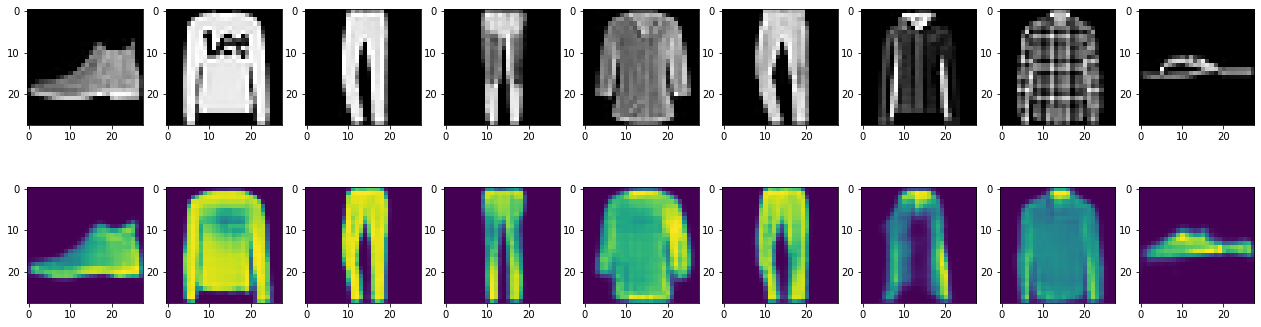

In [0]:
decoded_imgs = autoencoder.predict(x_test)

# Plot
plt.figure(figsize=(22, 6))

num_imgs = 9

for i in range(num_imgs):                        
    # display original
    ax = plt.subplot(2, num_imgs, i + 1)
    true_img = x_test[i].reshape(28, 28)
    plt.imshow(true_img, cmap='gray')

    # display reconstruction 
    ax = plt.subplot(2, num_imgs, i + 1 + num_imgs)
    reconstructed_img = decoded_imgs[i].reshape(28,28)
    plt.imshow(reconstructed_img)#, cmap='gray')

plt.show()

## **Analysis**

### Plot

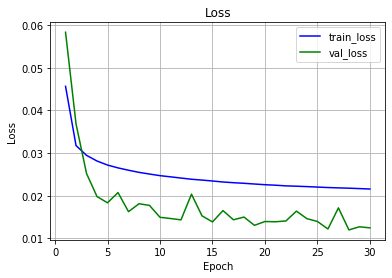

In [0]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
#plt.ylim([0,0.5])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## **실습 과제**

### 과제 1. Data set에 noise 가 추가 되는 경우 어떻게 동작하는지 확인해 보자
#### -- dataset을 읽어 오는 cell 에서 "noise_on = False" 를 "True"로 변경
#### -- Noisy data로 다시 학습하여 결과를 확인하자
#### -- dataset을 변경하고 결과를 확인하자


noise_on을 true로 바꾸고 수행한 결과는 역시 noise_on이 False인 것보다 덜 깔끔하게 들어가는 것을 확인할 수 있다. 

dataset을 fashion mnist로 바꾸고 난 결과를 보면 숫자보다는 덜 깔끔하나 이전 단계에서 conv가 없었던 것들보다는 비교적 깔끔한 값이 나오는 것을 확인할 수 있다.


conv 레이어를 여럿 넣어서 보정한 결과 깨끗하게 나온 것을 확인한 것으로 추정된다. 

### 과제 2. just fitting을 위해 Batch_size와 Epoch를 최적화 해보자
#### -- 최적화 이전의 Decoded영상과 최적화 이후 영상을 비교해 보자
#### -- 최적 값은 얼마인가, 최저의 val_loss 값을 적자 : 0.193
#### -- 두개의 영상을 첨부하라 :  



![대체 텍스트](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABO0AAAFHCAYAAAD9ZLgxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOy9e5BeVZm3/dvp7oSjIgcRMUGUY4CQ%0AcwiBcJBDOCvKy6uj41BTMuPwOa/4Wh5mqnSschwtRx1Fy1HRgnFgRh1ADnIQAggJEEKABBJIgEg4%0ACIKiIJFAunt/fxDy7vtai947yfM0u8nvqrLkpvt59t5r3etea296Xbsoy1LGGGOMMcYYY4wxxpj2%0AMOq1PgFjjDHGGGOMMcYYY0zED+2MMcYYY4wxxhhjjGkZfmhnjDHGGGOMMcYYY0zL8EM7Y4wxxhhj%0AjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYlrFJD+2KophTFMXyoigeLIriM506%0AKfP6w7limuJcMU1xrpimOFdMU5wrpinOFdMU54ppinPF5CjKsty4DxZFj6QVko6W9JikhZLeX5bl%0Ass6dnnk94FwxTXGumKY4V0xTnCumKc4V0xTnimmKc8U0xbliXo3eTfjsdEkPlmW5UpKKovhvSadI%0AetWkGj16dLnFFlusj1966aXw84GBgRDnHihWP59j7dq1IR41Kv4x4Zo1a0Lc2xubIPf9/M4xY8aE%0AmOdddw5FUYQ4d508L9LT0xPiwcHBIY/Jn7Ptc/A8+/r6QvynP/3pd2VZ7lT7RRuRK319feXo0aNf%0A9VzYxrk2ZD/xOxg///zzIa4eX5L6+/uH/LkkvfGNbwzx6tWrQ/zcc8+FmP3M69hmm22GPGdJevbZ%0AZ4f8zIsvvhhi5gLz9w1veEOIc7nC72RbM/9Wr17d1VypjlueG/uJY0dKr5H9wNznz9mP7KfcMbfd%0AdtshP8McZ/7xmOxXxrnzqMtP1kN+nueYg+fB8+Z3druuVHOVx2Ye5PotNwar1I2vrbbaKsRsQ+ZF%0A7pjMR85rvA7+Ps9x6623To7JevjCCy+EmNfFGlA3DnO5w/NiW/E616xZ07Vc6e3tDXMQaxpzg+2T%0AO3/WjbqxwTbi7+dykWOWx9xyyy1DzDFfl5852C/MDcLr5O/X1UIpzWl+hvVy7dq1XcuVMWPGlNV2%0AYy6wTXO5wushdf3I7+T177HHHsl31q3B2U/8Tp4Tr5M1IPedPObjjz8eYo4z5hrrSm7eq6vZPM/+%0A/v6u5UpPT09Z7Wu2KWvxn//85+Q76ta2zKW69X7dfJE7Rt2Y5To0Mx5DzH6V6tcK/DnXM3XrsCbz%0AO6+zGvf392tgYGDo5Pp/bPJ6hefGfsvdvzJ/2Gb8Dv6c6xG2ca428zz4HczxBrU7xL/97W+TY/I7%0AOaZ5Xcw35gLHWA6eJ9uyWosGBwdVlmXXcqW3tzfUFV4PzzVXJ9mGbKMNfa7A78vlSt19NX/Oc6g7%0Ap1ztrztvzmM8h7q5mr/f5Lyq37lmzRqtXbs2myub8tBuV0mPVuLHJM0Y6gNbbLGFZsz4f7/yyCOP%0AhJ/z4UPuwrnw4EB87LHHQsykWbFiRYh32GGHEO+5557JMZ944okhz4Hn/eSTTw55DnWDSZK23377%0AEPM6OSGykDLpWLh/85vfJMfkAoyDYezYsSG+9tprVyVfkmeDc2X06NHaf//918dMcBbt3OLwne98%0AZ4g5kXDgzZs3L8S77bZbiNmvb3/725NjzpkzJ8R33HFHiK+++uoQM/9Y1GbNmhXi3CLjF7/4RYir%0AY0ySHnzwwRDzZpy5M3v27BA/+uijIitXrgzxO97xjhCzrW+77bau5coWW2yhKVOmrI95vW9729tC%0AzLElSatWxdNjEX/LW94SYo7ZnXfeOcQcO9ttt11yzMMPPzzEnKxYd5jzPOaf/vSnEOcWwW9605tC%0AfOutt4b42muvDfHee+8dYj7Qffrpp0Ocq2VsS7Y/H3TPnTu3a7kyZsyYUFd4bNZF1lkp7SfWJt48%0A//73vw/xtGnTQsx+PuKII5Jjslax75cvXx5izq1vfetbQ8wawJohSTfddFOIly5dOuR37L777iHm%0AOGQ95c25lObKgQceGGJe57Jly7o6B1XznzWNY3rx4sXJd0yfPj3EHJOsvexXzjkc47mbNM57XCyO%0AHz8+xDfccEOIJ06cGGKOidxin+sqPggkrAF1N9usM1LaVlwjPfPMMyF+7LHHupYrW221Vajn9957%0Ab/j55MmTQ7xkyZLkO7i+4nqMawP243333Rfip556KsSXXnppcsxf//rXIWY/MMf/8Ic/hJj5zNrG%0AvJCkHXfcMcRcP3/+858PMdfPrCtsN9YlKa2fXEexrvzud7/rWq709fWFc2aesmbceeedyXew1vL6%0Adt111xBzfUNYizm2pHR8/fGPfwwxa9HMmTNDzNxhbbv//vuTYzJXuP5gHeF6m3WE6+3c/M6HNczP%0Aam3j/WYNG7VeOeCAA9bHdfe7e+21V/Idd911V4jZtw8//HCI2ea8H2A+5u4l99133yG/g3WC+ctc%0A4XV+61vfSo7J72RtY98vWxaff3EtyHk094chHLtsy+p9KWtrDRtVV6r3YVzrcw7N/Yej6n2UlNZa%0AjnHWf17/1KlThzyH3L/j/Rpzgc82OF7Zzk0eZHO9zHUn51LeD3I+yT1UrvuDseoaPVfz13/uVX/S%0AIYqiOFPSmVL9X8mZzZtqruT+is2YV6jmSpP/ImY2X1xXTFOquVL3X1PN5k01V/hXb8ZUqeZK3S4a%0As3nj9Yppitcrmx+b8iKKxyVV/xPX29b9u0BZlt8vy3JqWZZTnVSbLRucK17YbLa4rpimOFdMUzwH%0AmaZscK74PxxttmxwruR2S5jNAq9XTFNcV0yWTVmVLpS0Z1EUu+vlZPrfkj5Q96Hqn5iyIO2zzz4h%0AznlR+Gey7373u0PM/zLBvfT8zib/hZR/ns8/XeSf0fJPrn/3u98NeY5vfvObk2NyyxT/tJffyW0M%0A/HN//ulvbjLglj5u69qE/+qzwbmydu3a8GfX/JPYOheclG5XYhvW/eXn2WefHWLmUm4LAbclHHro%0AoSH+4he/GGLmI/uJWxBy+/O5nYRbc372s5+FmO3CbWsLFiwIcS4/uUWc44j5uQFscK688MILuuee%0Ae9bH3ApIuMVMSrdZcPsvx8ZOO0XdDbdns0798z//c3LMk08+OcRs9/322y/E/JNu9tsDDzwQYuai%0AlG5b43nWbd3k1gnmJz+f+x1eB/+MfwPY4FwpiiL8ZSb/ZJ01L1cj2PesTbnt5FXYT5MmTQrxpz71%0AqeQzzA3WO/45P7eZLly4MMTcupSbD1gvJ0yYEOJLLrkkxKxl3ELALQO5rUnMR9ZDbp3gFpch2OBc%0AGRwcDFtIOOdwGx7PVUq3gHFLCusm5232wUknnRTi3IPFD37wgyHmFnhuYfmrv/qrELMWcozkvDT8%0AdxxHl19+eYhZg7nFkcccN25cckyOTW6No7JhA7aybXCuvPjii2HO4HqM24xy6gJu0WGd4RhlHeGD%0AQ15/bo3EtS3nFP6ctZzbKjm/5LQQrJd1Tq1bbrklxAcddFCIuS7LrT04znhe1S2IUrplfAg2OFd6%0Ae3vDuOZ6hf3I2i6lW8o4T3O+4HZaboNjm1G5IqXb4rnllnP//PnzhzwHrql+/OMfJ8f85je/GWKO%0ACbYD16qcc1izmc9Smn/sj6oyYQPXuZt8z8z5j+ef2wbNeYm5zzmG604qU6iQyqkQWJs/+clPhpjb%0A5lnLqGVhvl588cXJMZkLvE4eg7WOcxLXFjn1S1W1IqU1trqdm/NTDRu1tq3eo3P88VxzWziZT1wL%0AsAbwHoPrHc4PbHMpbXeuI5lvdffMrIW5Mco1N6+D9ZPrZd7v8Rpycy11WlyHVdcIOd3XK2z0Q7uy%0ALPuLovj/JF0jqUfSj8qyXFrzMbMZ4lwxTXGumKY4V0xTnCumKc4V0xTnimmKc8U0xbliXo1N2v9R%0AluWVkq7s0LmY1zHOFdMU54ppinPFNMW5YpriXDFNca6YpjhXTFOcKybHpjjtjDHGGGOMMcYYY4wx%0AXWBYTcsvvvhi2FdORxpf0cx9x1K6b/2///u/Q8x929xrTH8E/XTczy+lrxzm/me6eehsov+Le+Nz%0Ar6jfZZddQkxvAI9JPwT38/Macq4m/js6KHLn2U2q/jY6criPna4tKfWY0DX185//PMR0xnAfO1/9%0AzjbN/Q7zjTlPtw19L/Qq8OdSmrP0EHz7298OMccZPUn0ZtA5I6W+Kp4nfTp0NXWSnp6e4LXh+GLu%0A5JxMzG16ctim9BFwzNO7kPMCLlmyJMSsbcwVvnacNYGORb6OXkrdUBzz9CHyHFhP2W70MknptS9a%0AtCjEOf/DcME2oi8p5/HkeGBus27ST8HaTm8U80BK69v9998fYnpp6FllfjLO1U/613herHV0E9Ih%0AQzcJPy+lDlDWbNaVbtLT0xPmWfqUeP6sEVLqgGH9Zi06/fTTQ8x5nLm0dGm6Y+a//uu/Qsx8rHOK%0A0XVDx9Ndd92VHJNzLWvThz/84RCzH7/2ta+FmP653BxEZsyYEeI6t2QnGT16dKitPH/mQc71RncW%0APXhcd7Jucr3MPmD+Smkd4BxCh26dN5VrqJyDl3MGPUicF2fNmhVirjXoQ8zVFR6DfiHWum4yatSo%0AMAbpYGKf5NZ8dE9xjNIBxvsDfv5973tfiL///e8nx+Q689hjjw3xl770pRDzvodOVM5hdC1L6Xol%0ANzdW4Xqacw7XL7n85L0V1/nV7+C47gbVc6zzqObcn8z91atXh3jq1KkhZj+w31i7ci5X9tO//uu/%0Ahpj5ydxiDeCYnzx5cnJM9iVdfJwH6xztrGVNajbnzupaj2Ow0/T394fjs41ZI1gDpfS+htfMl11w%0A/cHv5ByV8wJOnz49xKyHvJeio461jLU81+6/+tWvQsx7XuYXz4G1a/z48SHOzUF0C/Meulrnh8oV%0A/6WdMcYYY4wxxhhjjDEtww/tjDHGGGOMMcYYY4xpGX5oZ4wxxhhjjDHGGGNMyxhWp90WW2wR9v7S%0Az0KPFPeHS6kjjJ6nOtcP/Ur8eW7PNT0I3O9M3wqdRdw7T4/Nb37zm+SY9HRwnzfPm+fIPdF0rBx8%0A8MHJMW+66aYQ0+1wwAEHJJ/pFj09PcH1RG8C99rn/DX0NJ155pkhpu+C3zFv3rwQ0yfBfexS2g/0%0AHNGTQBcQ/RM8R+7fl1LnBvOP58Tv/N73vhfif/qnfwpxzuXAtso524aLwcHB4IFhG7Nm5Dwm9Pwx%0A9zl+6Afi+OQxczA36K55/PHHQ0zvAh0VrCv0T+S+k+OKTlBeF8cAfSg57+VQng8p797rFi+99FLo%0AS9bZhx56KMQ57wn/Hesi6zmdihzzbPPbb789OSb9QDxvukjo9mE+77XXXiHOudHo3LjwwgtDzLmX%0APhPmBh1ddPlJqWOWzpic36lb9Pb2hrrG9Qn9Xjnq6v9xxx0XYtZauldYV3bbbbfkmGznFStWhPi0%0A004LMR11zG/6WZjPkrTPPvuEmNfJ/GK+nnHGGSE+//zzQ5yb3+lmok/zDW94Q/KZblEURbhm1mbm%0AQa42E+Y+P0P3GXPlH/7hH0LM9pLStQHnB+YSHaj8PM85t55euXJliA888MAQH3300SG++eabQ0x3%0AJt19OV8zxwmvkzWYDq1OsmbNmlA7OK/T2cRcktK1LfuB58/f570X15U5z+zHPvaxEH/3u98N8Zw5%0Ac0JMTxnb/POf/3yIc2Oca1U6d7neoMuVbcfr4rwqpfnEmltt21x+d5K1a9eGewKulTjn5uYk9i3X%0AfHS/8b7mxBNPDDHHOP1zUuqP4xjmHEMPGccA6xDPQUqdnp/85CdDfMMNN4S4znnOezGuuSTpuuuu%0AC/FRRx0V4uo8xzHXabbeeuvgZGabcp6fNm1a8h2cx3lfxLHB9RjrDO9Nc/eJrAvMV64zOZdyrcvr%0A5nwhpU5drtk5h3DNM3HixBDT4Zg7Jq+LY7daq3LPvl7Bf2lnjDHGGGOMMcYYY0zL8EM7Y4wxxhhj%0AjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYljGsL6Lo6ekJcmDKUutepiClsnVK%0AayldphCTIlLKUu+5557kmBSRUqpMYTcFgxQkUyCck7ffd999IaY4nHJGClEpE6X4k20tSR/4wAdC%0ATAH1wMBA8plu0dPTE6Tcg4OD4ecUZObkw8wVvmCBYlLCfmUu5cSklGJS0jphwoQhv4Micr5YZd99%0A902OSbEzBe8UoN52220h5otVKOlctWpVckyOCco/KebsJltttVWQ3nOMUwBKOaqUvliC+UVZNq+X%0AMXMvJxalbJdyXcqz2Y/8To4BjhkpFaQyH3/wgx+EeOeddx7ymKzRfOGBlL7E44gjjghx7iUI3WJg%0AYCBIZZn77LfcS0uYTxTAc0zvuuuuIWbt5Zxz8sknJ8ek4Jf5ScEvhdWULl955ZUhztUVzjFsG85J%0Ad9xxR4gpNWY+cu6V0jmn7oUa3aQoipDfzFOO39yLNfiSKrYJxw9zgXWJuZV7iRVzgfJoCqnZD8x5%0ArkUogpbSlxxwvcH8Za2jMJ7jki+vkVKBOuct9k836e/vD/MKXxrB3Mi9fIfzEtuZLyzgvM82nTFj%0ARohztYxjnGue2bNnh/jWW28N8fTp00PMl5nlXmLFl6DxBS9cZ82fPz/EXIfy86wZUio75wsO+GKU%0AbjJq1KiQD3X3A7m1Otf37HuugeranGMlV5sPOeSQEJ999tkhZj/xhUqf+tSnQswawfyWUtE986lO%0ACL948eIQ836RL7aQ0lpz9913h7hak5u8UGZT6OvrC+uHupfv5OokX1rI8cF+5HzB3OD9Q+6lEHwh%0AyCc+8YkQ88USXFcyN7hmXLhwYXJMzlPMcb4Yi/fp55xzTohZf3P3QXyRCfOpOu/lnmd0krIsw3qD%0AtZ1tmntpCdcb7Hu+3Im/zzmM606ek5S+EOOSSy4JMfuB62mumXhvmnuRD8cAaw/XVZw7+Xnem/G6%0ApbSmslZVa91Qz1r8l3bGGGOMMcYYY4wxxrQMP7QzxhhjjDHGGGOMMaZl+KGdMcYYY4wxxhhjjDEt%0AY1iddi+88EJwfNHzQX8B/TY56MWjD4J7g+kIo3OG+6Vz50m3D/0R3G9PBxIdAHSx5H6H7gTuj6d7%0Aih4Gem6431+SrrvuuhBz//qTTz6ZfKZbvPTSS8HXQNcKXVw333xz8h10LvH8+/r6Qky3CI/xy1/+%0AMsRnnXVWcsyvfOUrIaY3gXvn6ULjddA1RaeFlOYP3Q7c00+vB90G48aNC3HOqcIxwD3+OcdgtxgY%0AGAgeDrYxfTW58Vb1nL3ynVU4xtmmHH905uQcMcw/tjPHPPOX/cRzpmdByruUqtB7wZrMtmW75Jxj%0AbBv6N1kfu8lWW20VPEwcT/Su5Xyj7Hv6Wzimeb308rC25TxlnIP4O5MmTQoxc4dzKd0juWOybdhP%0A9NCw7x999NEQ1/mvpDSfWP/oY+sm/f39oS7w+um5pLtRStuIviDO45xzH3rooRDTZcX2kqR3vetd%0AIb7qqqtCTE8N1wYc81xL0A0kpf4qjiO6f7i+YV3iGJs7d25yTOY4112cz7tNdZxzTLMfc84brhU4%0A/nh9rCNcuzKX2I+SNGvWrCHPk23MY3BupY+O7k0pXYPTlcZcYcx5jrUx5wPivMX85HnnXGedore3%0AN/Qd3YQ8N3oFpXS9xfHDWkwnGGsvXVOXXXZZckw6dt/3vveF+Etf+lKIOcfQx9lkvcL6yH6cMmVK%0AiC+66KIQc91FJ2POf8i5kt68qtMt9/lOsuWWW4aazxrAWs11rJTe63E9cuSRR4b4y1/+coiZG6xT%0AdPpK6VqWx7zmmmtCzFrFMc3cufHGG5Nj8jN77713iK+//voQcx77y7/8yxCfe+65Ic7de7FteB3V%0A+6TcXN1JuF7h/MexxLWIlLrbeB9Df1zdnMNrzq2RmJ9cj9DTuHz58hDznoWf532WlLYF85XrTq6Z%0AOO7pp3viiSeSY9Ixy/u56nnnfOSv4L+0M8YYY4wxxhhjjDGmZfihnTHGGGOMMcYYY4wxLcMP7Ywx%0AxhhjjDHGGGOMaRnD6rRbu3Zt2PtLXwb3U/PnUrpvnd6cOh8L909zv/SKFSuSY26//fYh3mmnnUJM%0AJwVdN/SzNPHy0O/APdN0onBfN10OVT+clPompHT/Otufbqqck6hTbL311sGBRA8KXSn7779/7Xey%0ATXk9zA263s4555wQr1q1KjkG96Jz7/tPf/rTEH/3u98NMT0El19++ZA/l6TTTz89xPSXfOhDHwox%0AxwS9BDznnH+nzkHEMdFNBgYGgm+Kvj36C3L+Lo4Hejvos3rTm94UYl4/61TOjcYxSW8C3Xv0RdCb%0AwHOgR0RK6yOdoPTM0I/In9Nzk4NeC1433ZPdzJ2yLINzjv1OHx1zSUodN8wn1s03vvGNIeacxfx8%0A8MEHk2NyXmI+1vlh6Xdh7ixdujQ5Jt0+9ObdcccdId5xxx1DvGjRohBz3qOrSkodMRw33XYIVVm7%0Adm1oJ455eju5LpCi/0hK+4HXyzUQfSx33nlniJlbknTBBRcMeUw6YZhbHAM8Rs5Lw7mU17HDDjuE%0AmP1Yd0yOESnNec7f9O8MJ3TDsQbmfM2s76y1HNNca9TlTs43yvrP33n88cdDzDHAfuW6LLfOzOVs%0AFbYN5zWeA9fG/H0prT377LNPiIfTq8r7II4djo3ceoVjkGu4gw8+OMSXXHJJiA899NAQc12ZcxK/%0A9a1vDTG9d8wd3lsxV3hduWNyHHG9ccstt4SYax6uNdjWdJrnzpPexup9yfz585PPd5Lnn38+ePh4%0Ab8k5tsmab+bMmSH+3Oc+F+KjjjoqxPQI8n7g8MMPT47Je8ljjz02xN/+9rdDzHUWxzC9jjlv5WGH%0AHRZizq0HHXTQkN9BNx/vF3O1jDnPOlLN32477QYHB0PtoPOU50rfbu4znB94T0KHIudgettyY5ye%0ASfY916pcf8+bNy/ECxYsCDHXrVKab3TacS7luOLP6WvOzbW8DuZr7tlTDv+lnTHGGGOMMcYYY4wx%0ALcMP7YwxxhhjjDHGGGOMaRl+aGeMMcYYY4wxxhhjTMsYVqddX19f8BzQy8D9+jmPCfeh091AXwv9%0AGXS90XtCn4GU7rHmfua3vOUtIaZjg74W/n4OejtWr14dYnoF6F8j9L/kvCJ0UNBZxHPqJmvWrAlu%0AJzo7uB+fe+el1MHBa2aucL8+fS4f/ehHQ3z22Wcnx+R5sp/4HXSLMP8+8pGPhDjnrNh9991DTAcH%0A+43uNLoW6LT4yle+khyTTjt6M5hL/P1OU60LdFnQXzB58uTk8/ToMKZLhS4H1ip6pHIurjFjxoSY%0AHhD2K11nzBXm9+23354cc8KECSGm24e5wOum+4FxDrqXmH90L3WTvr6+UH95/jwXeqak1PPH7+B4%0AYy6xRnAezDkk6VfhfMBzoguO/cr6mRufvK6666DPivnMuZt1SkrHCT9Dd2s3GTVqVDJvVqGjJNdv%0AnFPYJvz+JUuWDPn7dMI899xzr3p+r0BPDdczdLOyD3jM3BxEnyGdLlwTjRs3LsTsZ3ohmWtS6g9i%0AvtJhRGdRJynLMtQ59jvPjTVRStdwrO+sAZzneEz2Iz8vpWtTtjs/w/PmeKT/mXOclM6d7Ef61Zif%0AXD9z7cFcy32G83XOOdst+vr6gv+S7cE2ffOb35x8B/2ZXBuwXzlmWXdYExYvXpwck7/D/JozZ06I%0AmQt01XJM52rZ2LFjQ3z11VeHmGsktgvblmsP3iNIqbuM93vV/MrVwk5SFEVodzqujznmmBDnfMAc%0AX3RpsU3ovKZHlXUp54PkPMYxeeONN4aYOc45h2uqnOeRLjOuh6dNmxZi+hA513JdlqtlzA2eZ3V9%0AzXbtNGvXrg33wRxPnHPpd5TS+s/7OK4j6ew95JBDQsw6REelJM2YMSPE7DfOc/zOI488MsT0POZq%0Ae50rmeth5iOfI/FZAp3oUjp3cv1Yrcm5Z1/rf/aqPzHGGGOMMcYYY4wxxrwm+KGdMcYYY4wxxhhj%0AjDEtww/tjDHGGGOMMcYYY4xpGcPqtOvp6Qmukz322CP8nC4B7huWUr8F3TyPPPJIiOk84J5qule4%0Av1+S7r333hDPnj07xNx/zOuib4LOCu61l6RLL700xNxrzr303C9NRwCdAvy8lO7pv/XWW0M8lN+n%0A05RlGfaZ0y/HvfY5Zxi9Bzx/7um/+eabQ0zfF/OTzhwp7euvf/3rIWZ+3XXXXSGmk4MeBToYpdSj%0AUOcZ4+9zvz7dBzn/Dj1JdN9wXHWT3t7e4FSiY4N+gZzj4G1ve1uI6W6g6+yll14KMWsAXSn0u0hp%0AG9EJdv/994f4i1/8Yoi/973vhZheM3qmpNRLs3Tp0hDX+TbpG6J/IpcrdNfQlTmcdYWuTNZJettY%0AAyRp3rx5IWYdofOFtZdjfNtttw1xzmFEZyfHLL+TTg7OSaztHPOSdM0114SYjpQ6Zwq9e+xn5p6U%0A+jRXrFgRYvqrukl/f3/oO/ZTE28lnYgcH9ddd92Q38nc4fon56WZOHHikOdFTxRrN/OXdWmvvfZK%0Ajsm+5THoReJ6hjFrONteSp0whHNxN6GvmWtGjk96eaR0/cU5g847zjmTJk0KMccK+1FKfUKc17nO%0AmjJlSogvuOCCEDMfFy5cmByT/TZz5swQc53F/KVHjGMi5ymjY4s5zHkvV5s6xcDAQKiN7GfWiEcf%0AfTT5Ds4HrL2876Fziet/fh/9iFI699N3y1rF3+ecVDenSfU+Yq6PWXfoyuS4zK1TmV8cN9Uc5/d3%0AGt4HcS3LeZzrOykd0+x7jvH58+eHmGtjtg/db1K6LqS/lvft7Af2K92ErHVSvr5VOffcc0N83HHH%0AhZj5x7bOeeN5L8+2rtb5oTxlnYD+Q649uA7P+eXY1+wn1gWu13J+wypTp05N/h3Xiaz3rI9cC7Df%0A2Sc5XzNrU5N73iocQ1z/5FyXPG/eU1afDeSez7yC/9LOGGOMMcYYY4wxxpiW4Yd2xhhjjDHGGGOM%0AMca0DD+0M8YYY4wxxhhjjIyiL/MAACAASURBVDGmZQyr064sy7DXl/ufuY+Y+/Vz0KtAjxP3EXNv%0APd0idCZI6Z5q+tXoK7n77rtDzD3aH/rQh0JMD4OUXsdFF10UYu6P5377LbfcMsR0DJx88snJMeu8%0AZDkvV7fo7e0Nbie6pujPyLkp9t133xCzjeiQoQOGvgr6rb72ta8lx6SPavHixSHm3vlzzjknxPQq%0AcD/+d77zneSY//Iv/xLiyy67bMjvoOuP47CuraXUi0f3CI/RTYqiCH4Aej3on+O5SmkdWLlyZYjp%0AmqIHhN4ZeqFyrkz2C108dL/xmLyud77znSGmt0FK+419S98f3Qx0XtCfmPPocdzxPHOOwW4xatSo%0AMMbqrp9eQSmtg8wd1g36WTgHsZbn3Gh0iTz11FNDnhM9T8xHQueTlM4Z/B0ec9GiRUP+nPl75JFH%0AJsdke9PNRA8I59pOssUWW4Rxz36rczhJ0rHHHhtirnHos2XfM3dYuzjP5+B3jh8/PsTXX399iDkH%0A0VNGF5WU1sdly5aFmPMzv5NjiHMQ+11KvS9sC8Zct3WSoijCOGYbco2X85Sxb+kToquHawn+nOs5%0AOo2kdA5ivjGnOX/QWcc2zzm2jjnmmCHPgfMa3cE33nhjiOm3yq1XJkyYEGLmDr1K3WTUqFGhrzg+%0Amaecc6XUW8nxx/UGxxvnafq7ch4orhM5x3COYj5zfuA15ByUnEM4JzHHOUfR5cpzyvnYmH/0G1dd%0AYXRxdoPqGOJageOL41NK84m1lmuDj370oyFmvzO3cmtb1gHep9MhyX5i3eHaOFc/OUfMmjVryO+g%0A15L1k/5D1mOp3mlYnfeYV92G/cqxkqvNXFeynzj+uF7jd7JPcr51PqNhvvE+ntfBuZZ1iI5UKc0f%0Ark3pUOScwjpDf2CTtmVbVvsr9/lX8F/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYllH70K4o%0Aih8VRfFUURT3Vv7d9kVRXFsUxQPr/j/9m1yz2eFcMU1xrpimOFdMU5wrpinOFdMU54ppinPFNMW5%0AYjaUJk678yR9W9J/VP7dZyTNLcvyy0VRfGZd/Om6L1q7dm3YF06nAf00dFVI6X587hPebrvtQkwn%0AE/eg8xj8fil1TnBvOt1o9913X4jpkKF3IOePoFvkYx/7WIh5XXTlbL311iHmPvCcJ4POCX7nr3/9%0A6+Qz4Dx1KFcGBweDZ4T70rlvPee8oaOAXgW6tuh8eeKJJ0JM70fOo3fGGWeEmO6Qz372s0P+Pvf8%0AX3PNNSE+/vjjk2OeffbZIT7ssMNCzLZh/rIteV3c3y9J+++/f4iXL18eYrr9Mg6K89ShXFmzZk04%0APh0IHF90lEipl5J1guOJ+ch+Y6489NBDyTHp2KC/hb6VFStWhJjeENap3Jh45JFHQsyc55ihQ4U1%0AgU6XnMuQ3i56MHL5Bc5Th3Klp6cn+Cc4f3As5HwtHD/0BTHf2A9sU3p2Dj744OSYdf1GRxPzjWOa%0A9Z/zjZTWe85b9Chx7qSrhOOOLhIprZeswTlnDzhPHcoVujLp3aHnhF4UKR2TdLVx/NCNwlyh4y+3%0AXuFcz/xiP7AOsV84RnLzHnOeftgDDjggxMxnOlx4DZxPpHTO4XVxTGQ4Tx3KlT/84Q/62c9+tj5m%0A/ed8kvMbsZ/oWaNTlw4wtiH9nDlvG9uI30GvNPuFdebEE08McW680oXGdRnbivMDXVS8Ls7/knTl%0AlVeG+JBDDgnxc889l3wGnKcO5Upvb29Yb9xyyy3h56yrnHOldA6lH4kuKo5h+jlZl3JzMnODawWe%0AJ71kHBOsEXQXSul9Dusp5wfWU/qxCOd7Ka2pXNtVc+VVnGbnqUvrFY5prgFzvlHOwxzTvA/iOpT3%0A1ByvubUD+4ntlPNKV2EfsM7Q9yyl8zPbimuLpUuXhpjzOXOHLmYpvdev861lOE8dypUxY8aEMca1%0AA8cj64yU5jrbgPdxXAvUXW/OIcm+5nqEawXmH8+Bv5+rn6xvnEt5H3PooYeGmPcFrIWsW1Ja74a6%0ALx3KlVj7l3ZlWd4kiU+VTpF0/rp/Pl/Su+u+x7z+ca6YpjhXTFOcK6YpzhXTFOeKaYpzxTTFuWKa%0A4lwxG8rGOu12Lsvylf/E8aSknYf6ZbNZ41wxTXGumKY4V0xTnCumKc4V0xTnimmKc8U0xbliXpUm%0A22OHpCzLsiiKdL/ZOoqiOFPSmdLwvB7btJcNyZXc1j6z+eC6YpqyIbnSYLuCeR2zIbmS2/ZjNh82%0AJFfM5o3nINOUDckVbrszmxderxiysX9p99uiKHaRpHX//9Sr/WJZlt8vy3JqWZZTucfabBZsVK7Q%0An2E2C1xXTFM2Kle8CN4sca6YpmxUrgzb2Zk24bpimrJRueI/Xtgsca6YV2Vjn4xcJunDkr687v8v%0AbfKhnp6eIEyl/JQiyWuvvTb5jjlz5oSYkkEKMCmMp+CPQtYclO4TCix32GGHEFNiSCHmypUrk++k%0AtJXwuigUpoyR8l62vZRKWSmIpEixIRuVK0VRhL+g4n+dpDAzJ1mePn16iCmMp2STcncKkyloPeus%0As5JjUtrKNqRs98ILLwwx/2tJE1nvf/zHf4SYbUU5KiXMHAMchzlZL0WeFIUz/xqy0XWl2u6UhHJs%0AsEZIab9RoP3444+HmG3EXKJwlRJYKR2D48aNG/KYlNSzjSnCz40JnicF3DxvCq35cgLK0XMvorj3%0A3ntDzPzMyfQbsFG58tJLL4VzpMSWY4E1QUrzi5JvCvEph6YAmLmXq81swwMPPDDEzC+e0+LFi4f8%0AfUr9pbRuMF6wYEGI+RevnJt5DswtKa0rU6fG5yEUPzdko3Jl9erVWrhw4fqY9Z/jMSdZ5osjOGa5%0A0Gat5Qsc7rnnnhBzjpLSeY79xrUDz5t1hP2Ye+EG10Bc47DOUETO6+CDjZwE/Kqrrgoxa/Kdd96Z%0AfKYBG5UrY8aMCS934dqDAu9crjCfOB9QGE9hN2sC60juhWdsZ65d+ZIrvuThV7/6VYj/7u/+LsS5%0A8TplypQQsz5yjc7/gMv5g/lMAb2UviyO60eO7YZs9BxUzXfWCP5HyNy5cYxzfNXJ2utePsP5RpIm%0AT54cYq6jeJ6sdcxHfn7ChAnJMZlfvJdi27FfmX9jx44N8fz585Nj8l6JuZN72UMDNvo+qJoPfPEE%0AXzKR+2MH1mu+6Gru3Lkh5kuqWIfYxrn7Y9Yanmfdy7zq5sWcqH9DX35x2223hZgvc+G6LDefsD+4%0ArqrmG9fzQ7BRuTIwMBBqH9d0rAm5exKeI9eqdS/9YZtz/XzEEUckx+R4Ov3000N83nnnhbj6MlMp%0AvUfmOjT3Ugj+O44R3v/dfvvtIeZ9ONdYub965Hdynqrm/FAv0ar9E5WiKP5L0q2S9i6K4rGiKP5a%0ALyfT0UVRPCDpqHWx2cxxrpimOFdMU5wrpinOFdMU54ppinPFNMW5YpriXDEbSu1f2pVl+f5X+dG7%0AOnwuZoTjXDFNca6YpjhXTFOcK6YpzhXTFOeKaYpzxTTFuWI2FMugjDHGGGOMMcYYY4xpGcNq++/t%0A7Q37xLlHnH4kOjqkdN869zdzrzz3GtOb8MQTT4Q4t5eY+7i5H/rBBx8M8fvfHx+ec698nY9OSq+T%0A+7S5l5771dkOO+20U4jpR5FSjwB9OmyrblIURTgfOhHYrzm5L90M9GPQo7B06dIQT5w4McTc73/q%0Aqacmx6THg94mehW4l55+Qzq22M+SdP7554eY/cjcyflKqtBPRLeDlLoz6NCikzHn0+kUg4ODwc/A%0Ac+NYyDli6GKg44VtQK8ZvR4c03SvSNKiRYtCzPFFfxU9SHSEsc7k3H3M6bvvvjvE9A099NBDIWYd%0AYf2lK0dKxy6dKBwj3cwVujI5VlhHcjVvv/32CzFrKXOFdYaeD455ekSk1HdFDwjnKDqMWHf4fTm/%0AHJ0o999/f4jpEOM4o7ODv5/Lz7q2Ye50k76+vnA+OTdKFY4NKa01rAN0KtHZS+8O/XJsUyltd54D%0Ac4djnv1Ici/+YdvQbVl1A0qpV4kOGOYzfTBS6lFlLeJ6ct68ecl3dIq+vr4wl7ON2T70RElpu7IN%0AOTboF2UdYm5wPSeldYJ+Ufo5OR8wH7kOoAdNSvOT8zWvk/Mcj8ncyc0frDU8xnC++GxwcDCMMeYG%0AHU055zXXdHRFMZeYK6z/nB9y7inWXtYyzp08B65PmAe5exKeJ11SP/vZz0K89dZbh5jrkRUrVoQ4%0A58rkdfI8q/dvbLdO8/zzz4e6RR81cz83P3KMH3nkkSGmm5ZzEJ3ZrMVXXHFFckyuebgeZh256667%0AQsy1BtdEOb8c8+vWW28N8Uc/+tEQH3bYYSFetmxZiDkH8f5QSu8b2DY5L3+3KIoi1DGOT9475hz1%0AfDbBtcB73/veEL/vfe8LMdf6dG3SFyml7c51J8/zjDPOCPFRRx0V4k9/+tNDfr+U9iXrKe//WCc4%0A7nnPnKsLbFveW1Tn55yz8RX8l3bGGGOMMcYYY4wxxrQMP7QzxhhjjDHGGGOMMaZl+KGdMcYYY4wx%0AxhhjjDEtY1iddmVZBn8DnRs77LBDiHM+oT/+8Y8hpouCDgPuMafbgS6qVatWJcekc4LOosMPPzzE%0A9AN9/etfD/G73hVfDJNz9xH6rOjPof+E101fBJ14UuodoCOAfrVu8uKLL4a+4J5yOkr23Xff5Dvo%0Abvvwhz8cYvpX6GH4wQ9+EOLTTjstxDfddFNyTPqDuB+ffgw6Y+jpoaMj52vhd9CrR6cFxxn9EXVt%0ALaW5wXHHfOwma9euDT4jOsc4ftkHUupOqTrypNTXQu8CHR0cS3R2SNLYsWNDzHykH4KOJnoX6HC8%0A8MILk2PSa8Gcp5+T/fzss8+GmI5Q1mdJWrJkSYhZP+mi6iaDg4PBVcLroTOH7SGlrh6OWUJPFB1F%0ArBE5P+eOO+4YYnqd6MDg3Mnc4DnkvEnMr1NOOSXEbDvmL8dAnZdPSt019MrUecw6SU9PT6id7AN6%0ALenekqRjjjkmxKzNHON0LHK9wnk95z6hy4ZzBj2qrIecL/jz3DqA6xHGnIs5zuhNYl2iI1VKfTms%0Ap3UOwk5CBy+dOVzj5byBrJ1sQ87DHJ+c1+vWc1Jaa370ox+FmGsLrkfuu+++EHNdyXyWUpfrjBkz%0AQsx843XyHNjPufsG3ifQL5TzqXWLLbfcMviLOMewjubcU+xLXh/XdKz/kyZNCvF//ud/hji3fhs/%0AfnyIWf/ox6W/6vLLLw/x1KlTQ5xzTrK+0WfFNQ7XbcwlrlOZS1LqheN8X70u5n+n2XrrrcM9Ku9P%0AeT25OZXn/zd/8zchZn5dddVVIeacTF/XWWedlRyTdYP5xvHGenjiiSeGmPWT82LuGJwf2Nc//vGP%0AQ8y1BNceORc45xzeF1TnrW7fEw0MDIQ5hHMmnexcQ0ppLZ09e3aITzjhhBDTu82x8+///u8hzrlD%0AP/KRj4SYfc17as6LbPMzzzwzxLl5jy5Mui55v8b7Jj6PYb7n3PPveMc7Qsw6X52L6dir4r+0M8YY%0AY4wxxhhjjDGmZfihnTHGGGOMMcYYY4wxLcMP7YwxxhhjjDHGGGOMaRnD6rQriiLsaeb+6UcffTT5%0AfcK97+PGjQsx9wnTE8I919wPTSeClHo6/uIv/iLEv//970PMvfBHHHFEiOl6yO3zpgeJ0EPA66Q/%0AiJ6PnCOGbTNr1qwQL1iwYMhz6iQ9PT3hGrgfny6W2267LfmOc889N8R0MNFHwf35dNZ94AMfCDFd%0AK1La9/R30aXCvfF0VNDLQN+QlHqOeA50yLBf6XWkR4R78aXUzcT8oush58zqFNtuu60OPvjg9TF9%0AQnQa0O8ipbWGvgf6Lugs4OfpEaFnSkrH6PXXXx9iejvoLLr66quHPKfcdTLf6G5grWO9Ze2ihybn%0AY+Mx6axgW7OedhLOQXWulKOPPjr5DtYNukroo2BusG6wtuV8V2xnelE5D06fPj3E9JDxnHMuQno6%0A6P3g/M05iQ4ufn7MmDHJMev8k3XzYid58cUXQ7vx2PTR5cY4xwO/g7nAOkNP1PHHHx/inFeVdYJt%0AyHxkvvLzrGW5ulLnFqxbI9Fbw7UIc1FK25/fmXOXdosXXnhBy5YtWx9zPDIPXnzxxeQ7OB7YpvTD%0A0fvHOsoxnfO2nXrqqSGmC40xnZJ0CfP3c65h9gudbjwn1kfWX+ZGzmXIcccc5hoo58XrFGvWrAl+%0ArGnTpoWfs9/py5XSXOGcwXUm1xp1651cfrJ+c51I5y4doLzPYb/n1rasA2ybI488MsSXXXZZiI87%0A7rgQX3TRRSGm31NK23sob3rOedtJyrIM+c3azH5i3ZGkKVOmhJj3GMyFXXfdNcR0F3KNyHsUKZ3X%0A+J2HHHJIiCdOnBhi1giuLehDlNJ6yGPy+QLXvocddljynVXo8pPSMcF8quY059FO09fXF3z6fBbC%0A9Rjd5VLa19/85jdD/J73vCfEXNvzO3nNuTb8xje+EWKON/pvecxPfOITIeY6IOcEZd1g2/B9C6yP%0AHEPMJXrVc8fgeVbv/3LrnVfwX9oZY4wxxhhjjDHGGNMy/NDOGGOMMcYYY4wxxpiW4Yd2xhhjjDHG%0AGGOMMca0jGF12q1du1ZPPvnk+pj7n+mqyHkV6GKjK4vuBnpA6P/innTun5bSPdF0qdC5QacG97nz%0A+3IOI7oL6BGgr4Q/p3OM+/u5J1tK923Ti0HvTDcZNWpU8CLQu7DTTjuFOOc64p5+Xh+9CPPnzw8x%0A25TtkXO9MWeZn3Q1VB0Euc9zb3vOf0gPF/v2yiuvDDE9XfQMcO8920FKPUi8DrZ9NxkcHAz9T4cd%0A/Xo5XwDHE9uATiK6L+nwaOKIoYODbUYHI8cwfz558uQQ53wrvHY6Y+i0oGuEbiqOw5wjhjWYHlHW%0A7G4yODgY6m3VLSRJM2fODPHTTz+dfAc9Hexrun3o4GAbMXdyjhiOr6233jrErDOcg5hbEyZMCPGt%0At96aHJM5y/maNZe5xOuiJ2rSpEnJMXntbP+c57Zb9PX1hfzm9bB9crnPes21Q50PkXMu24e+Iimt%0AE6xle++9d4jpY+E8xz7gz6XUp8l1FscM6ydrNn1ZdKnlPsN6x+ukH7CTbLHFFuF4rKPVda+U1mpJ%0AuuWWW0LMNmC+cZ7neKRPju0hpfnJMUovGc+Bv89coitOStfwzzzzTIi5duUY4fqZrj7mv5Q64Pbc%0Ac88Q0/vbTYqiCGsqji+2eW4O4jzMeYx1gmuFuvVKzk1LD2CdL5znwJg+2dyakb4/ngPnQXrLqp5J%0AScF9LOVd2Ky5rHerVq1a/8+5e7dOwvsgjj/mxowZM5Lv4FqAcyj7hb7cs88+OzmnKqz9UuoFZJ24%0A4447Qsx7GN6TsGb86Ec/So7JWsO59O///u9DzPsg3nNzzHDultJxMpRXlWOs0wwODoa5nnWQdTPn%0AyqTL7ec//3mImX9nnHFGiBcvXhzi0047reas0/HF+6IDDjggxJxbWbs5X1x88cXJMbkmP+aYY0LM%0AGsxxXjfX5p6VMDeYO1XP41CuTP+lnTHGGGOMMcYYY4wxLcMP7YwxxhhjjDHGGGOMaRl+aGeMMcYY%0AY4wxxhhjTMsYVqfdqFGjtM0226yPuZeZToTZs2cn30GPAl0V9O7QN0e/1amnnhpiOhCk1B3C/fj0%0ACNDJQacT9yvTVySl+9/p/aAzhnus6WaiL5D+Nin1XHBPf7f35FcZNWpU2IPPfe68npz3gx4c7nUf%0Ayj+Q+zxdVdddd11yTDrD9ttvvxDTucG+Z74+/PDDIabHR0r327Of6IOgT4heG46pHByH9GTwGN2k%0Av79fv/3tb9fHdDew33NeQJ5/XS7QP0TPRxPHHz0f7Ce6Quj5oGuQ9TPnXKS/hGOA18m6QtcDnTJ0%0ARUhpW9CxNZx1hcfba6+9ws9uuOGGENN7KaX5VZ3TpLS+c6xwvLI9WNuldExyPmAbMsd5TvS/5Fxx%0ArDX8HeYv24FxnT9LSnOaDiN6vnL51il6e3tD7rLNt9tuuxDnnHbsa9YB5h/rfbWuSamHJ9eG9KfR%0AQ7NkyZIQ5xyfVejy4fpGksaNGxfi22+/PcS8bs4PdEuNHz8+xLl+ZtvSEUO/WrepzgHMW/YjYylt%0A5zq/IccX10Scwzi/SGm/cIyz/vMcOLdy/ZLzQBF6UzkGOEdx3E2fPn3I35fSGkwHHN2s3aQsyzCX%0AswbcfPPNIaaTTErXlRx/rAGsm8wNri1yDkmOWfbt7rvvHmLmJ91UXIsw3yXpV7/6VYjp2OK9Fe/V%0AmI+85+R6Rkpzg99ZdZ/RxdZpenp6wjzMWs75Mpf7J510Uoi5dmXucHzx+umDpGNMSus3PXn8DHOH%0A8Pdz7j5+B+8J6XCjh4z9znbIuVw5TljXq2uCXDt1muocxPsHjlc+I5DSMc76Tick87FujPM+Xkrb%0Alf3w3e9+N8S8z6EbmXNWbkywpn77298OMeeUunsW+nJztYz3Y1zTV/OTa80q/ks7Y4wxxhhjjDHG%0AGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYljGsTrstt9wy7COfO3du+Dn3/OZ8A/Qk%0AcL89vWMTJkwY8pzocsh5P+iH4O/U+eboulm8eHGI6WbJHYMuEfpLuEd7xYoVIab7ILfnmq4m7j9n%0A29Lt10leeuml4LFhP9FNSLeWlO7Hr7oopHRP/9e+9rUQM/8eeOCBEOfcb294wxtCTBcPr4PeKO6N%0AnzNnTohzLhz6SuqcWdzjz37nfv2cb2Lp0qUhphsnl9Pdoq+vLziEmOvsN44lKb1m1hk6cejhyZ3T%0AUJ+XUh8G3Q48B/YT6w79EsuXL0+OyTHMmksXFT1RdGg1qSusTawrw+H6eIWenp7gKqHDg36MnL+L%0APiDmE2tA3fXXeaKk1DV17LHHhvjSSy8NMeeHww8/PMSsOzmvIM9z5cqVIaYDlfUy52KqOyYdKKyx%0ArGXDCccr1wUcK1I63jg+GNPXQlcm6yxzTUrziXWB58ncYq2iY+zAAw9Mjsl+mTZtWojpiqSriu5I%0A5g4djFI6n7PO0yvH/uokAwMDod3Yhlynsp+ltP6zDXj+7Dde/ze+8Y0Q53y4XDvQ5cM1OtcObGOe%0Ac268co7hd3DtwPmBrqkm/ly6rhctWhRieuW6SVmWwbvEscF+4viV0nZlfNVVV4X4rLPOGvKcuH7m%0AHCelrijWIvqueA70y9F1m/M40TXIOYfeLs4f/Dnn85xPnLWIzs9Vq1at/+dur3PLsgzHYI3gvWau%0ADTneWJu4VqV3m/cwXCPl3KG77rpriFnvmOPsV45xniPvk6R0fcL1C3Oa9+V11838l9Lc4Jq9+plu%0Au5v7+/vDmGQbsd9zuX/PPfeE+JhjjgkxvYC8Jh6DbZZ7vnL//feHmP5DrpG4/uB6hk683Los5+wc%0A6jNck/P5A33NU6ZMSb7zpptuCjFdktW1op12xhhjjDHGGGOMMcaMIPzQzhhjjDHGGGOMMcaYluGH%0AdsYYY4wxxhhjjDHGtAw/tDPGGGOMMcYYY4wxpmUM64sonn/+ed16663r4+OOOy78nFLz3EskKMCn%0A+JFyVAotKYbmCxv4fZI0Y8aMEFN4SaEgZacUBFNinxPpUjK8YMGCEO+9994hfvrpp0NMaf2zzz4b%0AYspWJem6664LMWWi7J9uMnr06NCuFMxSAEohq5TKJnn+fJEGc+GUU04JMduYL5WQUtEmxc0UslLs%0ASSkzxaCUwEqprJ3fSaEqpcXMX8qpKSLPfQfzje1AGW4nGRwcDMJT9iuFqxTOSmlf8gUNFDVTuMr8%0A+8UvfhHi8ePHJ8fkuGff8xh1MlQKq/lzKe03Sl55HZSfsyawruReHsT6Rzn073//++Qz3YLCePY7%0Ahci5lylQaMxcWbhwYYh5vawBHOMf//jHk2OydjG+8847Q0xx/4033hhizmknnnhicsx58+aFmG1F%0AWS9/ztz49a9/HWJKxqU0fyg6zn2mW1DszLFxwAEHhDiXx2wTyq+ZG5QV8xisQxR0S2n945hdtmxZ%0AiHnenGMOPfTQEFMcLaUvMOD6hflKgTvHGXOF5yylc84ee+wRYs5j3aQsy9DX1ReuSelLgZgHUlr/%0AWYu4lmCbMTe4FubLMKR0fFGgzTlnyZIlIWbuNFkj8qUQnIM4P7MtuQ7j7+cE6/xMk5f/dIve3t6w%0ANuULVShvz720hH3PsUBZO2sA18984U3uBSKsvXwp1fXXXx9iXhdfRMEawBcHSOmLdng/xzHCNRV/%0AznqZq9lcT/O6q23ZzZfbSC+3UbXd2OZ1LyqS0vtsjjeOF46FI488MsR77rlniDm2pLQWHXXUUSGu%0APgeQ4ss9crBO8bpz58n7Oa5H6vKR9TJXs/nSA64Fqy8O5JjrNIODg2HccgyzZuReADd58uQQ33LL%0ALSFmv/IFDMytunsUKV078AUa/A4+X2G/sRbmXqTIe2LWCb7IjbDfWSNy45DrKs731TEw1EtL/Jd2%0AxhhjjDHGGGOMMca0DD+0M8YYY4wxxhhjjDGmZfihnTHGGGOMMcYYY4wxLWNYnXbbbLONZs6cuT4+%0A6aSTws/pbsh5sOg4oJuCe4n322+/EC9atCjE3J9Pv5CU+lXo2uMebO5rr9vvTPealDrBuJec/ge2%0AXZ37L8e0adNCzP3ndGx1k4GBgeAg4PXMmjUrxLlz23bbbUPMfpw9e3aImQt0GnCfec5RQN8PnUXc%0Ab8/vpBOAjhj6FKXU90efFWO6mej+qXoYpLxrhDnL66hzAnSaal/Q38LcyHmx6Hug64QODV7/gw8+%0AGGJ6dlgTpLQf+J10UtD3xTamP4vuNSl1ZLFu8DvoO6T7gTUi5zehJ4N+J46RbjJmzJjguPjDH/4Q%0Afk4PTw66KDj+qnOclDo3WMs4R+VqGb0znEPe+MY3hpiuHXrJ6K7KjQn2NedGHnPx4sUhpn+I9ZVe%0AESnNcY5DtnU36e3tpiP+WgAAIABJREFUDesLtjl9LjlvJX+HdYa+Fv4++4BtTl+klNZ7ugc5RunH%0ApXOMjryct5J9Wecn5nxBBx7XeTmHEesG6+FwrldGjx4d5h22MdcruTo5lMdGSn1cvD7We65/WOuk%0A1N/FuZP+IK6JOH+w7nBelFLHEK+LucP1CPOV7ZbzsTGfOK5ynttuMTAwENqNY4drhVxecN7l9dAR%0Axjbl2pXuqoMOOig5JnO2bt6jM4w+Nt7j0OUnpXMl8435yHxm7WMu5Wo23WccA9W5stuesjFjxoR8%0AYG4/88wzr3pur3DGGWeE+IILLgjx0UcfHWL2E++Z2R65eZxw/cJ5i2th1nb2K73Bue9gnaDj7m//%0A9m9DzHmTc9L8+fOTY9ILx9yp1mDe23Wanp6e8JyAcyb7IDcfcHyxDtBzzPHD5zHMndxzCPqW6eOs%0AW1uwDnF9knumQ78c1128R+F9AddxzJWcY5/PH/hMpzp/22lnjDHGGGOMMcYYY8wIovahXVEUY4ui%0AuKEoimVFUSwtiuL/rPv32xdFcW1RFA+s+//00aLZrHCumKY4V0xTnCumKc4V0xTnimmKc8U0xbli%0AmuJcMRtKk7+065f0f8uyHC/pIElnFUUxXtJnJM0ty3JPSXPXxWbzxrlimuJcMU1xrpimOFdMU5wr%0ApinOFdMU54ppinPFbBC1TruyLJ+Q9MS6f/5TURT3SdpV0imSDl/3a+dLulHSp4f6roGBgbBvl3t8%0AyfHHH5/8OzrBuN95r732GvLn9OysXr269pj0Q9AlQicR95LTQ0P/BB0ykvSb3/wmxNxrTv8VvVHc%0AW0/3Qw7uz6fLjPu+SSdzpbe3N+xNnzhxYvg524OODyl1ZHAfO90N3PNPjwLjO++8MznmySefHGLu%0AjSfsR54zHRb0QklpX3PPP10Ky5YtCzHbhfvx99hjj+SY3/nOd0LMtqMbh+fYyVwZHBwM45jXz+vh%0Az6XU10IXCh0DrBsc46wZdMNJqV+FjgPWOvqC6MNircu5p+in4jhi/tU5jOhRytUI/g69eTnnRJVO%0A5srq1auDD4V1k+fKNpfSfqI7KveZKnSnsAbkHJLML+Yf863OR8r5JeeBoi/n4YcfDjGvc5dddgkx%0APVF//vOfQ0z/Se53OFY5d5JO5soLL7yge++9d31MlyHneY5HKfUZ8nqY+9XjSdKMGTNC/NBDD4U4%0AN8bpEWObsZ5zPqjzVDIXpdSlxLUEPV1043z1q18N8TnnnBPinBuNNZrzHPuL39HJXOnv7w/jheON%0A7ZGrETx/1l7mEvuFa1/6wObMmZMck/My+5Y5zvHJes8+4bpASudCtg3rCNfHdBfSz3nXXXclx6TT%0Ajn4rnjfpZK5I0YnE+aSJt3LfffcNMb3ErAt0MHGeZ+3i/CCl8xbXL3R7s++ZnzwG1+NSOib4GY5x%0A1iHmL+8juKaXpOnTp4f43/7t30Jc9XLlnHadnoOq7crzp1+OsSSdf/75IaabjZ5jroG45uP45XiV%0A0vUy6yFrF/1qzB26vHNzLes7xwB9apx7uTamk5E1I/edXPPss88+6/85tzbuZK709fWF+y7mNsd8%0AzqvK9cmCBQtCzL6mc5i5wjVeLld4Xsw/PrPhGohOVP4+500pde0dfvjhIeZ6mOfNWsc6lRuHbFuu%0AAapjZihX5gY57YqieLukSZIWSNp5XcJJ0pOS0jsNs9niXDFNca6YpjhXTFOcK6YpzhXTFOeKaYpz%0AxTTFuWKa0PihXVEU20i6SNLHy7IMr+soX34smH00WBTFmUVR3FEUxR25J57m9UcncoV/jWNen3Qi%0AV/hfkc3rk07kSrff9mbaQSdype5tnub1gecg05RO5Ar/Ks68PnGumKb4ntk0pdFDu6Io+vRyQl1Q%0AluXF6/71b4ui2GXdz3eR9FTus2VZfr8sy6llWU6t+xN0M/LpVK7wT17N649O5Urdtm0z8ulUrhR4%0ANbt5/dGpXOHWKvP6w3OQaUqncoVbqczrD+eKaYrvmc2GULvSKF6+y/mhpPvKsvx65UeXSfqwpC+v%0A+/9L675rYGAg7Hn+4Q9/GH5OT0+OE088McTVPeNSuveYDjB6Gbj/mfurJenQQw8N8a233hpiehTo%0ADLjiiitCzL3Muf+aQg8N9/x/7nOfC/FTT8Uxzf3s9AfSfyWlbXHuueeGOLcHvkonc+Wll14KfgD+%0Al2x6THLeDxYx7rfnz+kQo9uHN3GzZ8/OnXqAf9nz3HPhP6IkOf/2t789xHUeGyltG7oc6Jeji4S+%0ACT5c588l6V3veleI6Rmgp4vepE7mSlEUQ/oW2W+5OsN2HT9+fIj5X7HYJnRw3HzzzSHO+TDostlt%0At92GPAc6N/gAirWONUOSpk6dOuR3XnfddSHmmKHrgTUj9xcn9F6w7Vg/SSdzZYsttgjtyrrJ+r/D%0ADjsk38G/wGLtYb+xDdkezN3cMeme4mKebpXdd999yJ/TS5OrK8xPutDovGPb8RxYX3N/9UifCefB%0Aur9+63SuVNcXubVBlYsvvjj5dxwvbBPWDdYJulY4r+ceLHIO4XqD/XbccceFuO46+XkpdYbV+WTp%0AC2Jd4nXmdmnQr8Y5ZzjXKz09PcFtSc8xfZC5+Yrjnu42zg90X9IJdvvtt4f4gx/8YHJMeqBYq5iv%0AN910U4hZh+gupKNRSs+b9ZBzCGPWEXrOcs5FevN4XXRRkU7mihTbjd4neqTo5JXqfYbsF67X6EDl%0AMaZNm5Yckx4nronoRuO8yPU0a/0JJ5yQHJNOaNYNrqfr5kXWjJzT7vrrrw8x5/O6//DXyVwZHBwM%0AtY/nz7V+rnbTr0UvHu8NuVY/+uijQ8x+5jpBSuvKscceG2KuJVjfmc+cX771rW8lx3z3u98dYubC%0A/fffH2LeB7EOcY3E2iel6xHmW/VZQe6+o9P3zNW+5n0cn5VwjpLS+r/33nuHmP1ALyDHI/MzNyfX%0A3bdw/cK5s24+yfmauR7hMxvOIXXrUh6D7ZSD8/WECRPW/zMdjlWa/OfBWZI+JOmeoiheqdr/oJeT%0A6adFUfy1pFWS/leD7zKvb5wrpinOFdMU54ppinPFNMW5YpriXDFNca6YpjhXzAbR5O2x8yS92n9a%0AeNer/HuzGeJcMU1xrpimOFdMU5wrpinOFdMU54ppinPFNMW5YjYUS1uMMcYYY4wxxhhjjGkZw2rP%0A7e/vD3ua6/YF57wf3Fe+dOnSEHOPOX0Y3OfOfeY5JxM9AjwvHpN7/Ola4b5x7gOXUlcU/RFf+MIX%0AQsz963VekNxLQXid3Jc9nG//LYoiOOe4/5s+AroEpNSnwjZkvxDm55Zbbhli7p2X0r5km77tbW8L%0AMfeu0/dF10jO/0U/IZ0AdBbR2UEHEq+bzhUpvXbu+R9OgW5/f384nzopeO56WAeYK3Ti8Po4vuhE%0AeOc735kck64Gji+6U8aOHRti9vPChQtDTE+UlPpL6JnhOKIviPnLc2YeSGldZ9sMp8S9v78/eOx4%0APRx/uVyhn2rmzJlDHpO5xPaourAk6ZZbbkm+46ijjgoxHUys1ZwXeQy6gXLjla5V1hk6tugrYdsx%0AX3OuEZ4H6wwdcN2kLMswt9eJnnOOPl4P5y26pfj7rP90MObWK8xP5h8dTXQYMZc4XnNzEHOFucE1%0AEuccruvoLaMrTUpzmg44ztfdpL+/P+Q3axr7gOuC3L9ju9etX1i7OR/QxSyl3iauC+mIPvDAA0PM%0AOsO6khuv/MzkyZOH/DnnLNYR5hrnaimdS5mPuTrfLYqiCC5KzjnMnVzusw1Yezhv0zHG9Q5daPy8%0AlOYK54O77rorxHRmXXPNNSGmNy/nu+J5st/YNlxTsX7W5YGU1lTWu2oN7vYbxnt6ekIdYK7Qg/nW%0At741+Q66zOgx5hhnP/Le6z3veU+IWWektF+Ynz/5yU9CzPmArjTOvbn6SUc++5717/TTTw8x246u%0AtX333Tc5JvOJ3ryqez3nxOskfX19we9GzzjHUs7jyfUHazH96GwzrgOYr7k5mfcQrCs8JmsT85fr%0Amdy6jb/DuZSuS9ZP1gjeA3DOktJ7fd57VH3GvC+r4r+0M8YYY4wxxhhjjDGmZfihnTHGGGOMMcYY%0AY4wxLcMP7YwxxhhjjDHGGGOMaRnD6rQbNWpU2Cv8zDPPhJ9zj2/OdcQ90lU3hFTvn6Mjh66pnPeD%0Ajhcek8fgPnf+nN4QXrdU76Sj/6G6l11KPQR0BuScdnTx0XPB6+421Wvmvna64+hSkVLXCT2BEydO%0ADPGXvvSlENMJRlcKvTtSumefPgk6jAhzjWOEPkQp9YjtscceIeb++gsvvDDE733ve0O8aNGiEO+/%0A//7JMenPYc7TLdJN+vr6Qn7QG0VPQ849RQcH3VF0DNCXQUcC/RdXXHFFcsx3v/vdIeZ4O+yww0L8%0A1a9+NcR0Ney1114h5niW0lxhnaBnjD4Xjrsm7r46Byjbrpv09PSEOkDvB8dr1TPxChz3DzzwQIif%0AffbZEHNMM6ajI9eGdNcQzos8BvOXeZCbD9jXdI1MmDAhxMwd1i66R26//fbkmHSL8LqXL1+efKZb%0ADA4OhjZgv3OtkHMb0kNG2GZ0htGRw/HG8Sul6wmew7x580JMh2mdh49uHCnNH+YOawDr45IlS0LM%0A+pqDbce5Mefe6xajR48O7c61Emt7zufIeZttyDUgaxPXvpy3c8fkepjrRM4prNVcWxx66KEhzuXn%0AySefPOR38Lo5jzFmv3MtIqXrFdbDbrvJqhRFEcYcxwL7lbVcSl1SnHPY96xNN954Y4g57+W8gBxP%0AXF9zvcw5hk48tjnnFyld49x5550h5rzHfOW4W7x4cYgnTZqUHJPXybVsdZznvGCdZNSoUeGegrnO%0Ausr5QUpdn8yNI444IsSXXHJJiOnTZZ9wfpDSfKNHm/nLusPv5L1bzvt7wAEHhLjOz0mXGuc9evVy%0AMDeYf9V8zXn4OsnatWtDu3G8cd5mm0rpmOQYZ+3lvSI9gMzPnBef9+5sQ44x1nL6PTl+c/dBnAs5%0AT3ENzrmZz194DjnXMOfGq6++OsRVRy/dgFX8l3bGGGOMMcYYY4wxxrQMP7QzxhhjjDHGGGOMMaZl%0A+KGdMcYYY4wxxhhjjDEtY1iddlJ0fWy//fbhZ3RbcJ+7lDoMuAebLhT6IXL7m6twP7WU7qHmfuWl%0AS5cO+XNChxHbQUr3ce++++4h5v577tGmW43ukpwvkG4bttVwesoIz/ctb3lLiLmnPPeZutzgfvsH%0AH3wwxNU951LewUFXA109dDSNHz8+xBwDhI4BKXXA0MfG/OSYoT+C7ibmmpQ6AJifvO5uMjg4GHwN%0AdDdw/Oa8gMwVOhQ5HunLYN3gWLn44ouTY55wwgkhZv7NmjUrxJ/97GeHPMeHH344xDm3D50nPCa/%0Ak+4f1gh6Qu6+++7kmKwjPC+60eiZ6yR9fX3Bm8a6QQ9bE78c68jee+8dYnra6LVkrc550Fhr+Bm6%0Ae1i7eJ38/dy8yL4/7bTTQszrYE3Yb7/9Qsx2Yg2X0tpEtwfXBN2ck0aNGhVqB12YrMUcG5K0YMGC%0AENNfxdxg7vCYXCvkcoX1j23GHGcb08fGY+YcvPT1sC1YV7he4fqE55DzenGupJcr51rqFgMDA8Hh%0AxTmT4zW3/qpzr7Jusk04b3POmjt3bnLMT3/60yHm+prrk5/+9Kch5nzCfs3VFdYB1lOus3jdnL8f%0AeeSREB900EHJMbkm4ri74447ks90i8HBwXANdGNybcF5XUrziZ4yutuYb/R10cuaG291Tmve1/A+%0AiOtv9nvuvok5XedqZduxBnCdxrWhlK4/uEaqzqVDuac6wcDAQFjfcyxwrNA3J6XzLP1yHKPsx8mT%0AJyfnNNT3S9KcOXNCTH8X85XXxfzmfVXODU6ve93POa+x3jIfc05Q1h5SnQeHwwlfvQbOwezXnGOP%0Acyhhm9EfxzrTxPXGea/O28h+pBOPXr3cPQnX9bzXWrhwYYjZlmPHjg0xvZFTpkxJjsn78OnTp4d4%0A5cqV6/95qFzxX9oZY4wxxhhjjDHGGNMy/NDOGGOMMcYYY4wxxpiW4Yd2xhhjjDHGGGOMMca0DD+0%0AM8YYY4wxxhhjjDGmZQzriygGBweDrHfHHXcMP6fgMid2pvyZokMKLCk/pfCSolKekyQ9/fTTQx6D%0AAsuJEyeGmCJFytsp35ZS6SWvk8egjJHicv4+z1lKJcSUf1JW2016enqSvqtCkW7uBQ11Unm+LIEi%0A9X/8x38MMdt03LhxyTHZRjwm5Z91L/uoEz3n/h1FnMuXLw/xAQccEOI68ey8efOSY1J4S1kyx251%0A3Hea/v7+MEb5YgNef06cS/EnZahsY37npEmTQkxB/HbbbZcck2OWY3T+/PkhpoCVY5g1gi8Hkepr%0AEQWszNeZM2eGeNmyZSHOvVSn7mUW3ZY5V1m7dm2o+Rx/rHkcG1IqzWcbMXc4pvmd7KfbbrstOSbH%0ALEXjHI984QGhEDg3Pilvp3SZ182XKIwZMybElIjnxiHryLPPPhtiysu7SU9PTxi3zHW+4IHjWZIO%0APfTQEHPMUoB/4oknhphzDvuE+Sql64kbbrghxHxBCOXtHBOsZbn1CnOBL6vgd9TlBl+kkqsRzA1S%0A90KwTlKWZZgjWIu5lsm1IfOL/cAxzjUP5yjGzANJOvbYY0PMfqPoni9w4HqZx+QaTJKmTZsWYr4w%0Ag8fkmop1g+2Ua1u+0ODOO+8MMcXiubrfSarzMNuINYMv7pDS8/vgBz8YYq5tuf7gyy9Yu97xjnck%0Ax7z33ntDzDHKHGfMNRNfJJN7wQ1zg+s01oWDDz44xD/+8Y9DzDGUexEF1yesj9V5kC+p6DRbbrll%0AmMtZR1kzcrnPeZn5xdznd3CNyBcH8L5Jql9X1Y153ovyPij3bID38pzn+J2LFi0KMV9GwDGRe7ER%0A5y2ur6vr4W7XlNGjR4c5gXWFtZovI5PSF2dxDt1jjz1CzPxnGzMPcm3Il1TxmHw5Bu8n6tYzuXXA%0A7373uxDzvLnO5Bqd45D5yWuS0vto5kruxYE5/Jd2xhhjjDHGGGOMMca0DD+0M8YYY4wxxhhjjDGm%0AZfihnTHGGGOMMcYYY4wxLWNYnXa9vb3BR8F96fR/rVq1KvkO+rrofOE+bnqgli5dGmJ6FO6///7k%0AmPSvcC/yXnvtFWJ6a+hhoE+D+/ml1GH0y1/+MsT0CHDfNn079E/kXA7cn889+HU/7yQ9PT2hXXi9%0A9GU899xzyXfcdNNNIaazgP3Efel0Ge60004hZu5J0sknnxzi6667LsT0QbAf6NzgPvecB4rXzv35%0A/Ay9BMwVeqXo55FSRwzbgg4LOgQ6SVmWwXMwd+7c8HM6Oeg8kNIxvnLlyhCzTjA32B5s45xXgflH%0Ah8aBBx4Y4qOOOirE7CeeY+46V69eHWJeB/ONY4J+Nvrbck471nHWu9zY7RZlWYa+YG3m/JFzcLCv%0A2U/sR7Yhc4N+upwnh7WXTg26Q9iP9LDSc5Nz2vHaWVdYq1jb7rvvvhBzLqafTUpdIHRoce7sJi+8%0A8ILuvvvu9fGUKVOSn1dhH0mp/5B9y/XMpZdeGmL6XE499dSas04dYMxP+lp4TuxX9htriCSddNJJ%0AIaZriq6c22+/PcScz+lkpMNWSschc4cOrW7CujJ9+vTwc+Ztbh4nXA/Tf8j1F2sZ13xcU0rpmoY+%0AW34HnWGsG8x3fr+U1n/mOO8LmH/0s9HflpuDWIPpd6rzI3aa6tzPNSDn2Nw6k+Pt2muvDTHXMx/7%0A2MdCzHmftYvzhSRdccUVIeaYzfX1UL/POYxrCSldw7Dm/s///E+IeZ/A3KrWc0m6+eabk2OyJnP9%0A29Q91QnWrl0b8oHj7aCDDgoxx6sk/eIXvwjx5z//+RDz/pXzA8cXx1LOj84xSh8uaxHnFPY7a0Lu%0Anpk1lXMQxzjrBGsffYE5jx7XRMyd6v0f873TDA4OBrcsxxPXBTxXKfXDMdc557AfOU9zrUv3rZT2%0APduZ44+1iuttfp5rYynNR54nxxlrML2P/H2ub6S0/rFGV+ekoe6X/Zd2xhhjjDHGGGOMMca0DD+0%0AM8YYY4wxxhhjjDGmZfihnTHGGGOMMcYYY4wxLWNYnXajRo0KrgR6o+hS4Z5fKXXScV86YzrquBe+%0AzkUlSddff32I6VvhefIc6cDjHmv+XEqdE/SbcC89r2vs2LEhpocgt2eabcHvoC+im7zwwgu69957%0A18dsM/ZTzl/Df/foo48OeUy6pU444YQQ0ymTc8Sw7+lmYD/eddddId5tt91CTE9ZzlnBtuF10gu1%0AaNGiELOd6Bi75pprkmPSQzBjxowQr1mzJvlMtxgzZkzwcrCO8FxynjK6G3h9dKnQ2Ud/RJOxQkcM%0A3YL01PCc2G90OZxyyinJMelioGuPfhN6MNgOdKPRYyaltYeOit133z35TLcYNWpUGC9145FOHCkd%0AH3W+FfowOF/wHG688cbkmKx39HjQl1GtnVLaxpdddllyDEKnC5119NZwDDA36A+iq0pKnVgclzm/%0AZrfo6ekJ6wnOuVWPppSfx/kZzrEc06xNHG+co3gOkjR79uwQMz/p+Kxz17IGMNck6fLLLw8x50Fe%0AF/uV+cxz4jlLqbOI30E3U27u7BRFUYRx/fOf/zz8nPNjzuPJdq/zELN2czyyljP3JOnjH//4kDHz%0Ai25l+q54jJ/85CfJMR966KEQsx6yH+nqo6ORucS1s5S6lFh7ct64bsH7oOOPPz78nB7kI444IvkO%0AXs+RRx4ZYq5VWbvZRvRb5erK/vvvH2KuV7iupOeJTl6eE3NJSsc4aw/9f/QZc/3MmrBixYrkmJz3%0AWHuq9ZXH6zQDAwPBxcY2pbc7N8bpejvvvPNCPHXq1BDX+afHjRsX4tx91Re+8IUQc13F8cf1CvOb%0A6+n58+cnx+S9FteddNqxrsybNy/EXGvkvL983sB8qq41me+dZmBgIKw3OB9MmjQpxDl/P+8lmU9s%0AQ7YZaxX7JOfZ5r0U5wPWottuuy3E06ZNCzG91DmnHV2QHMc8J44Ruoe5Ps/d/+a85hvy81fwX9oZ%0AY4wxxhhjjDHGGNMy/NDOGGOMMcYYY4wxxpiW4Yd2xhhjjDHGGGOMMca0jKIsy+E7WFE8LWmVpB0l%0ADb1x/rVnJJyj9Nqe525lWe7UjS92rnQF58prz0g4R8m50gZGwjlKzpU2MBLOUXKutAGfYz3OlZfx%0AOQ5N1/JEcq50AedKO/A5Ds2r5sqwPrRbf9CiuKMsy6n1v/naMRLOURo557mxjITrGwnnKI2c89xY%0ARsL1jYRzlEbOeW4sI+H6RsI5SiPnPDeWkXB9I+EcpZFznhvLSLg+n2M7GAnX6HNsByPhGn2O7WAk%0AXKPPcePx9lhjjDHGGGOMMcYYY1qGH9oZY4wxxhhjjDHGGNMyXquHdt9/jY67IYyEc5RGznluLCPh%0A+kbCOUoj5zw3lpFwfSPhHKWRc54by0i4vpFwjtLIOc+NZSRc30g4R2nknOfGMhKuz+fYDkbCNfoc%0A28FIuEafYzsYCdfoc9xIXhOnnTHGGGOMMcYYY4wx5tXx9lhjjDHGGGOMMcYYY1rGsD60K4piTlEU%0Ay4uieLAois8M57GHoiiKHxVF8VRRFPdW/t32RVFcWxTFA+v+/02v8TmOLYrihqIolhVFsbQoiv/T%0AxvPsFM6VTTpH50oLcK60D+fKJp2jc6UFOFfah3Nlk87RudICnCvtw7mySefoXGkBzpXOMmwP7Yqi%0A6JH0HUnHSRov6f1FUYwfruPXcJ6kOfh3n5E0tyzLPSXNXRe/lvRL+r9lWY6XdJCks9a1X9vOc5Nx%0ArmwyzpV2cJ6cK63BubLJOFfawXlyrrQG58om41xpB+fJudIanCubjHOlHZwn50rnKMtyWP4naaak%0AayrxZyV9driO3+D83i7p3kq8XNIu6/55F0nLX+tzxPleKunotp+nc+W1/59zxbniXHGuOFecK84V%0A50rb+8C54lxxrjhXnCvOFedK+r/h3B67q6RHK/Fj6/5dW9m5LMsn1v3zk5J2fi1PpkpRFG+XNEnS%0AArX4PDcB50qHcK60jtb2gXOldbS2D5wrraO1feBcaR2t7QPnSutobR84V1pHa/vAudI6WtsHbc8V%0Av4iiAeXLj1lb8Zrdoii2kXSRpI+XZflc9WdtOs/NlTb1gXOl3bSpD5wr7aZNfeBcaTdt6gPnSrtp%0AUx84V9pNm/rAudJu2tQHzpV206Y+GAm5MpwP7R6XNLYSv23dv2srvy2KYhdJWvf/T73G56OiKPr0%0AckJdUJblxev+devOswM4VzYR50praV0fOFdaS+v6wLnSWlrXB86V1tK6PnCutJbW9YFzpbW0rg+c%0AK62ldX0wUnJlOB/aLZS0Z1EUuxdFMVrS/5Z02TAef0O5TNKH1/3zh/XyHufXjKIoCkk/lHRfWZZf%0Ar/yoVefZIZwrm4BzxbnSFOeKc6UpzhXnSlOcK86VpjhXnCtNca44V5riXHGuNGVE5cpwCvQkHS9p%0AhaSHJP3jcB675rz+S9ITktbq5b3gfy1pB738tpAHJF0nafvX+BwP0ct/mrlE0t3r/nd8287TufLa%0A94Fz5bU/J+dKO//nXHGuOFecK86V9vSBc+W1PyfnSjv/51xxrjhXnCvV/xXrTtgYY4wxxhhjjDHG%0AGNMS/CIKY4wxxhhjjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYluGHdsYYY4wx%0AxhhjjDHGtAw/tDPGGGOMMcYYY4wxpmX4oZ0xxhhjjDHGGGOMMS3DD+2MMcYYY4wxxhhjjGkZfmhn%0AjDHGGGOMMcYYY0zL8EM7Y4wxxhhjjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaY%0AluGHdsYYY4wxxhhjjDHGtAw/tDPGGGOMMcYYY4wxpmX4oZ0xxhhjjDHGGGOMMS3DD+2MMcYYY4wx%0AxhhjjGkZfmjcqQEvAAAgAElEQVRnjDHGGGOMMcYYY0zL8EM7Y4wxxhhjjDHGGGNahh/aGWOMMcYY%0AY4wxxhjTMvzQzhhjjDHGGGOMMcaYluGHdsYYY4wxxhhjjDHGtAw/tDPGGGOMMcYYY4wxpmX4oZ0x%0AxhhjjDHGGGOMMS3DD+2MMcYYY4wxxhhjjGkZfmhnjDHGGGOMMcYYY0zL8EM7Y4wxxhhjjDHGGGNa%0Ahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYluGHdsYYY4wxxhhjjDHGtAw/tDPGGGOMMcYY%0AY4wxpmX4oZ0xxhhjjDHGGGOMMS3DD+2MMcYYY4wxxhhjjGkZfmhnjDHGGGOMMcYYY0zL8EM7Y4wx%0AxhhjjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYluGHdsYYY4wxxhhjjDHGtAw/%0AtDPGGGOMMcYYY4wxpmX4oZ0xxhhjjDHGGGOMMS3DD+2MMcYYY4wxxhhjjGkZfmhnjDHGGGOMMcYY%0AY0zL8EM7Y4wxxhhjjDHGGGNahh/aGWOMMcYYY4wxxhjTMvzQzhhjjDHGGGOMMcaYluGHdsYYY4wx%0AxhhjjDHGtIxNemhXFMWcoiiWF0XxYFEUn+nUSZnXH84V0xTnimmKc8U0xblimuJcMU1xrpimOFdM%0AU5wrJkdRluXGfbAoeiStkHS0pMckLZT0/rIsl3Xu9MzrAeeKaYpzxTTFuWKa4lwxTXGumKY4V0xT%0AnCumKc4V82r0bsJnp0t6sCzLlZJUFMV/SzpF0qsm1ehizP/f3rsHWXLd932/0337vu+8Z2dndhb7%0AwC5eBAkQAAmQoiiRME1KiiJZUhQyskOrVGbZUmLJoRPScRJV6Q9H5ZKVSsoux4xFQ1JsRSxZIVmU%0ALIqCCAEICRDE+7kAFtj3zuzuvOfOfXX3yR+7Iub7O417e3ZmZ/rOfD9VW8Cvn6f7/Pqc0z23P22L%0AUtnELkmWWJGFK9ba8RSL7opcMZ76YWo+cJaxOVzGNDs4P4pwvt6Ap6YYtU/jrCFiYwzDyF1mh9lr%0AuaJpTyWUr6jqraPq2lN/UHFSA+frv7/UCi1nl4GHuVE/XcYF6g23nNvMXssVU8hD3Nyf0C3rum/h%0ABL+tlle5YH2M47yan1Auvc1gDnPDxpi/O8GuzxVd7znsc6KKqkgR6QzrysfQa+JGjeounFwpqg1E%0Abh9UmMdcMA1se6zqoxIT7gaz63NFoccr0c1uu1LJ4UXeinGZMMZt+AYrLlYJ6hus57znjkX0MgtL%0AVVznfN1ZZ7vZa7nitDOB265EFWx7vBBzwYT6GlfjE1+NjTuYG7atO7Hs05S6tG0rYVCeyO7IlTRU%0AShDGU1jXut3R49Kywfln1kYgLpzB+yoRERuGGy7mdnLjc6Voi2ZdrlznD7LIDrHu3r5p69K2zcRc%0A2cxDuwMicnZdfE5E7u+2QlEqcr95cBO7zAj6wYl+sKLRA1Znfn9eXH9h/+h0ykX7M1dUPXsl7IjM%0A4Wlnlc4odrDBa+cgjpeX1S7UDVReDZZKRZwfJDwobODNdLSwhAvEO/8Qb9fnisbDO9/Tf989BHPH%0ACsSti/gAzRbUjXAR6zEo4iAlirAd+uGjJ519ThYwN57+B3fjAk+84Kyz3fR9riQ9WF+Pau9z04ch%0AfuUL7r2iUblQPFmAuHoGt+m3MW4NYZlWD6oiJXRhtVMYT/ze8xDHa2vuSttM3+dKD0wOh2j+xD6I%0Al+9XFSki539a3dDEWPelE5g7eeySpD2AceO2JpZp3r2hP/aHmAvey29DrPuonbjB2u25ovFK2J+s%0A/Mv9zjL3j5+C+OQqtj2XGzieGSxgLjRCHI/U8viw9qbygrPPoQBz5St/9hGIj3zxu846281eyxWn%0AnTkw5SyzcD9OK19SD17msF5NhH2Q/gND7hKORcLTZ8Uh4/dGT9qHN7L4rsgVh4Txjr37fRA3fx07%0AmXvGsK4PFLCduKt4BuL/9unPQHzzP5xx9hlduqwKka3cueG5YiryQPCpH8S2038PwXc1Pe4L1t/7%0AP9H6T++63GYe2qXCGPM5EfmciEhRyj2WJnsZ5gpJC3OFpIW5QtLCXCFpYa6QtDBXSFqYKyQtzJW9%0Ax2Y+RHFeRNb/mXf62jTAWvsla+191tr7Aino2WRvwFwhaWGukLQwV0hamCskLcwVkhbmCkkLc4Wk%0AZeO5Yop6NtmFbOaXdk+JyHFjzBG5mkyfFpH/aktKlXWcn93uztdft5BM5oopYId45h/fC/GBj+NP%0AuD858TLGVffnzjXlZjgb4l8/mhZfJ6kod8NUDl8jalr8Se2illGJyEqMjfUXX/1ZiAd/C50x/qP4%0AmlsWXp9dRyZzZbP84s98y5n2cwPPQtxW7yhO5br/nNoXnRv4ylknodkJ1CY/M/UhiPvsb3XZzJVe%0A7b36mfzlj05C/L99/PedVYoGX3nc/yP4uknNw/k6l7SLqqnEZa+0sAwiIqfbYxA/+me3QxyfwldY%0AMk42c0W9Ru+Pj0Ic3oz1cupTeIUG71UqBBH5p7f9JcQ/VcXX5IO/gblxTr2p6inh3Irqs76zdtzZ%0A57/c9zGIq0+8F+LKLI6RBp/DV5miN0/hBne2T8pmrmwQU8FXW798u9uuaFZGsK47qp3wlI9Oj2fy%0AohQOWpgoIkMejnnu+1l8lfrf/Aa+WpeF1/C70B+5otoZ46v4Pccgfv0zg84mfuZv4mvLH6u9CvGt%0AwRzEHTU+uSXAfPzCLKo5XvqxCWef4cysM62P6Y9c6YUav/ijI84iJ38C+6kvH/93EA95+Br9hI/t%0AypiPuTI+uApx+3ZXTRSs4DIZbzd6sfFcsVZs6Lr+SEbocV8ATs8uy173QztrbWiM+W9E5Jsi4ovI%0Al621L/dYjexBmCskLcwVkhbmCkkLc4WkhblC0sJcIWlhrpC0MFfIu7Epp5219k9F5E+3qCxkF8Nc%0AIWlhrpC0MFdIWpgrJC3MFZIW5gpJC3OFpIW5QpLYjNOOEEIIIYQQQgghhBByA7jhX48lJCvoz9qP%0AfbsE8b+Y+hcQR8rJoT1QHes+815ResMRrwlxzUPPAm5RJFC+iED5hSLjOgumAvRDfPvu34P4wu+i%0AV+Znnv4cxDf9D1im6E10zJCNo50xxwqum2UlRh/QTDQAcd6gI8b1lGGyzUToLtQ+IhGRcb8O8doY%0AbrPPnHZ9ic6N1jBe82fb6DUTEZntYG4cK2I+jfjoc+lYbOu0e2q2g86iV+uu0y5Qfk7x+De+TaPa%0A9/Bj6HW6eDd6Vpuj2P539mH735rFa15E5J/Vfwzir0yiP+6m6gJuI8Z8jFU7c7mB+wgT+r3pcdzm%0AyH9xDuLjNSzDq8v7Ib70ex+EeOz3nobYdtCDRnoTHcFzXDOuJ+cZ5a18o4XraJdmpP7Ovxp1l5+X%0APbfejqq+8EQT2x7tGpb+dlPtCF4Ze3JTU+3E6BCElz6A/UFCtclXX0fX4MpRrPv3VdABvRRhGd5f%0AOgVxPcR6Xv7QYWeflW9gu8J24Aag+iSTR2+2V8J6tocPQLxwO45NREQ6Azg2/eUXfgHifA7HFkeG%0AcKy73MZ9XjixD+LKB9w+aHBUeVTPox/cfwP7pGgec2tXuOd3wzHsVVLWHUfhhBBCCCGEEEIIIYRk%0ADD60I4QQQgghhBBCCCEkY/ChHSGEEEIIIYQQQgghGYNOu62A75H3Baf/J/TmfGn6n0N8KkTvx+UQ%0AXQ1JjjCNpzxjFQ99c4Ggy6HouY66biSV4aBZhnjc4DITPubnf7jndyD+xh/fBfHjH0WvTbS4tKEy%0AEhHx0BMypFxyIiLLtuBMW4922M3H6PmoKN9QXuWWdt6JiPjKkTh/D66DhiNyI7CRcsWp7uPbc7c4%0A6xT9EGLdDgz6yt+i6n4tRk/NqvIJLXVcN9VcswJxoU631Gbxx/AKe/3T6u+mHaxnY7EdERWbosol%0AEfE8TKgra8pvpdxmIwWs12aEw8KlFuZGvYW5lEQrwvxsRuhUvGcY/VftX1BevVduh9h89/me+yTI%0AmU/Vei6jHXYt5VmdKqD3aSVCD3Cg3FS6nampdklEJFL9mvbemYoyqy4o9xRx0V6yafQEdiZxLNsY%0AU9ewGioU51W7IyLLc9gOPFm+CeLHwqMQt5qYS521H4HYn8f5YxX3Psrfh+1leP6CswzZGCZQzrpj%0AhyBeunME4sVj2DZr1W2YpLWMMaGWL2JbdODIFYgHA3R/P38evXleW7lgcWgiIiLzt2M5L34E25HS%0A7G0Q738S9+k/8ixukPf1JIPwl3aEEEIIIYQQQgghhGQMPrQjhBBCCCGEEEIIISRj8KEdIYQQQggh%0AhBBCCCEZgw/tCCGEEEIIIYQQQgjJGPwQBdkzfOI/ewrieozPrF9rTUF8qYPyXi1QjsWV9WqaSuzc%0Ai1CVqaHEzq3IvWQni/ihiL9RexnicSWxn49Q0PrjtRcg/uZHUBhc/Mb3upSYJOFV0ZRbj92PTuQN%0AGn3H/RWIhzz1MQGL9VhQ6zct5kZgXEl9TVmEjx2/6CxDtpfCIgqP35x3PwcyWVtxpq1nJY826JKS%0Au+t2ZFl9eGItdD8ucG5uCOKbo/Ndy0B607j3MMRTB+cgvvj6ePcNRNjnWM/tg+IYp601se2ZVx+q%0A6MTdP7DUDtVHIuLe/d6a+liFrz5+8dIS9rU51dbN3IF91OgTCfukKLwr8XtWIV6M3b/R6w9PDOfw%0Ag0lDHn6kZDHCfk1/EOdsEyX2nYKbWzUPBfAF9TEuO5BgmSddMT6e52hE1VOl+61ecRGvv1zTvd7C%0AEm5jUdV16RLmVxG7ICmqTepvsAVr7oezHDyVT7E7xiHdse+/FeI3fhY/wKfrxYnVN9USvncmfkNV%0AdhPrbWZuEOK2+nBRewHHJ8U6bk8Nb66WQ6WC18F1muNY0JM/j/l8+yX8AFj08gl3J4TsMPylHSGE%0AEEIIIYQQQgghGYMP7QghhBBCCCGEEEIIyRh8aEcIIYQQQgghhBBCSMag046kxyhPQdaVMqq8d1bQ%0AyXQ2RK+CdthpX8u5xjDErdi9fGKrPArKQbeiXFLaYVdvowuo3sQ4n3MdHjkf/UCz43gcPzHyPMQv%0ANaYhfn/5FMTtAeUmcfZIehHeehDiAe8RZ5nXWpMQ31FFv1Wg8vdyVIP4rjwu31LOu8W45Owz8loQ%0AT5TQlXbZWYPcaKrnUNByec51OnU62I4slLFuDw/OQ5wzOD9UPs7lNl7Vb826Hr3cK6ocfnf3GUlA%0AXcOzH0CH2Jjp0YlqtZT2ByWsbpX3LuxgvWnfnMZXfrlOpJ127t96c6pf8tRxaWddI8TzUMgp7+r7%0AcfmxvFtm22o50/Y0Ktc+fOhtiC+o/kNE5GIbx0DHCrMQD/notFtqYrui/XSa861hZ5peR7tXW5NY%0AztwrXXdBRMTksH+oT2E9qeZfOmWcULqC158Xuk67AUwnKV7BZcpXsB5NjG1AWMB9quG1s7yIiBTw%0AujcBHqdtqwaRnksHE+A5vPARvL6iKtZb8W2sGA9TQxJuexyUOtlZJ1rB9n8uVl69hkrYFP2edusV%0AL6t+sIRxNIQHduqnRyG+6YTKtVCdCEJ2AP7SjhBCCCGEEEIIIYSQjMGHdoQQQgghhBBCCCGEZAw+%0AtCOEEEIIIYQQQgghJGPQaUfSY/rrGa/JoTfhlvwMxHWLroeyh26pZozrX26hd2GxmeAMU067lWYB%0A4nYbL7k4wnMattEnYRu4fKPoOu1MDmUO5yvoqYmGcR/6OAPBbdYncXk05JE0LB0rQzzu151lzvvo%0A9qn1uL7eaO2H+L4CeswGvQ7EdYv5m4SnRSDkxqO8O/klvB69Zddp12xjbrSr2C7UCuj30k4xjXZp%0AdtbcXFGbFBP0zieCGOUBbN6MJ1X3Fzav6k1dnkYvn6YMyifnqVg77HyVO0bFvu+2GXnlpCsGGI+V%0AVruWsa2kR6VJXN4rYD8qIhLRaQfoXLujegFiPyFbtE9uSPVTFYP1GCs5ml5/NMD1Z9ru6GElRp/m%0A0TyaVMMyHgdvUnpjqthntKtYT9oX165hO1JSMluv7eZKqYG5kGthPfkNbBdyDcyN8gper9bHMrZG%0AXXtyZ3II4qCFfWU0ewm3Se+Yg/YA1qexnqxq32OtD9UqczVM1W5CEZFYTbO57j2VVfdBzs+JVBni%0AhKGIU25FWFL9WoDnoTWu+kl1TUWLS913QMg20F9PYQghhBBCCCGEEEII2QPwoR0hhBBCCCGEEEII%0AIRmDD+0IIYQQQgghhBBCCMkY1EVkAWPcaTaNreYGo8sVuz61LGOK6MEZ8hoQz3XQUVf2tBcKHQcz%0AqzWIF1dcp51VrqhQOelMU8keQjzHflPFWttj3Us2LmCuvJUfhbgzhfs8lL+C66tn9/UD9Jxtlit3%0AY514CT6hyyHmU8Fg3a5adNR99eJdEP+XA69A3NHijwSKapFnZ6YhnhLcJrnxeMsNNcV12pXOY260%0ARvCavVhCd1TYwWt+ahR9LPU2CmCKp10hzMDb2N7b1e5eMuJiSthHlAfQYzm/gnVtyuhksrq/aKsL%0AOEz4u6ty9ehuXDvrtP9Qe/b08uIlOe0wVwYLeJz7ipg7rQjzWftiHzz0OsQnR6ecfcrysjttD+Md%0APwLx8cJrEM+E6LoVETnfQGdYZajtLLOe784fhfjBMdxH4GH+roSup+xKB/u9qWAR4vxC9zIQF1Mp%0Ad50fBcqFqZqVXBOvX+3AExExHbzuozy2PTaH+/DU8v7cCm4wxH16bTc/O0OYP9H+YdznxVlnHaJQ%0AHYCJVD211D1LBes+WFG5o4eZCbeqehF1W+SUwSpnr9PF6C4oQV0YllU/VlRxTeWb7tdG8WbLDGPb%0AKHTakQzAX9oRQgghhBBCCCGEEJIx+NCOEEIIIYQQQgghhJCMwYd2hBBCCCGEEEIIIYRkDDrtdgCv%0AqDwftx11ljGr6DmKT5+H2HY25/0wgesw8gbQK2Pra1iGJnpqso43iJ6nshIhVJTDLgiUjyVGH9H+%0AKjo5At91/K020aPXUN6EjnI5iIdx5KsYq0S8hustiwawHFMDdYhHfPQJDflYr00bQOxPascW2Si5%0AA3iO88b1QOl6CAyKZmZCXGfua+ife+ZXRyA+GsxDrOv16j4wfzrKfUa2H9Pq3ZZrlWVcxtzwPNXO%0ANHEFP8FDtp7cmjvNbyvnS47DhY3ijaAXZ6yKbfPMIvq9qgPY9jZy2J+Ey6rf9hOEQko6FEfKWaQE%0AQ+1QeVdVnxWr7SWZM7X3rpzDnJ7Io39uroMuv5UQj/PDtTchfn3sNnenbycUZA+zegv6vmrK4Xu2%0Aja7bJLTH97X2BMRv/unNEDc/ibnzExMvQXy5qQYw4joTb1bu4UTHM+mKraLTLlLNRKeK5zTUOmbt%0ADGu5Y1tvFa/pknLWxXkcS3gtJR7rKF9nqOYneLzDMm6zU8N2o/QS5p9NKPeex9NCOTzPemiqfYeO%0Aw06RMLQVgzpm8dR9Tqy2af3uO9Flkk7SQhjGJZyQq+FK2jfu5TF32tM4vvZOn3P32Weed9L/8Jd2%0AhBBCCCGEEEIIIYRkDD60I4QQQgghhBBCCCEkY/ChHSGEEEIIIYQQQgghGYOSmm0gN7kf4jN/Gx12%0A1Y/POussrqILpPaNeyEef+wixHYFXTnx9D6IZz80CHFz3C1nawTlBLf+O/TQyPOvYpyg08kS8Rge%0Ac1F7d5TTbkSLGJRy42j1CsSjBS0GETmzil6ZBeWSWlJ+Iascd7ajnqMrZ1FkXAdZfhCPQ3v1YvVs%0A/qjyDZ1T7rSP3fw6xKeSHDMJ/hHyDiPKK9h0pBwiRZVv2mn3v8/8CMQH/ugtiM//MubarcEcxCeV%0Aj0hE5HBuCeLWUtFZhmwzIXpR4pIriSmexGu4NYrXZP0KOo2qb6DPcGUftgnNDnb9+WX3ei7Mq/bQ%0Ap/9wo7QPokcstnj9RSGe0+lxvIbfUh6yUDvskpR2ofKiKqdRq6U8UHZjnkvtvBMRySm/a97D2Ffi%0Ao6qPfdZaiBKutmov6wcxv0VEyk91LeaeY/52rFfdv5xpoaNJRCRWhsJRNSb67cv3QXzT/4tj1Tfv%0AHoN4cEqNQxOEWFeU5241wj6oU8XjUMY7kkBcVhI7dYk2JtQ4Uvm+ogK2Ebm6e4176h5DVtT8gipD%0AoNoZ7bBrY37anPsbkjjA/GkNYrtQHcExUHhxxtnGXsf42mmHYRwoh6l6KlCaVf2JviATtG5eR93X%0AqH7LqHsKk1NxdwWv1vJd26mKq5hfAzUU984voW/W1jG32kO4E46USRbgL+0IIYQQQgghhBBCCMkY%0APR/aGWO+bIy5ZIx5ad20EWPMt4wxb1z773C3bZC9AXOFpIW5QtLCXCFpYa6QtDBXSFqYKyQtzBWS%0AFuYK2Shpfmn3kIh8Sk37oog8bK09LiIPX4sJeUiYKyQdDwlzhaTjIWGukHQ8JMwVko6HhLlC0vGQ%0AMFdIOh4S5gpJx0PCXCEboKfTzlr7qDHmsJr8UyLyo9f+/3dF5BER+cIWlquv8YfxwfjFnz4C8ept%0A6BSL19y35eMY3/Ff+GQD4ss/jC6RfG0A4g8cPAPx0eAkxItt18em/SbnHjsOceWF7s94s5YrnWE8%0Ar4GaP2DQ3+IpUYL28Azn0IkQGFfmsBCge6eZx0usVcK61z6h5hp6QYynfBNttw60Y0jrHjzB4ygq%0Ad1rZQ9fInZULEJ8ymGtXd5IgstgAWcuVrWaw0IS4Y916007FlkUHx+MPvxfiowvPQvzs6iGIP15+%0As2e5InWNe6vZ95Tt9lxx8Fxhi99SThjljPHXsJ0ZfAuvz0v3Ynufz+P8HHYvV6ctYw7btYSFMkbW%0AcmVtEgVAeeU4zQVYD0P5HudYu37iBN+o9qSqZTohtkVRRzkV1Xwvhzs12qsnIp0I25FmhPl4pYMe%0As7FgFeK86oOaFvvBxkhC++lM2RhZy5XNsjaN9ViPMffON9DhJCKSU2OcObXOky8eg/j2mdcgzj+H%0A3tQz78GxQhS79daOMVfOt7BccT4hp3eYzOeKcgwHa9pZh4v7E9jOxHm1QIKz2K5hf+C40vJqhK22%0AYXLdHXcmSvDohTitXcXciEdVTs9exjje3Dj1eshcrigXrXbYWe3QVU5Uv6nOufIMJl2terirb5Uc%0ANXcPh53Nae+eu9dIKRVzBcyvUqCcinoTKm4N4kGUEpy+dpP5lblc2SDONR2ra16dM1PsbSi1Tbwv%0AshGeY+Ope5iyGgmodiheUvJNEbGdtjPthuOp/LEq6VN64q/XaTdhrf3rLyHMiIhrPCfkKswVkhbm%0ACkkLc4WkhblC0sJcIWlhrpC0MFdIWpgr5F3Z9IcorLVWunxH1BjzOWPM940x3+9I690WI3sA5gpJ%0AC3OFpIW5QtLCXCFpYa6QtDBXSFqYKyQtzBWiud6HdrPGmEkRkWv/vfRuC1prv2Stvc9ae1/Aj7fv%0ARZgrJC3MFZIW5gpJC3OFpIW5QtLCXCFpYa6QtDBXyLtyvQ/tvi4in732/58Vka9tTXHILoS5QtLC%0AXCFpYa6QtDBXSFqYKyQtzBWSFuYKSQtzhbwrPT9EYYz5A7kqRRwzxpwTkV8Xkd8Uka8YY35JRE6L%0AyM/fyEJmHS1jXPnRWyBevKO7ZbNRd5+Q5/IozRwawI8g5Edwvq8+RnC5geLnt5dHINbiaBGRkRLu%0Aw+hia3GiImu5sngMz2vnXZb7awJlQ9Ui54lgCeKRnHv5NJQNtZjDveoPFMTqQxQrVdxnOcD1W6G7%0Az8MDcxC/tYQy6LOdUYhLJfwZ9YiHUuK7Sqch/hNv3Nlnj1ToSdZyZasZKuA5rVv9GRSRWP3N5FyI%0A9XLsdy5CHLZw/iNn74D48/sehrhj3WtcfxCjNLNpQ8INZ7fnim0pKW7oSpYrMyjjXT6CdVucw3Vq%0Aby5DfMXDdsNTH0SI3G8hiWli2xM3sv8hiqzlSmsAr6/FZeyXSwWs+1qA/UNrVQvilQQ86UMUOn/U%0A2EBvwypBcq6hPlRRUR+iGHZfw+l0ML/aMcbPzU1D/BNTL0I8XV6E+KX6AYjr0+5xjjpTNkbWcmWz%0AjB5egPiVFp7DE/NuPz5eqUP8eP1WiG95CPMxWkGp901fxR+B/MWDt0E8VcExk4jIuVX8eMDLS5MQ%0Al2Zxn1kg67niz2DdV0s43ph5EK/xuw7gx8Zmi0chNmHCAE9L95XwPRqu4OIFbANyOfWBGxy2Smzc%0Aa9yqaWuT2Jat3jIIceUEHudmPxRwPWQtV4wW9av2P1fBfj5cxnsY/ZGqxj6M/RRvZeouyEGVSb8Q%0Aqj9skfBdN+djFXqbkd6HSnGjPuAU+6qv1R9eERHb66ayB1nLlYQCQui9B/uHtz6NH93M1dXYQt2C%0AtMYS2pVRTKB4FduV4iy2I2FZfUhlGhNUj21r38Z2SURk/5/ghzrD89gepv0oxEbQH+VwvuWY8uOO%0Aab4e+5l3mfVgqj2QPQNzhaSFuULSwlwhaWGukLQwV0hamCskLcwVkhbmCtko2f+ZBSGEEEIIIYQQ%0AQggheww+tCOEEEIIIYQQQgghJGP0fD2W9MY7fgTimQfwWagtoH/OWd9335/O5fC97Fbod42bTXwP%0A3Ffb1O95e567z7Fh9Jss5xN8OX3E/PvUMav5BYPvkGsvYKzECUM+Ov8C476DvlJAOVTJR2fRcoDz%0A9T7CMsaDAb6vX/aU/0pEDhev4DZizI0rYc1ZZz1Fg8vv9zEPxPDZ/kYZyWOu1BLqrWNxmdc66CKM%0AzqPTTnsW/EfR5xLfi4svhcplIq7Trji/9e4GskFC1T8UXO9Hu4ZddWcCZSp55aHRTqJSYePyFbOG%0Abikbbb8fqN9pjmEfGqp+e9/AKsSBEsmaVeVBySufS8LYwWspF492+Si0N8pv6vlqPDPobq/dxPys%0AdzAfz11G982VceyTjpfQjbYW4/r5u9HZJeK6hK2+jvYYK2voPzzbRI9xmOAxrgboE/rzS7dD7J84%0AC3Gk+otdsfcAACAASURBVCB7+hzEp8/eCfH77jrv7HOxXYLYU+OuVoDl5OijN/ECOiGDIl4/EuHY%0AYryI7c6FgvJ5Fd1bw1xebbOAcVRWjrsi1qOv7lG0L8vEbr+nnVjt/XiNLx7DbVaVd8xqv+cNcFVl%0AnXh0AGJbwn583wj6by+2sa2O1fXYqeI5TPKq6npTilO339L3oyo3HOWd25Q5DvYoUm7WWLUkepuq%0ADHFOLeAn7HSXE378Hojv/ufPQvyfJp+B+Fy4qmJs64vG7aNrXvex6aIaCxTVfXfNw7ipkuWJuw85%0A2/yN4z8H8S3/BvtOe34G4zbev9m4ezvi5V2HuTeE92u2o5zRS+uuwy5DGfaHhBBCCCGEEEIIIYRk%0ADD60I4QQQgghhBBCCCEkY/ChHSGEEEIIIYQQQgghGYNOu+sgd2AK4pOfHoc4HFf+qrZ6NqocALka%0AekVERCpF3IZ+hTqfw/e4Wy18h1qrG4p5fH86yW8y20DPzPIhLHd3M1r2yE+gM6ylz6GSIKzEeA7f%0AbE1A/MHyyZ77nAiWIC77WLfDOXx3PlZiBe3J0w67QsL7/+8poFdmdRC9eU8sonMxHnlN7RNzoaa8%0AA14JtyciEnVcRxt5h4qq90BcX0vZw2UeX7kFYu1R0Ex9W3me/hGGxYRcWYzRMZFf2XuOl6xhW6r9%0AT1CQrU1gW3zoIHosl57FPsksoVukEw1B3G5h158fSdipcm7sRR/QhjDuOWyN4DkL17CPuf3oLMTz%0AbfRQls9j21y/VbUJbrMi+m+xVv9pVlejKraJcIIXKY9Zgg836uBOxkuYf6fn9kN8qYWjic8MPQnx%0An668D+JfufWvnH1+dQj9a9GVOWeZvURrBccWLy9NQpzzXSdlTrmOT7x+AOJbV9BZpImbKEAsnkH/%0A0OH73Tp5+spBiCcr6NRaHsVrBHsskoTuQ3T7b8J9EA8pV3JYxGs+SnLaKYekKMep18LYqHbDq2MZ%0AbQPLYNqug1d7xUb2o7tv3lO+Nt1Hsc+S1pi6glR7P1rC+6SLK3g/G6wq15tSG2onqojbR2gHne3l%0AuNOF1Dq6BL2u38R12q0eDjqnH1P+2bJyLga7/3GJr7xrb/4ktsXeIvYPH72CvrjVFibH4mIFYpMw%0AdiiVcUwzVMZ2Yb/qHwYD7HPuGTgNsb6Hvq1wwdnnL3ziMYj/7/0fxH08jvf+A6fxnji/iGX21zBu%0ATeBxi4hE+e5OxeoL7zjMzQXXiffX8Jd2hBBCCCGEEEIIIYRkDD60I4QQQgghhBBCCCEkY/ChHSGE%0AEEIIIYQQQgghGWP3v6S9BfgT6IM49dnDELcm8H1nU8d36U2o3o1XHpp4yHUCaP+ItbhMNY/vUK8E%0A6B0zBt8dLwZYRnwr/CqNDr5HXT+ijiun3rPOuNbs6Dj6VCL1EnlZnaMZi8f3ygo6YT5aRRecnyAU%0AqihPmfaKNT0881GP5+Z55ZereW7NjahpIzn0mbx2BfO3cxhzy09wUqzHVFzXiCwvu9PID6gqp532%0AJ4qI1ARz42xzGBew6HbQeJfQaefkt+e6MjW+Fj2SbcdxF3bc67E5ivU0XVVunzw67bTLR6t9CkXM%0AvUh5akREbBi6E8mGCIdVH6qcLoeK2EfNNA5DnF/G5ZtF3J6NEtpuD4d1ji9Ir6I1UF732PPdtixW%0Ant5aDtue3Cpu5I1F9CaNTWE+ajfsB0qnnH1+dfgBnLDHnXYaT41vSoF7PXuq8v268iFqmXIPcqrL%0A0n4hEZE15T0Spf9p1XD8XNLjE3rKHJx6Um23zeE1Oxas4HytW0o4x7apvHk+ruS11T61yKytHKnK%0AiSdRgqDTqXqcUBrEsa9R3j3HF7sH6dTwnBjVDgwESXeD7+Al+ONwg+4kq6fpetRuMz3f0dHp5bvf%0AsyStEqh7alPqfo/dRl2iSKEguwmTcDzN+45BHEzVIT59aQTiTlPl1grGxUs9vIIi0hzCcpwfQgfj%0A/BDef+aUz3+6hPdBtxfRYXdY3Q+LiPytAXS13v4BXOfRW2+F+JnL0xCfW0AnrzmHzuhwJGHsrMpd%0AHcLOMv79d8bw0WLCgPwa/KUdIYQQQgghhBBCCCEZgw/tCCGEEEIIIYQQQgjJGHxoRwghhBBCCCGE%0AEEJIxtjzTjvtQPAPHnCWmf04+oLCinKFnNMOGVy/PRh3ne8KAESiWPkilJ8kVut4Hu5Db7Ed9q7q%0AtTY63Sr78H12r4LvmmfdaTeUx3fGI32e1Tl9qnEU4reWRiEePYDbm4mqzj5rfncPWeRhvcbquXlb%0AJUdeOWGasfIKiutLOxig26fzHLrSlu7Bihvx0Smwos5TPIrv64uIyMUZd9peRjk2tMuw5rnXeD3G%0AelvqqOtLuudSvIrXZ03l83gOvTUirucu3vM9wM6jfUT5oQQPj5p2vHIJ4qdrd+DyKrd85SGbGkAn%0A5VvlQXefdNptDOP+DdTkVd/fxvZ9MkAfy9sL90JcUE67WgX9Q0uLCb5R5QuyQQ8HmJod59X6yomn%0AnTIiIp0WNiQV5bQrLGD7d+EkOu0m34vHESiX61pCv9fZjznrveEssqfwlrAO3jN4EeIkv5x26j6p%0A3Waq37IJ2jHYntIkab+uiMhgCXN4qoT+wufeh8sP59HvQ09ZAj0qxhSx7ovq+tI3DF4joe1X5123%0AKl4DxzyqCxITYhniDu7Da7j1GvvK5V3AsavOJfoOXdbGlaeyjXHoCA0x9FuqD1O6rTjf2y/nOOx0%0AV9ljE708q0mYJva1DXV/W6pgvq2tYvvZHlYJXFPyTRGRSxnzbXrvHLOnXOTeIEr6mrfud1Y/9dN4%0ADj48fRLic6t4L7iwhvcsa8qTF67ifC/B1xysYGXmlc/NKOFyR/Uxv3/+I7i9BdxesOLu0/Tw+OrG%0ALVTDrJzaQG4N9xFV3AQNBjDfjozMQ3x2/zvnNmG48wP4SztCCCGEEEIIIYQQQjIGH9oRQgghhBBC%0ACCGEEJIx+NCOEEIIIYQQQgghhJCM0f9GIw/fW/eK+MKzN4I+L/0ed3MUXx5enXKfY4ZKNRUoVZTW%0AmMXqneu20gU57/cnEEbqPe8Ej8x6cl53p0UrxPMU+O72tC9ibAjfuW7VargC6ngyj3a/5ZWH7HwL%0Ac6UUoKOjrP1y1n3xPBBcRjvp2qKFhkhReZE8wTIHvusaKahX9isG63HgJObbBeUIqHlYRu3+axxU%0A9S4ihZecSXsb5bJ4bO4YxP/14LPOKmvKX/jWIjoUhwWvP2eXbaxnX+VzxXMdMaNqWmMM8821NJIb%0AjvIRTQ4vO4uMFNFfGCsJTO20cp4u4TZWzx6CeOieWYjDgYT+I8HRRt4d7ZARETkyfRnit87sg/hw%0A/grEjRb2KWoo4bTNtuEO4XobhjaGVsHGsZsXdg3LEWo3q3Lzyds4fzlGN5V2gib1m2uTeHb2ett1%0A9GvYttd/GM/PsRJ6MEVEnlg8AnHlnPJfRd3HnZqJ72GfdPnT7thBt2VVH8sdjeE2vFIR56t+b8c9%0AUllAt9XK1Z3Ld69H7Y4zsXtOrTrPxld+5hK2XVEZx5leW91IzWlRmbtP7Xaari7ifNXaLWmR3l7D%0AuK3/wp3qnOSUk93HttYq/6GTW+r+NcmL7DjDut/2uILEHvP19kVE1K2XeE08F6HqtwoB3ks1Qu0l%0AUy6/CrZDVwuic3hj7eWWYowYf53TbmwEZrcO4/1Fc8StuNJ5rKj/L38c4mCuu78/HMFckhE8H37d%0AHTsMvInnfeA01kvpvOtFXY/p4D7MAo59bTOFA1W1l6agPKol7EtNpHKjvobzE65D28J+q6Oc0ZPm%0AnZvqU6vv7jPnqJwQQgghhBBCCCGEkIzBh3aEEEIIIYQQQgghhGQMPrQjhBBCCCGEEEIIISRj7KzT%0ATr/3q94P9wcSLCWT6IQ5/8lxiFeOq3fK9Svmapfl88ohpl7JFhHJoW5FQvVqe0dpO6Kieue/qt65%0AzuP70J7vehisEsn4ylnXCrHqSnksuH6jWjvvijn3QPPKc6fXSfFmeKZY7igXSg/bz2MzN+PyCe6e%0A9ZzvjDjTbsnPQFw0eJ4D4zrpYJ/qObqvnHZJHj2ti5hQksXSFdzn5QgT9s48OgNWlKhg+ZDbTIw7%0AU8h6Xn59GuLyMVfq0VT+C33N98J2sF7rykNTTnDa6Yx2XFNk+1EunzghD+4aPA/xQoj+tKHX0akR%0AK4/H4AnMv8H7sY2YOIpuNRER2T+G8UKfSUy3GXPTlDPt3Jy20iGHc9j2di5UIPYTxiPr8RoJfjnl%0ALBJfxWq4YZQ/12ilUaRcP5Gbn7ocnRjzTTuzBt/GnTzfxrGe7jdfaR5w9rlykD7O9QQvnYb4whrK%0AlO+unnHWmWtivg2c3pyTqfQWelhj6+bnPUNnIV6JcJw2+AxeM9GychrRYdcTo9zetSq29x01xlPd%0AiXQG3HaroDxP+n4tVOuEJdyHUTdOOb/3b0Y6FWw3CsrpPFlYgvi5/BBuoKlu3nY7CR5afwzHAvGs%0Aui/S4w0V5tZUh6H6C32/KyLiK5+cVX1QGq/7erwObi9Xd5cxsSq4Oi7tYp0aQj/iUoxOc5vD426P%0Aus7awFPHuZNKRWvBQRpdwHvR/CK63vKe248PPa5cbhXloVzCttiuKZdbXrUR+vy03QGNdnPr+5p4%0Aoyf1RvQP+lnVDe6DbJdj5i/tCCGEEEIIIYQQQgjJGHxoRwghhBBCCCGEEEJIxuBDO0IIIYQQQggh%0AhBBCMgYf2hFCCCGEEEIIIYQQkjG29UMUJueLPzz6g7h112GYv3RYSRATStccQSHg2jGUGBolj5Rl%0AFPdrIWZYxlhLl69OxLBTxX3EBSXZVB+aqIyhrLFWQjlqNY/HICISeN0/CtEI3Q8SdFu/GqCMtJhg%0AuC6paSvqQw62gTLbfsMXLY/Eim208Zx6ZvOySc+oj46o+a6oGZcPlBW8k3RRKIoqX70Ij2MxQqFq%0AZFdUmVAgXD/o7oMfouhO/jLWU+B8LkSkpq7pD+1/G+ITvXaiZKVLMeZvxbjtis6N6nl3GbKzLDaK%0AzrRDBfxQRMdOQOy11UdN1PomxClHS7i9gQlX2P3oBx6AeOjVNxLLu2dRcuLOmCuqbs+pfrrYvT8o%0AX8ApuTWUMutxgB7PJE7TYyIl7LZKqqy7GL09LfS+uhCG9RDHcpHyWecaWKbv1I9DPJ2fg/hiRwnm%0ARaQ5yg8SrMeqj8+EFj8MUEn4MJH+6M3KAeynqjk1fu507y9MhPW6FuedZQrqa286NtrBvaN29/7A%0A+FhvdgA/MDJWRnO/85EqdUnbXMJ9kO+OYaAMqo/xQn1vpdshdf2G3T/SJiLiqYbmttIFiJ8vT+IK%0Ayyjf3+14efe+sFTGum42Ss4y6zENrOdcHdfPreL6USGhHdaTdJehY7W8/l6fr9I1WO3d9kd5zOF2%0ACzu2nGponA8wBepDjCPuvVf3u/AdIH7nIGwLDyhqbcOnJOsJXwjZDWTo40f8pR0hhBBCCCGEEEII%0AIRmDD+0IIYQQQgghhBBCCMkYfGhHCCGEEEIIIYQQQkjG2FanXVwqgMdu5pfRo/Ph6dcgbkTuG+Nr%0AyuW2ptwprQgPaXEI37/3lBNmbRy9H77v+jOGyuhyu6m2APHRCvqBBnPosLu1cBHiAQ+PeyYcdPYZ%0Aqeep59ojEF/pVCEueCgB0C40HSfhq3f8mwU810/a/T23kSWWW+iGKitNR6TeU1++gh6QQzdhvfra%0AbWhdx4d22LkePcRX9eIpz55eX28/ibKH5YoKmEvfWTkG8d+qXoK4bpWHhkqZDTPxFNZr+Rddt0+g%0A8udnhp+G+Ddz90BstfNF5e+pcBTiowHmr4iIbgVMlB1XA7lK4Ltt9fH8DMSeuiifqd8GcaQ8UDml%0ArLuzdBbiegH7QRGRP/qh+yAe+n3VAGbI87ETeCUcW8y8P8EVpPrle4+fgng6h/14bhVXbw1i2x0p%0An1ySg9fmlEtKL6IcdVb1KVEe96G3l0sYI7WH0Uumx2WrR5Sjdw3HaS+tTEF8aAzbrn2B66a65cOn%0AIA5VDtvtcPhkCNvGOghVrtxdOOes86Ex9Kh+5f5hiP2vojszPI3thlMGT3keE8ZIgcVc0G1Re6Dr%0ALkgCxlftRAWvP2OwYVmJcWysbw/8RsL9Qtv1YK8nt4D3SX4Dr3HTxLbQRmofTder6imFYkc5oGN1%0An2RHlftyFse2u77PSvAOhqHyHaq7/uniIm6irn7Lo9yDWodonQ5GRCnVnXGn7oNE9WMJzQYuXnD3%0AqZTOolSZEraVr1N53uM8lqlUw3xs1dyGqepM2eXoutbXk7r3THIs9qSHO3Oj17DTzoiIqGlGjR20%0AI9Qpk+rn4iUcnzj3aikwuXUXZpfV+Us7QgghhBBCCCGEEEIyRs+HdsaYg8aYbxtjXjHGvGyM+dVr%0A00eMMd8yxrxx7b/DvbZFdjfMFZIW5gpJC3OFpIW5QtLCXCFpYa6QtDBXSFqYK2SjpPmlXSgin7fW%0A3iEiD4jIrxhj7hCRL4rIw9ba4yLy8LWY7G2YKyQtzBWSFuYKSQtzhaSFuULSwlwhaWGukLQwV8iG%0A6Om0s9ZeFJGL1/5/xRjzqogcEJGfEpEfvbbY74rIIyLyhW7b8tZaUnj6zR/EE/8a3VpP3H0XxK17%0A6842funO70B8X/mtruU/1R6HWLviBjz0MOzPLTnbKKuX+ItKAFEz+AKyNr7Mxfi+9FvtfRB/c+FO%0AZ5/a53drdRbivzf6OMS3BOhj004jjW/c57ULEbr4nmnXIP5e8XDXbW5lrmwFM/PoINBGjqbF99KL%0A59ADUjyKa2j911rseso0vZx2nsH5vnVdDevJu3YIh7LBcjVG8H38lRB9Jp66JkY9zIPO4NZL7bKW%0AK1tN7ekLELdsdx+MiMiEj94Zr1yGOFp2vU7r+X8ufRDi//nAn/Tcp4mz73jZ7bmiPSHFwBVa1JTc%0Ap6m9k5fnMVbej4FT2IfVlFe1o0U3IlIew3ZAez6ux9txo9nJXKmdc9vm5jies3aM5/mrdbTiVGZx%0AG62B7n9XNaHbX5i8mmZ6XOM9FreqT8rl3OP0a9hH5H3MjX1H5yC+PIhji8kijrvmQzwv35h5r7PP%0At586CPHNBl3DvVq23dauaHfPmb86BHHziOsKaql8HBvCPmjhgQMQ13o57So4thj0G84yTSWfGlLj%0AjfKMk4Bd97kdZD1XTB77gziPdd1o4z3IWqT8j6qZsbmEcajy5om6h4jLWK+6DL7q5zzdn0TuODNf%0Ax7pfbOOYaCVCj2ioHeY70GftZK6YUtGZNlLF62vWYtur70G0C07j6T6n1fv6tJ5aRjvtdKg8qnGA%0A+wwT9LF6CKPU8mKVYzFUSW/Lyi+uyhw03ONM9KVtgC3PlfXX2I1oN3ttM8bzETev4/wkOBI3tLq+%0A5pPuceIe5cphrlh93GqbW9GuwDa6nOYNOe2MMYdF5P0i8qSITFxLOBGRGRGZeJfVyB6EuULSwlwh%0AaWGukLQwV0hamCskLcwVkhbmCkkLc4WkIfVDO2NMVUT+o4j8mrUWfvJhrz6GTHw2aIz5nDHm+8aY%0A77et+1c3svvYilzpyN768ttehblC0sJcIWlhrpC0MFdIWpgrJC3MFZIW5gpJS6qHdsaYQK4m1L+3%0A1v7xtcmzxpjJa/MnReRS0rrW2i9Za++z1t6XNwm/aSW7iq3KlUAKSYuQXQRzhaSFuULSwlwhaWGu%0AkLQwV0hamCskLcwVshF6Ou2MMUZEfkdEXrXW/va6WV8Xkc+KyG9e++/Xem3LRpFES+88RA4efgbm%0AH3hEOTcSvGuPHrgd4q9/8EGI21V8H3ptAuPmBHoTbND7ve/CZSxX9QyuU72A7zMHS+gfCmbR12KX%0AVzBuoF9IRESUX+6pQXSL/PmDn4d47k71zn8Vj1O7b+Ki648IlvA49z2Ny9TmnnfLuX4fW5grW0Gh%0AiHKGsnpXPlB/vND6lVsGsJ0sqlfti6b3e+yREgZpx13cw2Hn+CYcY6L0tNyFqAGRR56/Dctw8C8h%0ArimphTeK+bwVZC1Xtprw3HmI5yP3r2CTOfQ2jfp4njt33Qyx99izXff5vZOHIS5Op/BJZMAX1Ivd%0AniuaauBebxXV1hwI0GFn17r/ij1/EX2IQ8ppVzEJ+yyqaQn9cdbYzlyxbTw/g0+cc5YpzaK/9uTq%0AUYg/v+8wxAeVA2bmATznxVh5pApuf2C1Lyju4YhR860ahtk87qPTdoeNuUD51JbxY3f7KuhKmz01%0AAvGf/+EDEAcreAyjL7r5ffxN9BmHrY390mDXtSvK03P0dzEf5/4Oeo9FRO4oo3v14uAgxN/7Keyj%0ABr+Gzqy4qcauSvz7ZgPzX0SklsN1pnzlztx6he6myXqumEH0N0dlvEYDH3Oj7OO1oq/52E9y2uFC%0A2p/WmMQfZcTKi1e6hO2lUWMP3Z6KiJRnsZynFrBdOTeAcXsAvXrFHeizdjJXTMF9cLPcxGnaWTcW%0A4P2ovv68UPlKlfY91g5VEelUNziuVH2QiXSMi/sJTb1Vt2P6OPLqPv5yA9s2L487qS9jfg+1t36s%0AvOW50gfj+Z5s8hiuxy+n18mir/mv6fnQTkR+SET+joi8aIx57tq0/1GuJtNXjDG/JCKnReTnb0wR%0ASR/BXCFpYa6QtDBXSFqYKyQtzBWSFuYKSQtzhaSFuUI2RJqvxz4uzvfFfsCD7zKd7EGYKyQtzBWS%0AFuYKSQtzhaSFuULSwlwhaWGukLQwV8hGyf77LoQQQgghhBBCCCGE7DHSvB67tXR5XznNe8ThqTMQ%0AV1WsGdETTA+/SxKbfMd6S96OVu6Qgf+AvjU0WqQg6Tz0OM4Mqka6oj0euvy+dtzVcf58Gx0wSgUh%0AHS0CEZFmjE4N39vcWQuUsS627nP2lqo2T/3hJiwpP0QTy50TjAsqNQYH1IkhvVHX0ovtYWeRMR+v%0A6YLyr8y9B50a449132VwGt0lzYT8jNRVEBWxC9j+DoFohotrzrRAXZOLEbZNNuruLzR1dIJpl+aI%0A5/qEOiHmjw11C7i30eOV8MKMs0zuyhzEh0+NQdw8PoHbKOM5j/ehvCcMsY2wCU470Z7UcGN/m3Wc%0AeJ5yTyV4WKMI92GUi7Wcw/waegVbmonvoijJO43nMl5UIiURCTPsnckC0cVZiP/wyv3OMrdVL0Jc%0AC7BPGqyptsjrnkveEroLL6wNOsscrnavt2Ct30aaO48t5jH28Bot+Mq7rSVh+pIPe9/z2Jw7voBt%0AKL+h31T13sH+xHbcvAhm0LfW6aA370jhMsTfKe7t36HYBK/n6iJKrfPKF3elU4O4NIvzvTpu02vj%0A8knfNfWU5850VL+l+hjtXPfaKu6oe7VVd6f61kgpoiVAra9cvB3vmuOWcjaq+6RQS80J2QH2dgtH%0ACCGEEEIIIYQQQkgG4UM7QgghhBBCCCGEEEIyBh/aEUIIIYQQQgghhBCSMfaewmiTfrpdwx44D0vL%0A6HLQT6iLRvmDUEcn762dh3jMQ2/I/eU3nX0eyqEDRls/yh5OCdQS2rMXqXqKHbOeSORsA4+0Po2O%0AmOIlnB8rKcWachY1WnjcIuI6EfdAPm2Gf/Tlv+dMe/wf/BbEnjqnyzfj8uM99mFiXD/JaVdULptI%0AOWD2XoeQPWbXas60EQ9rZtRfdZbphl3F5esWG7tpz/UJae9dT/Z6mxC7XsG4qZyk57BPyc/NQxzc%0AcVRtAdveWF3jfoIfLFIuHi+vytDsfpVbtU0/j/2Hn3OPU3vuwgjLUPJVv6W0Zf7MAq6vzsuey6Ut%0AQPutTv7G+5xl4v8F6y1nsGIqeaw3U0Bvqqwp512M6883cQwmIvJDozhu0qoo7WMjCai2Nh5A11us%0AJKhF5bS72B6CuD2I11dzTA2GRSQ/hl7ezhjW7eqkandU01R9AyVjcaQaAZvgMryC7UBzEQdF2s3X%0AGMHxTDXAts52XHfrbsK2Eo5vGc9BnFf3FKrt9ps4PxpAt3JTDURzCcprZ+iZ69F+92reVZNgEpaP%0Ac7iQVV7Gyizmyvwa9q1eEefnZvAaMDH7ILLz8Jd2hBBCCCGEEEIIIYRkDD60I4QQQgghhBBCCCEk%0AY/ChHSGEEEIIIYQQQgghGYMKI7JrievK5aDmR0qkMPnIEsR/EH4C4kt/F11TXz/hOmI+cfw1XKdZ%0AhXh/cQXigVwD4rEA3VNlD7002uEhIjIfVSC+o4jepMPfQC+N38JtnPkclqFp8bx5Hl0Om2X6L10H%0A2dnP4d9Mpnysl/fdj+6fBHUIoHREcqoz5ixzR34GYu2+ITuA8nWduzzsLOLdrjyVsXJLRW67sJ64%0A0YT4ueYhiA/lXnXWWb6s2q5eXjF6x3qjHaVNbN9tAdveYqWHgynneqDiAGVShTzGdV/ljnIalcpY%0ApjREEeZnpNx79RD9QWtTKldi7bdiLm01lVcvOdOW2uirKudwrHDz4BWIz951HOLcd9FpFx7EPme1%0A5eZSbDFXBpUrePkwzncNn0SUt7gzhPXYGsD5nhocnFzFetL+ueag+3uO0jB68/xVbJv2PYWxt4p1%0AH586C3Eav1y8jOOm6uvoGXvxnmmIoxK2O6aCY2PHwbjLsE33ehs8gYI57aS73MYrTOdCZwCvz/Yw%0A5pLXcXMlKmH7bZUXVfdb2okaR8qrp4Y3oRZhikgHhyviqVwoLHf/jVKhiG1f6OM1pcfXVyeqbdru%0A47AbznrXJfvQXQl/aUcIIYQQQgghhBBCSMbgQztCCCGEEEIIIYQQQjIGH9oRQgghhBBCCCGEEJIx%0A+NCOEEIIIYQQQgghhJCMwQ9RkF2L10ABa9sRcyqh6qkLEE88jx+VePlf4zPuo/GLzj5P6gl2DsIV%0APV+wjGIHnCWwkH73+SLycICS4VznOdzjyBDEkaCwdUSZaIfK+KEKEcmegDXj5C4uONMuhIMQj3iY%0AK782/S2I/1nhfohtG0XOnSrmt59gzq14OK1dw3pE1TTZCQovlJ1pwY/gdX+iOQmxjXtIh9X88y38%0APwrfQAAACg5JREFU2IWvJM4iIuW3A3ci2Vri7u3mSBXF6ZUAr3nfc6/xU3MjXbfp+3HXWH9UQn+I%0AKI5dCXi7jUPJg8OLEK+pD1G0J1H6LXnm2o3GLrujj4t1bAcClU93jlyEePYDKGe/6SRa7ZemsQdZ%0APOv2KCs34TYCg21b/Ygy4RMH4+E1mKvj9RTl8Xo7t4JjvvnXRiGeegbboerL+AESERE7cxkndHCf%0ANsR6i3Sf1KOtS0J/rOLAX+LH4s78pPpok9ql8ffW71JM4N7Sx6ppjW/Hj3vcWzsF8fMGP7DXGsTr%0AM1YflYgD9xxb3UU4t15qAV99uELFYQ3j5VucXYotYrlMG8tVuYD79C/gB5kqd+J5WVvB5csX8WNe%0AmcOIGP+durL66x398mEKoz4mk1MJbNVHTLbiOE2PD/I597s79+GsvdWiEUIIIYQQQgghhBDSB/Ch%0AHSGEEEIIIYQQQgghGYMP7QghhBBCCCGEEEIIyRh02pFdi7+G76nn1XvrdeXciNfQH6QdHPo19h0h%0AhRfEtrovYxvoZigbPA8V9f5+K3SbiUomTkb/YJeWnWlnOuiV+UgRfS3jHuajV0IXUNRBh0xcwDoZ%0AUusnEfs9XA6kN9qHsUm/hUlQOmnv07HiDMSPesexCOry7OX26SRMq1zoEwfKLiI4dQniS4voJ/2t%0Ae/8I4v+84l7jr3fqEF+O0CvWtOiIqXnYHyxG6FSM1d9232jtd/Z5ro1uqfeUzkH8xMoxXP65IxBH%0A59GdRrYeW3dzZbWJdfnhA29DfKSEHrPHeu1DN4V5d5wwnZ+HWLdtY9PoQyQu2uPkL+M1HAcViOdn%0A0Z976GFcv/zUKVx/wXXwamfdTmBeRmv0a39+D8SDCyrffOWA1k7o6/DsZRntORYRKV/CczIyguPM%0AT1ZOQPyvxpX7raUcY2XMg+ZN7jVeHcG25q4J9IUfKHW/xi+1ahAvtXHsqx2NIiLzS5jz5VexH6te%0AwGtk+Qhuc6CI89tK5Z1bcN3ecZbug6xqF/rFYadR5bZhp+v8G7FPd0yfnXrmL+0IIYQQQgghhBBC%0ACMkYfGhHCCGEEEIIIYQQQkjG4EM7QgghhBBCCCGEEEIyBp12ZNdy4K/wXfgvfPxTEF+oo+fDM1cg%0A7lMjQE9sqwXxRx/5hxBPjKPzovRvXX8E2RjR4pIz7Y//9scg/q1//AmIw0voorql8WzXfdz0Z+hd%0A+D/uftBZJrb4d5rxb76F++y6B7IdTD264kz7xZ/7YYj/6qk7ID4ef7/rNq1ydvzBU/dD/JXKvc46%0At/4Zc2O7CS/OQnzs76Of7v888JMQ//qPohdTRGT5ZmwH7Aj2g5VBdPN0Ouh5as+gC8jmlPP0jDts%0ALF/EZb6tlDADp7HPmXrhNYijDPiydjtxs+lMO/jfYy68eO9dED92HPuLqe+721hPsIq55y/5zjJf%0Anbkb4vmwCvHw/4r5R3pj5nF8MXIC/V7Gor+rdAaddVb5nG2czdFvrMauh/+vNyE2HuarbeLyXrGA%0A22u4nrK+dYFJsndw6Gsv4oQXDkL4d4/8dxDf9MJZ3KZyYQ4/g/7SuIrnVEQkLqA39UJVOU1z2EFY%0A5VY2IdaBF2E8VHePc3QJ2yZvZQ4XCNFfODqE52EmmoZ4/wsqd+ZcD1+s/N9id5cjMRNsx/WoHXbO%0AfF3PWhq9tV7rbvCXdoQQQgghhBBCCCGEZAw+tCOEEEIIIYQQQgghJGPwoR0hhBBCCCGEEEIIIRnD%0AaNfNDd2ZMZdF5LSIjInIlR6L7zT9UEaRnS3nIWvt+I3YMHPlhsBc2Xn6oYwizJUs0A9lFGGuZIF+%0AKKMIcyULsIy9Ya5chWXszg3LExHmyg2AuZINWMbuvGuubOtDux/s1JjvW2vv2/Ydb4B+KKNI/5Tz%0AeumH4+uHMor0Tzmvl344vn4oo0j/lPN66Yfj64cyivRPOa+Xfji+fiijSP+U83rph+NjGbNBPxwj%0Ay5gN+uEYWcZs0A/HyDJeP3w9lhBCCCGEEEIIIYSQjMGHdoQQQgghhBBCCCGEZIydemj3pR3a70bo%0AhzKK9E85r5d+OL5+KKNI/5TzeumH4+uHMor0Tzmvl344vn4oo0j/lPN66Yfj64cyivRPOa+Xfjg+%0AljEb9MMxsozZoB+OkWXMBv1wjCzjdbIjTjtCCCGEEEIIIYQQQsi7w9djCSGEEEIIIYQQQgjJGNv6%0A0M4Y8yljzAljzJvGmC9u5767YYz5sjHmkjHmpXXTRowx3zLGvHHtv8M7XMaDxphvG2NeMca8bIz5%0A1SyWc6tgrmyqjMyVDMBcyR7MlU2VkbmSAZgr2YO5sqkyMlcyAHMlezBXNlVG5koGYK5sLdv20M4Y%0A44vIvxKRHxORO0TkM8aYO7Zr/z14SEQ+paZ9UUQettYeF5GHr8U7SSgin7fW3iEiD4jIr1w7f1kr%0A56Zhrmwa5ko2eEiYK5mBubJpmCvZ4CFhrmQG5sqmYa5kg4eEuZIZmCubhrmSDR4S5srWYa3dln8i%0A8iER+ea6+J+IyD/Zrv2nKN9hEXlpXXxCRCav/f+kiJzY6TKq8n5NRD6R9XIyV3b+H3OFucJcYa4w%0AV5grzBXmStbrgLnCXGGuMFeYK8wV5or7bztfjz0gImfXxeeuTcsqE9bai9f+f0ZEJnayMOsxxhwW%0AkfeLyJOS4XJuAubKFsFcyRyZrQPmSubIbB0wVzJHZuuAuZI5MlsHzJXMkdk6YK5kjszWAXMlc2S2%0ADrKeK/wQRQrs1cesmfjMrjGmKiL/UUR+zVq7vH5elsq5V8lSHTBXsk2W6oC5km2yVAfMlWyTpTpg%0ArmSbLNUBcyXbZKkOmCvZJkt1wFzJNlmqg37Ile18aHdeRA6ui6evTcsqs8aYSRGRa/+9tMPlEWNM%0AIFcT6t9ba//42uTMlXMLYK5sEuZKZslcHTBXMkvm6oC5klkyVwfMlcySuTpgrmSWzNUBcyWzZK4O%0AmCuZJXN10C+5sp0P7Z4SkePGmCPGmLyIfFpEvr6N+98oXxeRz177/8/K1XecdwxjjBGR3xGRV621%0Av71uVqbKuUUwVzYBc4W5khbmCnMlLcwV5kpamCvMlbQwV5graWGuMFfSwlxhrqSlr3JlOwV6IvLj%0AIvK6iJwUkX+6nfvuUa4/EJGLItKRq++C/5KIjMrVr4W8ISJ/ISIjO1zGj8jVn2a+ICLPXfv341kr%0AJ3Nl5+uAubLzZWKuZPMfc4W5wlxhrjBXslMHzJWdLxNzJZv/mCvMFeYKc2X9P3OtwIQQQgghhBBC%0ACCGEkIzAD1EQQgghhBBCCCGEEJIx+NCOEEIIIYQQQgghhJCMwYd2hBBCCCGEEEIIIYRkDD60I4QQ%0AQgghhBBCCCEkY/ChHSGEEEIIIYQQQgghGYMP7QghhBBCCCGEEEIIyRh8aEcIIYQQQgghhBBCSMbg%0AQztCCCGEEEIIIYQQQjLG/w9hUPE9GvooigAAAABJRU5ErkJggg==
)

![대체 텍스트](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABO0AAAFHCAYAAAD9ZLgxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdd5Qdd5nu+7c6K0ut0GrlLEuyZdkW%0AluV4cBgHgg02DPa6RHM9MIcxzGUAwz13zWBgwGsN4TJzmIUHsMDnDJgF+GJwtsYJZ0sOkq1sK+fc%0A6hzq/mEN0+/zK+2qrW51V3d/P2ux8Lt37arqXW/9qnZp76eiOI4NAAAAAAAAQH6U9PYKAAAAAAAA%0AAPC4aAcAAAAAAADkDBftAAAAAAAAgJzhoh0AAAAAAACQM1y0AwAAAAAAAHKGi3YAAAAAAABAznTp%0Aol0URVdFUbQuiqKNURTd1l0rhf6HXkFW9AqyoleQFb2CrOgVZEWvICt6BVnRK0gSxXF8ci+MolIz%0AW29mV5jZdjN7ycxujOP4ze5bPfQH9AqyoleQFb2CrOgVZEWvICt6BVnRK8iKXsGJlHXhteea2cY4%0Ajt8yM4ui6Fdmdq2ZnbCpoig6uSuEyKv9cRyPzTBdv+yVkpLwi6pDhgxxdV1dXZeWMXjwYFe3t7cH%0A0zQ3N3dpGT1kQPfKsGHDgsfGjRvn6sbGRleXlfnhWbdzaWlpwTrpH2QqKytdvWnTphOsca8aUL2i%0A23nMmDHBNLrfp/1jW9r0URQVrM3M2traXK1j2cn+g183G1C9koUeg/Q4lWXbF3pe+8LM7NixY8Ws%0AYm8Z0L0yZ86c1Gk6Ojpcrb2jxyB9vry83NVJ5ytp/bZx48bU9ewBA7pXkuj5hW5bPbfQ45oeL7TX%0AmpqaurqKvSKO48IN/V8GTK+o0aNHu1qPUWnHGO2NAwcOdOPa9Rx6BVmdqFe6ctFuoplt61RvN7Ml%0AXZgf+p4tGafrl72iBx4zs3PPPdfVy5cv79IyTjvtNFcnfThav359l5bRQ/p1r+hJh56gal+Ymd16%0A662ufvXVV109fvx4V+uHmaFDh7p61KhRrm5tbQ2WOWPGDFd/4AMfCKbJgX7dK0q328033xxMc+TI%0AEVfrBd606bUf9QNYRUVFMI+9e/e6+oknnnB1S0tLwXXoIbnplaR/xNEPpmkXLLrjQugZZ5zhaj1O%0A6bbWXlD6YXzfvn3BNE899VQxq9hbctMrveHOO+8MHtMPx3pRrqqqytWbN28u+HxNTY2rk85XtN90%0Av3nPe94TvKYX9OteSTtfSTJ8+HBXHzp0yNWTJk1ytf7jk17k0wsxq1evTl2HPq5P9kraP/okXZhX%0Auk8vXbrU1XqBV3trzZo1rr7rrrtSl3kyPd6dr++iPtkrOPW6ctEukyiKbjGzW071ctD30SvIil5B%0AVvQKsqJXkBW9gqzoFWRFryAremXg6cpFux1mNrlTPen4Y04cx3ea2Z1mfH1zAKNXkBW9gqzoFWRF%0AryAregVZ0SvIil5BVvQKEnXlRhRl9k5Q4mX2TjO9ZGY3xXH8RoHX0FT9y4o4jhenTdRXekV/6vGF%0AL3zB1TfeeKOr9WdtZmZjx/oYlIaGBldXV1cXtU76E4Kkn8Xp19OffPJJV//kJz9x9UMPPVTUOnST%0AftUrSn9CoD+Le/rpp4PXXHjhhUUt4+jRo67WvEP9iYH2XtJr3ve+97n6j3/8Y1HrdIr0615Rn/3s%0AZ139/e9/P5jm4MGDrt61a5er9WfP27dvd/WGDRtcPW/ePFcn5Qk99thjrn799dddfffddwev6QW5%0A6ZW0n74mSTv/0izMSy+91NVnn3128Jqrr77a1evWrSu4TP2ZveYP7d+/39WDBg0Klqk/efzDH/7g%0A6vvuu8/VW7duDebRA3LTKz1Bf86YlF+qP4FXerzQ45yOG3ouknQM0p9b6zpcdtllBdeph/SrXknL%0Ao9OxKyknWfMKddvquHD48OGCr9efZv/bv/1bsMwvf/nLwWN5kzWnrK/0SndYuHChq1977TVXP/vs%0As67W82XtDT1X1s9qZuk/0+3ln7v+5zLpFWTS7Zl2cRy3RVH0OTN72MxKzexnhRoKAxe9gqzoFWRF%0AryAregVZ0SvIil5BVvQKsqJXcCJdyrSL4/gBM3ugm9YF/Ri9gqzoFWRFryAregVZ0SvIil5BVvQK%0AsqJXkCS83RkAAAAAAACAXnXK7x4L5NUdd9zh6ltu8Tfh0TwhzZNLypfT7CnN+Th27JirNWukpaXF%0A1ZobopkyZmFGzHvf+15XX3vtta5+7rnnXH3xxRcH80RxNJNDLVq0KHhMe0Wzo9Iy6w4cOOBqzQFJ%0AytiaNWuWq0877TRX5yTTbkAZN26cqzdv3hxMk5bXohl3Oq5oTpnmXWleopnZhAkTXL127dqC6zDQ%0AJWXkFJujo8egOXPmuFq3a9I2ueeee1ytY4/mVem4ohl42htJOWWa5Tp16lRXf+973ys4j9tuu83V%0AO3fuDJaB4mjuU1Lv6bbX8w+tDx065GrtRx1Xkpap41vSeRS6V9rx4y//8i9dffvttwfTaE7ZDTfc%0A4Op/+qd/cvVZZ53l6ssvv9zVmpn6ox/9KFim9mfaOU5v5JQNNHrOWFNTE0yzZ88eVy9ZssTVX//6%0A112t44YeHz796U+7Oukzi+be6ec7HcuAvohv2gEAAAAAAAA5w0U7AAAAAAAAIGe4aAcAAAAAAADk%0ADJl2GDA0L+jLX/6yq3fv3u1qzZ/LoqKiwtVNTU0Fa83g0Gy08vLy1GXqPHW9Nc/k/PPPd/Uf/vAH%0AV7/vfe9LXSaKM3To0OAxzbDTXA/NL9QsKs0T0mxDnT7J5MmTU6fBqaV5c/v27QummTFjhqs1D1Hz%0AN3UMGDlypKs1C0hfbxaORatWrQqmwX9JypBMy1j67Gc/62rtBc3/am1tdXVSxunevXtd/eSTT7r6%0AAx/4gKv1uKfjhv4NSX1w9dVXu3r9+vWuPnLkiKs18+6b3/ymqz/1qU8Fy0Bxrr/+eldXV1cH02zb%0Ats3VmiGWdgzS5zVHT+dnZjZixAhX19bWuvqcc85x9YoVK4J5oHtpVtyOHTuCaXQffeABf2PLq666%0AytXTp08vuEwd+5KyXNOQYdf9dP+77rrrXK376zPPPBPMQ883NH9Zc1M111cz7V577TVX6+csszB7%0AVT/fPfHEE67WPFg9HwfyiG/aAQAAAAAAADnDRTsAAAAAAAAgZ7hoBwAAAAAAAOQMF+0AAAAAAACA%0AnOFGFBgwvvGNb7hag0s1eF1DlMePH5+6jEOHDhWcpwb+DhkyxNUa5KwBrnrzAbPwRhN6QwINSN+z%0AZ4+rL774YlePGTPG1QS0Fq+mpiZ1Gg2V11BlDfnWba+9pL2WFNKsPa8BwOh5W7ZscfWZZ54ZTKPb%0AVmsNbm5paXG19pLefCAppF5fo8HN8LLciEJv/DJlyhRXv/XWW65OuoFNZ/X19cFjOvZs2rSp4DJm%0Az57taj3mvPjii67W44VZGFyvx7FBgwa5urGx0dV6bP3oRz/q6rvvvjtYpr7fhNJ7N998s6t37doV%0ATKM3vdHjgR5jJk2a5Godd3Rc0ptkJc1T+/Xcc891NTeiCKX1vgb1n3322a7WGwXoOeOsWbOCZS5Y%0AsMDV11xzjasPHz7sau23OXPmBPPsbO7cucFjul47d+50td6oTc9ttR8RuuOOO1y9fPlyV+v5v54H%0AvPHGG8E8p02b5uqPfexjrtZ9Wm9MoceP97///a5++OGHg2WuWbPG1eedd56rr7jiClcvXbrU1ffe%0Ae6+rN27cGCwD6G180w4AAAAAAADIGS7aAQAAAAAAADnDRTsAAAAAAAAgZ8i0w4AxYsQIVzc3N7ta%0AM5w0Z+dHP/qRq++8885gGZrVoLkemglTV1fn6q1bt7paM2Y0q8rMrLa21tXbt293tf6dw4cPd7Xm%0ADc2YMcPVZNoV7/TTT0+dRjPtdDtoVqHW2q8qKf9Qe0HzC9HzNHfn9ddfD6bR7DLNNJo5c6arR40a%0AVXD6DRs2pK6XZp9pFhW8LPlJmhWl76nmqB47dszVmvGUtI/razS/6oEHHnD1P/7jP7pa8+Z0nbQ2%0AC7OkNKtVjzmauaXj0llnneXqpEw7MuwK04ywpGw4PeZoRpgeY3Qc0u2ojhw5kvqY7jcTJkwoOE+k%0A9/78+fNd/a53vcvVmiGmx4PXXnstmKeeuw4bNszV1113natfeeUVV+u5hvZeUj7n6NGjXa3jp55D%0Aac25a0jPTTUv7itf+YqrN2/e7Go9Zul5QtJr9HzkrrvucrV+5tDeWLRokatfeOGFYJmDBw92teYf%0Aau6qzvOLX/yiqz/72c8GywB6G9+0AwAAAAAAAHKGi3YAAAAAAABAznDRDgAAAAAAAMgZMu0wYGge%0AUFNTk6s190l97Wtfc3VSXotmDGnOwhNPPOHqd7/73QWX+eabb7p63rx5wTSaF3Trrbe6+pvf/Kar%0A9+3b52rNrbngggtc/eKLLxZcR4QWLlzo6qQsQu0/7RXtV93OBw8eLLgOSf2s80zKkUHP0nwizaQ0%0AC8cBdcMNN7has4AWLFjg6qeeesrVSXlXmgGj+VUNDQ0F1wkh3Q46Buj+qXR/Tcq00+xLHTc0Z/WR%0ARx5xtWYW6fw2btwYLFPHGs2D1Ry8qqqqYB6daQYX0mm2rb7ne/fuDV6jmbk6Fulxa/Lkya7W/tU8%0ARc3IS1ovnYfmG6J4miGm+6xmTmpv6JhhZnbgwAFXa17c4sWLXX3uuee6evXq1a4eO3asqzUjz8zs%0A0KFDBddB8xA1Cw0h3U5XXXWVqz/5yU+6WrMKdbuvXbs2WIbmaWpunvbXtGnTXK3j0pw5c1ydNJbp%0ANJrzq72j51T3339/ME8gb/imHQAAAAAAAJAzXLQDAAAAAAAAcoaLdgAAAAAAAEDOkGnXR2h2jWY5%0AaBaJ0qycpNyQWbNmuTopu6Yv0Qwmpe9hWp7QL37xC1dfe+21qetQXV3tas2wu/3221199OhRV994%0A440F52dmNmXKFFffc889rtZMO82w08yis846K1gGiqN5LtprZmGGnWZJjRgxwtUrV6509aJFi1yt%0A+S9J+7guc9u2bcE06Flr1qxx9WWXXZY6jW5bzWfRHMof//jHrtbtnpSjp/3U2NgYTIPiTJo0ydWa%0Ai5p2DNIsH92fzcLMMM0l01y9119/3dV6jNm5c6erJ0yYECxz5MiRrq6pqXG15ujpOrz99tuu1rzO%0ApGN5Uk7oQKbveZa8Us0i1H1cszFffvllV59++umu1qy0urq6YJl6/qHHPc24Q7qhQ4e6WvPhdB/W%0Ac9dVq1a5Oi1z0iw9v1Dz5VpbW12tfZD0GUZzU7XW8S9pPIR36aWXulrH3tdee83V+plEt7tmFZqZ%0ATZ061dU6/i9fvtzV+tlTe+mMM85wteZym4Xj3549e1ytx0Wlx+YxY8a4WrP8gN7AN+0AAAAAAACA%0AnOGiHQAAAAAAAJAzXLQDAAAAAAAAcoZMu26guSBaa57VxIkTXb106dJgng8++KCrs+STFJKUb6Wu%0Av/56V99xxx1dWmZvS8re6Uy3i2ZwKN1uWXzoQx8q+Lzm5Gmei2YZat6EmVltba2rNXOiWLNnz+7S%0A62E2b948V2uei1nYf5pLozkg5513nqs1A0YzYrQ2C3M9NDsKPU9zeJLG+vHjx7ta8+aUbmfNStPe%0ASMqR0qwpzTnKckwZ6DRnR+k+P2rUKFdr3pyOI3p8SKLjjG43Xabmx+n5TFI2kB6DdBk6T83AU9qf%0ACxcuDKbRfLWBbu7cua7W/TfLOaQeU3S7avbUK6+84uo5c+a4euvWrcEytIc1U5dxpXi6P+l4r/le%0AOi6NGzfO1Um9kpY9qPmFup11HNFzD81WM0s/p9Hss7TjHr1lNnz4cFdPnjzZ1Tqu6nmovqeHDx8O%0AlqH9qL2jeema36zZmjqu6N9gFp4TaX8++eSTrtbPuzq2aZ4nmXbIA75pBwAAAAAAAOQMF+0AAAAA%0AAACAnOGiHQAAAAAAAJAzZNqdApohoy666CJXL1myJJhG89h++MMfdmmdNLPiyiuvDKY5evRol5aR%0AN2PGjClqes3H0EwOzbRLygxTmqOgHn74YVfPmDHD1QcOHHD1NddcE8zj8ccfd7Xm3mnGna635k1o%0AfhaKpxkd+h6bpWfa/e53vytqmZpvpVlBSTRrCj1P84M0484s7BU9PmiWj2ZNaVaV5nfq2GcW9lNS%0ALiMKmz59uqt1LNZ8oCFDhrhat1t1dbWrk7abZg8qHf91nNBeGzt2bMH5mYV/h/aj9rTmX+nrdbzU%0A99GMTDt12mmnuVrHFe0ts/B91qyztByn559/3tVnnnmmq5POhXVba4+3tLQUXCZCer6h76Hmjmn+%0Al26TpKxbHTd02+q4o7lkmjGm0ydlSjc0NLhaP8foOHPkyBFXa/bZvn37gmUMNNoLmml69dVXu1rH%0AAN1OmpdoFo7X06ZNK1hrBrR+7tHPRT/96U+DZeo5kY5Fl1xyiavPP/98V2uv6T4B5AHftAMAAAAA%0AAAByhot2AAAAAAAAQM6kXrSLouhnURTtjaJodafHqqMoejSKog3H/39UoXlgYKBXkBW9gqzoFWRF%0AryAregVZ0SvIil5BVvQKipUl026Zmf2Lmf2i02O3mdnyOI6/E0XRbcfrr3T/6vUNmv2jOSGLFy92%0Atf5+PykTYPbs2a6+9957Xa2ZE5ozsGXLFlePHj3a1Zr1YGa2ffv24LEiLbMc9cqkSZMKPh9FUcHn%0ANeNAs96S8lp0nnPnznX1d77zHVfPnDmz4DqsWbPG1ZpbY2Y2depUV//1X/+1q5cuXepq7R3NP9Hs%0AvlNkmeWoV7qbZq9oL5mFWT7ql7/8ZcHnm5ubXa15V5oLkiQpPy2Hllk/7hXtjaRxRbPQ0p5/9dVX%0AC06vxwvNGzIL+6uPZNotsxz1ypQpU1yt73NaLqq+Xo/rSflfej6itfaKnq/oMtPOb8zCXtGsqdra%0AWldrz2tvaT1nzpxgmd1gmeWoV7pq1qxZrtZ8r6T8Ut2Wmgu1bNmygsvUbKnPfOYzrtbeSaLrkCWL%0AtRcssxz3io7nOi7oe6rTa/7z3r17g2Xo+Ura+YtuV+0FHft0DEmah46fab2SdFzrAcssx72yYsUK%0AV//85z93tWa9aT6dfpbUsd0szMnTvOaRI0e6etiwYa7WXtH+TPpsp5+ZNcNTs1k1E1Wz/pJyHU+B%0AZZbjXkH+pH7TLo7jp8xMu/daM/vPPf3nZnZdN68X+iB6BVnRK8iKXkFW9AqyoleQFb2CrOgVZEWv%0AoFgnm2lXE8fxruP/vdvMagpNjAGNXkFW9AqyoleQFb2CrOgVZEWvICt6BVnRKzihLD+PLSiO4ziK%0AohN+TzqKolvM7JauLgd9H72CrOgVZEWvICt6BVnRK8iKXkFW9AqyolegTvabdnuiKKo1Mzv+/2EA%0AwnFxHN8Zx/HiOI4Xn2ga9Gv0CrKiV5AVvYKs6BVkRa8gK3oFWdEryIpewQmd7Dft7jOzj5vZd47/%0A/++7bY36AA1Q1bBUDcD80Ic+5GoNXK2qqgqWocGceoMDXQd9fsGCBa7etm2bqw8dOhQsU8Oju0mv%0A9YoGjyoNfC82wPtb3/pWMM/y8nJX/8Vf/IWrzzzzTFeffvrprtbtrjee0BtZmJndc889rl60aFEw%0ATWf6d+n7oH9DD+o344re4CHpRgJp+9vjjz9e8PnnnnvO1XrDkSwh4FluVpFT/aZXdP9LuuFDWgh4%0A2o0qGhsbXa2h9PX19cFr+khAfBa91isa7K/v4dGjR11dWVnpar1hlPZK0hiiy9BxQHtHl6nT19XV%0AuVpDxs3CwHcNute/U4PFNQRcz2/SjmndqM+OK9orus8n3ThA+0eP/T/4wQ8KLlPD3LU/k260ouNK%0A2k0Tciw3vaKfIfQ91P2zpsb/4k73ab2JiVl4AwI9hqQdL3Q7Z+kVHTcuueQSV7/yyiuu1h5Pu9lc%0AD+q1XtHPGB/5yEdcrTc80/dMxwTtjaRzj7Sb4Gid9plDz1P1eGFWfP899NBDrtYbDb773e929d13%0A311wHbtRbsaVNDom6E1L9FqI3uTKzGzVqlWu/qu/+itX6/u+c+dOV2uvJV3bUDrWJN38rRDdR9Ju%0AytOdUr9pF0XRL83sOTObG0XR9iiKbrZ3mumKKIo2mNnlx2sMcPQKsqJXkBW9gqzoFWRFryAregVZ%0A0SvIil5BsVK/WhXH8Y0neOqybl4X9HH0CrKiV5AVvYKs6BVkRa8gK3oFWdEryIpeQbFONtMOAAAA%0AAAAAwClySkLMelPab431t8xpWUFmYcZLWubGZz7zGVfv3r3b1ZovMW3atGAemlGxZ8+eguukv8nW%0AjCL9Pb/mn5iF2Tb6e/Sk3KM8q62tLfh8WqZGWpbD1772tdR10Nfodpw/f37B12vvJOX0aT8p7em0%0A3lFJ2Wh9KHcmt7S/NJNDsy/V5s2bXX3hhRe6OkueS1J2DXrW/v37XZ10DNKxSTNh0sYAzZ3R3kh6%0A/Y4dO1xdbO4HzIYOHepqPQ5r/opmvvz+9z7ORueX1CuaiajHda11HNLXa+5ZUgav9ob209q1a139%0A/ve/39X6d+j7lLRMeLrd9HwtqVc0e1XPN956662i1kGzp5KOQdrzmm/Iti6e7tMNDQ2u1u2g5/+6%0A3UeOHBksQ/snLYs17bNW2jiT5IYbbnD1+vXrXa15V/RSeMzQ7LZPfOITrr7mmmtc/fWvf93V+p7r%0AZxqz8JgyceJEV2ses36e2Ldvn6sPHjzo6o0bNwbL1NdoTuO9997r6nnz5rla88ZXrFjh6h7MtDtp%0Ahc75s+SupV3r0Jy/W2+91dUzZ850tR5f9LhuZrZp0yZXa38++eSTrv7c5z7n6ssvv9zVem7x/PPP%0AB8tMO5fV82td757MsFN80w4AAAAAAADIGS7aAQAAAAAAADnDRTsAAAAAAAAgZ/pcpl1aZl3ab41P%0ARX7XjTf6G8Dob7JXrlzpav29f1J+hGaD6G/6NQdk2LBhrk76OzrTvAmz8Pfns2fPdvWrr75acJ55%0Ak5T/Voj+bn358uWuvvjii129ffv2YB7aK/rbeM3tqKurK7hO2iuaPWIW5nboPDW3bNGiRa7WXlNJ%0AmYuaQ4DCksYl3bbFvqfaf2kZMsinXbt2uVrHjCQ6VmsvKR13NO/q6NGjwWvSjiFIp1lTjY2NrtYc%0ASz2/efPNN1190UUXuVqzCpPoMUnPNzRjTMcNXUfNojJLz8/UHCTtX3295nkmnSPB03PEtDHBLMy7%0Aeuihh7q0Dnp+knS+nZY9xbhTPD1m6D6t+9fcuXNdrRmUSRmnus+mbae07GQ9X8kyln3gAx9w9Xe/%0A+11X6zm89vdApMcQzeJ+5JFHXK375/XXX+9q/TyR9DlIt/VNN93kas3KnDFjhqsnTJjgaj3uaX+b%0AmU2ePNnV+plYj2sPPPCAqx9//HFX6/vW1+j+lSWTWM8Vzj77bFf/7d/+ravXrVvn6nvuucfVL7/8%0AsquTMrQ1Q3Hp0qWu/vSnP+1qHSc0U/F3v/udq99+++1gmXfccYer77vvPlcnZe/lBd+0AwAAAAAA%0AAHKGi3YAAAAAAABAznDRDgAAAAAAAMiZPpdpl5bTpL/j1lp/s63zS8uvMzP75Cc/6WrNh9i2bZur%0ANX9O8yUGDRoULGPHjh2u1t/n6+/TGxoaXK05Z2lZgEmuvPJKV/e1TLu0HBzNu9Bshp///Oeu1t/e%0A63ueRPtPt4NmTSndTkk5NZqbpBlEd911l6s10y6N9q8ZmXbFSsqBGjJkiKtXr15d1Dzvv/9+V3/5%0Ay192dVJuJfJHx5GkcUUz6HTbVldXF1yGvl7HjKQMo7SsS3hJY7lmTaXlQOk4sXPnTlenZceZhecT%0Aek6j445u57Sc4CyZdvp3btiwwdWaj6X9rO+lrrNZePzOkonVn2mWrWbFJfXnzJkzXf3FL36x4DLS%0AcpI0P2jixInBPPbv319wvSZNmlRwHZBOM0p1vJ8+fXrB6fXzQ9JjOg5oL2id9tkq6bin44pmJmp/%0Avf76667mHCjMJp8zZ46rdbuMGzfO1TqWa530+VXnqXlz8+fPd/W8efNcrf2qfZD0OWjKlCmu1nOi%0AN954w9Wahabv08KFC12tvZVHnY/VWa5lpFmxYoWrR48e7WrNUT0Z+jlba6UZ6//jf/wPV+vnW712%0AYmb21a9+1dU6HmrOtPaS9qOOM0nneWk9/B//8R9//u+1a9cGr//zsk74DAAAAAAAAIBewUU7AAAA%0AAAAAIGe4aAcAAAAAAADkTK4y7bLkD2i+iv5OOC1XIc2ECROCxz74wQ+6Wn/Dr3ktmrWiv8/X34W3%0AtLQEy9S/UzNglP5+vbm5ueDzmnFkFr5XF1xwQcFl5p3+Dj3tPd23b5+rDx06VHD+SdtNf6eeJTuw%0AEH190m/ldRrNUXrhhReKWkZjY6Ors+QoobC0LCuzMA8ojWZs6HZPyv1QSeMAepaOzUnZXGmZXzp2%0AKT1G6TFMe8csOdcIJ5aU/ZmWJavbUY8p+rzWml9qFp5vaO6MZkfpOKG9sXfvXlcnZeXo36nTaEZM%0AWt6OHoOSjqPjx4939caNGwvOs7/T3tH9V89LzcJx5c033yy4DD2O6Tmj5kZpVpBZmJ82duxYV6ed%0AdyHctrod9fx/+PDhBeenmZFJ+XI61mimnR5DdB46duk+nXQ+rZl1tbW1rk7LPyTTLsxq0/xaHf8/%0A/OEPu/q2225zte7jhw8fDpap77v2wr//+7+7+qyzziq4jjqOPPjgg8Eyn3vuOVfr57/vf//7BZep%0Anwe1v5My0pP+9t5SXl5uNTU1f651u+sxVWuz8Lj8gx/8wNV6bnH++ee7esSIEa7WcSrpPFN7ZcmS%0AJa7W47weP9atW+fqxx57zNV67msW5tdfd911rr7ooosKLlPHwrTz86RptJ9eeumlE07r5nPCZwAA%0AAAAAAAD0Ci7aAQAAAAAAADnDRTsAAAAAAAAgZ3o8065zJob+frrY/Dmz9MwwzcuYOnWqq0877TRX%0Aa2aCWZi1oL9v1t8ma36EZgbo78KT/m5dT52H/pZef3+v89TfSCf9nl3zSurq6ly9YMECV2u2Qd7o%0AdtGcD/29vWZJzZs3r+D8k0w8xQcAACAASURBVHJ5kn6z31mxGXdpmUhJj+nfnbZMXYb2iu5DSKeZ%0ACUmZlLpddu7cWdQykvKsOsuSo0emXf4kZRGOGjXK1ZqZkZYDpVlVmgWUlHmUlGuEE0vKvNHtpFk9%0A+ppt27a5Wo/Bmj21e/fu1GXqeK7HLT0OaqadTp807ugyNT9Na83J0/OVtL/BzGzcuHGuHuiZdppx%0Aeu6557pazzvNwryfpH7qLO0c/f7773f13/zN3wTTaA93zmEyMztw4EDBZSD92K6fUTTfSunnAT1X%0ANgv3Qd2ndZzQ6dM+kyTlQO3YscPVe/bscXXa35WWCZ2WrdkfnHPOOa7WjFPNWJ87d66rdbx/97vf%0A7er169cHy9TeuOSSS1z9yiuvuHrOnDmu1uOiruNTTz0VLHPp0qWu1s/tW7dudbVm2mmvaUZtUmZt%0AnjLtOjo63GdYPa7rNYWkPEjdH/SYcvPNNxdcBz3G6DZIymvWc4Ff//rXrtasb83H7Q4//vGPXa3n%0Aw7oPJI1VnSXlwKdlw2ftJb5pBwAAAAAAAOQMF+0AAAAAAACAnOGiHQAAAAAAAJAzPZ5pVyhDQLMt%0A9DfYZmEehtaaxzJ9+nRXa7aUZsEl/eZasxdGjBhRcJn6+2ddpmYFJeVHaDaa/o5b10GXoRlHmjGg%0AGUlmYb7V+PHjXa25Anmn+RVp2W7r1q1z9cyZMwtOnzQ/7RWdJu137WnLSMoy0f7R3tDMAKXz1HVM%0AynJAYZq9ktRL+r5rrkcazYtQWfJakrL20LuSxlnNnrrmmmtcrZkcauXKla7WvCvNYDTLlomI/5J0%0APNDzCR2rdZ9fu3Ztwden5ViahdtNMxJ1PTVnT/OtNBsnKV9OVVdXu1rPLVatWuXqYcOGuVrPX5Ky%0A1PScZqDTLKBPfepTrk46Hmh2z6WXXurqRx55xNVp5y96DpU0rqRlmyXla6IwfU/1M4bmmukYoNPr%0AZ5qkZehnp7TzDR27dH5Zzo11HNH8NZWWmzcQMu2effZZV7/wwguuPv300139pz/9ydU6Fuv0SRm8%0A+r6n5WZr/2mOdpb8Q12PtDw1HWc0v02f37dvX7DMPGlvb3e5aA8++GAvrk3fppmgecI37QAAAAAA%0AAICc4aIdAAAAAAAAkDNctAMAAAAAAAByhot2AAAAAAAAQM70+I0oOrv88stdPWHCBFdr0KmZ2bhx%0A41ytAZVpYal1dXWu1jBjvfmCWRiiWVlZ6WoN6tR10mVoULSGqyat55EjR1yt70OaLMHOGj6rN8PI%0AEoKdJ8WGzq5fv97VF198cVHzT6K9o3XazTHSAlzN0reLhkFrnXaDEQ0JR7qXXnrJ1fPmzQum0VD6%0AM888s1vXQcepJEk3wUHvuuSSS4LH9EYmV199tas/+tGPFpzn6tWrXa03Cvjc5z4XvEaDmVesWFFw%0AGQNd0jiqY7MeY0eOHOlqfc81kDvLWKzHJR0H9HxDj4t6bqDrnHSDEj3P0nlMmTLF1Zs2bXL1+eef%0AX3CZeoMOM25YoHQ76jZJunGH9qeOI3ojirRzjf3797taby5nFt5gTtdLb4yCkIbup90ATcd7Pa/U%0AkH69wZ9Z+HlAxwEN/k87P9Z+Tbr5hfbwgQMHilrGydzsor8566yzXK1j76JFi1y9Y8cOV9fW1rp6%0A0qRJrt69e3ewTD1O6fg/efJkV+sNI3UZ2htJ44ouQ3tFP9/pPqR/t/ZW0s0b9XM5cKrxTTsAAAAA%0AAAAgZ7hoBwAAAAAAAOQMF+0AAAAAAACAnOnRTLvhw4fbeeed9+f65ptvds9rbsmuXbuCeRw9etTV%0AabkKSfkrnWl2nOY2mIXZC5qlojkJ+vt7zVXQ39In5ejpb/YXLFhQcB5pf6fm2AwePDiYRrNE9DV7%0A9+4tuIy8aWxsdHVapp1up9NOO83Vmq+RlC/XVWnZJElZhGl/16xZs1ytGRTaf7oPJfUKCnvqqadc%0A/clPfjKYRvvp7LPP7tIytQ/SxoSk16Dn6fEjabvNnj3b1Rs3bnR1Wg6UZlGNGDHC1UuWLAleo8cY%0AFJa0/+q5QFo2j2bPLl682NUNDQ2uTjoe6GPFniNprcekpBxMfUz7TfM6NQtIj9VVVVWuTsrY0vfm%0AN7/5TTDNQKZZcUmZYTpunHvuud26DrodzcL9RM+5k9YTXlq+XFqWpp5X6v6YlBmmr9H+0nXS6bVO%0Ay+UzCz/v6XpqNprS9+FUnLPn3Xve8x5X6/nG5z//eVc//PDDrtYsWz2+rFy5MlimbpcXX3zR1W+8%0A8YardbvodtZ8uddeey1YpmbO6bFUc+C/973vuXru3Lmunjhxoqu//e1vB8vcvHlz8BhwKg28EQwA%0AAAAAAADIudSLdlEUTY6i6PEoit6MouiNKIo+f/zx6iiKHo2iaMPx/w9vrYIBhV5BVvQKsqJXkBW9%0AgqzoFWRFryAregVZ0SsoVpZv2rWZ2RfjOJ5vZueZ2X+Pomi+md1mZsvjOJ5tZsuP1xjY6BVkRa8g%0AK3oFWdEryIpeQVb0CrKiV5AVvYKipGbaxXG8y8x2Hf/vuiiK1pjZRDO71sz+2/HJfm5mT5jZVwrN%0Aq76+3v22vXO+nZnZGWec4eoLLrggbfWCzALNqDt48GDBWn87n5RppxkAo0ePdrX+Fl4zwDQDT7Md%0ANO/FzOz11193tf52/vLLL3d1ZWVlwWUofd/MzHbs2OFqzZPQDAvVnb3SHYrN+NLcBN3OmieUJTMs%0ATdp2UkkZRmnrce2117pae+mss84quAzNiugOeeuV7vbss8+6OilzTPfBrmZG6tin41aS7ujhU62/%0A94qOAUnHIM0kSsoVK0Tzg3Ss04y7pGn6gt7sFc2ANQszvTQnZ9iwYa5+9dVXXb1o0SJXHz582NVZ%0A8kZ1HNBzBR0D9Lipf5dm4pmFY5keQ6ZNm+bq++67z9U/+9nPXP3rX/+64DqYJWceF6O/jyvPPPOM%0Aq2+66aZgmgMHDrj62LFj3boOW7ZsCR6rrq52tY53ecwdy1uv6D6ddh5ZW1vras1E1dcnZd3qPq51%0A2vl22vlI0rmtWrNmjav1s5fqjUy7vPXK3/3d37n6+eefd7V+rtu0aZOrR44c6Wo9L0g6t9XjlOZo%0A62dN3S7ar3p+ktTv27Ztc7Uee3Wc+clPfuLqP/3pTwXXSZ/vDnnrFeRfUSNYFEXTzOwsM3vBzGqO%0AN5yZ2W4zC5NLMWDRK8iKXkFW9AqyoleQFb2CrOgVZEWvICt6BVlk/qf0KIqGmtlvzewLcRwf7fyv%0AJnEcx1EUJf5TTxRFt5jZLcf/u2triz6hO3oFAwO9gqzoFWRFryAregVZ0SvIil5BVvQKssr0Tbso%0AisrtnYb633Ec/+74w3uiKKo9/nytmSX+tiuO4zvjOF4cx/HiPH7tHd2ru3qlZ9YWvYleQVb0CrKi%0AV5AVvYKs6BVkRa8gK3oFxUj9pl30ziXfn5rZmjiOv9fpqfvM7ONm9p3j///7tHm1t7e737rffvvt%0ABadPylBbsmSJq+fMmePq888/39WapbJw4UJXDxkyxNVJ3wbU389r9oLm5K1atcrVjz76qKsffPBB%0AVydlAqTRTJgpU6a4ev/+/a7WvCutzcL8B81N2rBhQ8F16s5e6Q6asaEZB2revHmu1gwEfT+SMp+0%0AN9K+XarPF5tVYpaeS6b7gOYl3nDDDQVfr3lY3SFvvdLdNMtH8yHNwmwp7c8ZM2a4+q233iq4zNbW%0AVldnySTrC5l2/b1XVFJmmOaiJmV8FZKWP5S0j2sOTV/Qm71y1113pU6j5zRp+/j111/v6kOHDhWc%0An1mYxaP5QmPGjHG1bvu0zDvNVzQLj1P79u1zteYX//jHP3b12LFjXa3ZaidzjpSmv48r//Iv/+Lq%0ApOO8nq9oflWxxyCVdJ6pOY7aX9rjeZC3XtHzxLQ8OP18sH379oLzSzpX1vMLnUbHHR0T0p5PGleU%0A9pOe46Tlc/ZETmveemXmzJmu1s8x+p6tW7fO1ZdddpmrP/jBD7r6nHPOCZY5YcIEV3/84x93tY4z%0A2p/6WUx7TTPvzMJsbs3O1M/hesypqfG/QNXPf0m5v3qcK1beegX5l2UEu8DMPmpmq6Io+s+U5K/Z%0AO8306yiKbjazLWb24VOziuhD6BVkRa8gK3oFWdEryIpeQVb0CrKiV5AVvYKiZLl77J/M7ERfF7rs%0ABI9jAKJXkBW9gqzoFWRFryAregVZ0SvIil5BVvQKikXIHAAAAAAAAJAzp/4H/l2guSZmZsuXLy9Y%0A/+u//uspXae8eP/739/bq5B7mg2Vli83atQoV2vGhs4vLUckyzSa65FWJ/0N+tiRI0dcvXTpUlev%0AX7++qHXKkjWCwjQnyizMEtEMjWLzhHbt2uVqzTI0C/M3uTlQ/jQ2NgaPaaZLsRlfaWNhUh9ohhG6%0ATs9pNF9U875Gjx7tat1/kzKa9uzZ42odv3We2gvaK3o8SBrLNCdJDR482NVnnnmmqzXnF123Y8cO%0AV2u2oVmY6azHoHPPPdfVxWbaJfWFnmfpMpP6C4Xpe6h0DNB8as1+y3J80XNbHSfS1kmXmUVDQ4Or%0A9e/ScUazXNPWqT/SfVyz3LR++eWXXb1y5UpX6+eHZ555JlimZsfrOc0999zj6gULFhRcpp6f/PKX%0AvwyWuWLFCldrpt1DDz1UcJn6PmlerPYW0Bv4xAYAAAAAAADkDBftAAAAAAAAgJzhoh0AAAAAAACQ%0AM7nOtAO6QjOZNFdBMwu++93vuvqyy/zNezQ/42QyOU4ms64zzUFLWo/hw4e7+oknnnD1H//4R1f/%0A/d//fcH5DcQckGLpdtPteu+99wavuemmm1ytuR0XXnihqx977LGC61BfX1/0eiblHKF3jR8/PnhM%0A9/tiswg1S03ziJLGlaRsPRQnLTtQx1rd59NyBZO2kS5j1qxZrn777bcLzrOmpsbV+jdovqJZmDWl%0A66X5apdccomrNdMubTxFKO09e+SRR4LX3HDDDa7WPMNrr73W1b/61a+KWqekY5L2p9Zp50AI98G0%0Ac1HNt3322WddPX36dFfX1tYG89Ccu0OHDrla8zX1mKLPl5eXF3w+iY4rI0aMKLhMzbQbiDQnddKk%0ASa7W44OO5VdeeaWr07arWdg/a9ascbWOTbpMzXqdOXOmq5POW/fu3etqPY7pOtXV1bl66tSprtbP%0Ah0nHPaCn8U07AAAAAAAAIGe4aAcAAAAAAADkDBftAAAAAAAAgJwh0w791uDBg12tuR+aF6TZbfv3%0A73f17NmzXb1p06ZgmcVmTaXlt+jzmkVlFuZ2VFdXu1qzHvTvUvo+adYDQml5Qr///e+D13zsYx9z%0Atfbj9ddf7+p/+Id/KLgOmi2SlAOlj2lODXrfnj17gsfGjRvn6mKzejR/SPfxysrK4DU6bqB4ur+l%0AZU/NnTvX1UeOHHG1HqOS5jdnzhxXb9682dWaMzZhwgRXa3aPHtM029UsHP80G03rpNzGzrJkvZJz%0A56XlJT7wwAPBaz70oQ+5WjPDNP+qWNq/ZmEPHzx40NWjR4/u0jIHAj3W63Fcc8d0n3755Zddnbb/%0AmoX9NWrUKFfruKLzHDJkiKs1Myxpf9b1Xrlypat3797tau3X9evXu1pz9AaCVatWufr55593tR5z%0A9DxUM/H0ec0VNDM777zzXK2fOa644gpXa2+89dZbrl6yZImrH3300WCZuu01x1F74amnnnL1/Pnz%0AXX306FFXJ33eA3oa37QDAAAAAAAAcoaLdgAAAAAAAEDOcNEOAAAAAAAAyBku2gEAAAAAAAA5w40o%0A0G89++yzrl66dKmrNbxXg0o10Lu/mDFjhqvr6upcraH0L7300ilfp75OQ5r1hiEPPvhg8Bq9OYC+%0A70k3HSlk9erVrj7jjDOCaTRoXEPo0fuSAuMXL17s6mJ7Q/dxDVnWwG+z8AYG6DoNiE+76Y+G9m/Y%0AsMHVSX2wbt06V2vQvwZu6zw0rF3XUXvJLP2GGTq26U2i9Pnm5mZXcyOKdGljwjPPPBM8tmPHDldr%0AqLzeMOTMM8909WuvvVZwmTrOmIXbXm+qo8dFhLT3tdbjuu6Pv/nNb07NihXhwIEDRb9Gb6ChNzC4%0A7LLLXK3nRDr9QLBlyxZXX3rppa6eMmWKq3Uc0X1+586drtb92cxs+vTprk67EZYec3Seen6iN8cw%0AC7ft5MmTXa3HED3G1NTUuFrHRsYl5AHftAMAAAAAAAByhot2AAAAAAAAQM5w0Q4AAAAAAADIGTLt%0A0G+9+OKLrtachJaWFlcXmxPVV2l+hOYJaf7JsWPHTvk69XWa0ZHF1q1bXX3eeee5WjM6zj//fFdr%0AZqPmZSXllOm2HzNmTLaVRY/RrE2zcFueTL91NmjQIFcnZf1opgu6Li2H7Wtf+5qrv/SlL7n66quv%0AdvXIkSODebz99tuubm1tdbVu+3379rl61KhRrtb8oOrq6mCZmgekGXf79+939T//8z+7WvOF1EA5%0ANnfFyWT86THofe97n6s1b+6KK65wdVqmXVL2lPaf0l5CSHPINItQ62984xunfJ16ww9/+ENX69in%0AmYyaPTwQcso01+/WW2919bve9a6Cr//FL37haj1PTToXGTp0qKs1v1BztXWc0c9qen6SdDzQzy26%0AbdeuXevqhQsXulozoDXTlwxV5AHftAMAAAAAAAByhot2AAAAAAAAQM5w0Q4AAAAAAADIGTLt0G9t%0A377d1StXrnS1ZkfV19cXnF9Zmd9dkrIcoigqZhVPCV0HXc+NGze6+v7773e15qE8//zz3bh2/dPJ%0A5F3ceeedrtbMjV/96leu1gw7dffdd7tat6OZWV1dnauffvrp1PVEz9LtaGZ20UUXufrBBx/s0jLu%0Au+++1GlWrVrVpWUglJbN1tjY6Orbb7+94PSabWVmNn/+fFdrRtjw4cNdrTlPSrNfNX/ILMxGe+aZ%0AZ1xNLmo+fetb33L17t27Xa3b/oknnihq/vfcc0/w2J49e1x9+PBhVy9fvryoZQxEeq6qeV56nC92%0AuyWdx+Yx0+u3v/2tq7VfNed3INLx+ne/+52rd+3aVfD1momndZKf/exnrl6xYoWrNZtV83M1T07X%0A8c033wyWqa/5wx/+UHAddZ302Lxt2zZX57H/MfDwTTsAAAAAAAAgZ7hoBwAAAAAAAOQMF+0AAAAA%0AAACAnIl68nfaURTtM7MtZjbGzPb32IJPTl9YR7PeXc+pcRyPPRUzpldOCXql9/WFdTSjV/KgL6yj%0AGb2SB31hHc3olTxgHdPRK+9gHQs7ZX1iRq+cAvRKPrCOhZ2wV3r0ot2fFxpFL8dxvLjHF1yEvrCO%0AZn1nPU9WX/j7+sI6mvWd9TxZfeHv6wvraNZ31vNk9YW/ry+so1nfWc+T1Rf+vr6wjmZ9Zz1PVl/4%0A+1jHfOgLfyPrmA994W9kHfOhL/yNrOPJ4+exAAAAAAAAQM5w0Q4AAAAAAADImd66aHdnLy23GH1h%0AHc36znqerL7w9/WFdTTrO+t5svrC39cX1tGs76znyeoLf19fWEezvrOeJ6sv/H19YR3N+s56nqy+%0A8PexjvnQF/5G1jEf+sLfyDrmQ1/4G1nHk9QrmXYAAAAAAAAAToyfxwIAAAAAAAA506MX7aIouiqK%0AonVRFG2Moui2nlx2IVEU/SyKor1RFK3u9Fh1FEWPRlG04fj/j+rldZwcRdHjURS9GUXRG1EUfT6P%0A69ld6JUurSO9kgP0Sv7QK11aR3olB+iV/KFXurSO9EoO0Cv5Q690aR3plRygV7pXj120i6Ko1Mz+%0Ap5ldbWbzzezGKIrm99TyUywzs6vksdvMbHkcx7PNbPnxuje1mdkX4zieb2bnmdl/P/7+5W09u4xe%0A6TJ6JR+WGb2SG/RKl9Er+bDM6JXcoFe6jF7Jh2VGr+QGvdJl9Eo+LDN6pfvEcdwj/zOzpWb2cKf6%0Aq2b21Z5afob1m2ZmqzvV68ys9vh/15rZut5eR1nf35vZFXlfT3ql9/9Hr9Ar9Aq9Qq/QK/QKvZL3%0AbUCv0Cv0Cr1Cr9Ar9Er4v578eexEM9vWqd5+/LG8qonjeNfx/95tZjW9uTKdRVE0zczOMrMXLMfr%0A2QX0SjehV3Int9uAXsmd3G4DeiV3crsN6JXcye02oFdyJ7fbgF7JndxuA3old3K7DfLeK9yIIoP4%0AncusubjNbhRFQ83st2b2hTiOj3Z+Lk/rOVDlaRvQK/mWp21Ar+RbnrYBvZJvedoG9Eq+5Wkb0Cv5%0AlqdtQK/kW562Ab2Sb3naBn2hV3ryot0OM5vcqZ50/LG82hNFUa2Z2fH/39vL62NRFJXbOw31v+M4%0A/t3xh3O3nt2AXukieiW3crcN6JXcyt02oFdyK3fbgF7JrdxtA3olt3K3DeiV3MrdNqBXcit326Cv%0A9EpPXrR7ycxmR1E0PYqiCjP7iJnd14PLL9Z9Zvbx4//9cXvnN869JoqiyMx+amZr4jj+XqencrWe%0A3YRe6QJ6hV7Jil6hV7KiV+iVrOgVeiUreoVeyYpeoVeyolfolaz6VK/0ZICemV1jZuvNbJOZ/d89%0AueyU9fqlme0ys1Z757fgN5vZaHvnbiEbzOwxM6vu5XW80N75aubrZvbq8f9dk7f1pFd6fxvQK72/%0ATvRKPv9Hr9Ar9Aq9Qq/kZxvQK72/TvRKPv9Hr9Ar9Aq90vl/0fEVBgAAAAAAAJAT3IgCAAAAAAAA%0AyBku2gEAAAAAAAA5w0U7AAAAAAAAIGe4aAcAAAAAAADkDBftAAAAAAAAgJzhoh0AAAAAAACQM1y0%0AAwAAAAAAAHKGi3YAAAAAAABAznDRDgAAAAAAAMgZLtoBAAAAAAAAOcNFOwAAAAAAACBnuGgHAAAA%0AAAAA5AwX7QAAAAAAAICc4aIdAAAAAAAAkDNctAMAAAAAAAByhot2AAAAAAAAQM5w0Q4AAAAAAADI%0AGS7aAQAAAAAAADnDRTsAAAAAAAAgZ7hoBwAAAAAAAOQMF+0AAAAAAACAnOGiHQAAAAAAAJAzXLQD%0AAAAAAAAAcoaLdgAAAAAAAEDOcNEOAAAAAAAAyBku2gEAAAAAAAA5w0U7AAAAAAAAIGe4aAcAAAAA%0AAADkDBftAAAAAAAAgJzhoh0AAAAAAACQM1y0AwAAAAAAAHKGi3YAAAAAAABAznDRDgAAAAAAAMgZ%0ALtoBAAAAAAAAOcNFOwAAAAAAACBnuGgHAAAAAAAA5AwX7QAAAAAAAICc4aIdAAAAAAAAkDNctAMA%0AAAAAAAByhot2AAAAAAAAQM5w0Q4AAAAAAADIGS7aAQAAAAAAADnDRTsAAAAAAAAgZ7hoBwAAAAAA%0AAORMly7aRVF0VRRF66Io2hhF0W3dtVLof+gVZEWvICt6BVnRK8iKXkFW9AqyoleQFb2CJFEcxyf3%0AwigqNbP1ZnaFmW03s5fM7MY4jt/svtVDf0CvICt6BVnRK8iKXkFW9AqyoleQFb2CrOgVnEhZF157%0ArpltjOP4LTOzKIp+ZWbXmtkJm6oiqoyrbEgXFok8qbND++M4Hpth0n7ZK1FJwhdV9bGSSF4kdTDT%0AlOeTtLW7Mm5rK34ep9iA75Xy8uCxlimlrh5S3uLqtrjwF6ErSmS7y/NxHPbSsZZKV1dua/Wvae39%0A3hlovRKV+T5oGl8VTlTit25po9+20gqmm75D2q/DL9KsLPzHu7JjfialBxtkISf3D37dacD1ih5f%0AysJTuI4q/1hHmd+OsWz7YJjQQ5Zs5kh6zcystLHDT9Pc7JfR7p/vDQOtV1TzlMHBY6OHHnN1S4fv%0AnVZplsoSf3wol2ZokenbE45h+ljbgQpXlx1sdHXc0fO9M+B6Rff5iopgko5KGWvkNbGcu0Ypx4eo%0A3T8fNbUG0+TxXLazJqu3lrg560l7/+iVDPR8t3WE76d4ROFzV31D4yYZhw6EfRHLMSeYaS+jV5BV%0AoV7pykW7iWa2rVO93cyWFHpBlQ2xJdFlXVgk8uSx+DdbMk7aP3qlxB84Sqoqg0miYUN9rdOU6qdl%0AL66UT9f6IS3pRGjfIVe2Hzjon+9I+JTVwwZcr4iymgnBY9u+N8LV7xq/zdX7mn0vlckHpAmDjrq6%0AVT4M6QcwM7NnNk939ewv7HF1225f94aB1iulI6tdve6Lc4JpOqr8B9eRq/22HXTQP986yB/vG2p9%0A3TLCjyNt1eFJ8Jhn/TJG//tKVwcnyb2g3/eKHnMG+Qu6JWNHBy9pmDvO1Y1j/XZsHuHHCb2gG3yA%0Al9aoqAuPQdVv+Is/Jev8Zmk/Vu9f0AvHpH7fK0p6Z/1Xzwkm+cQFf3L11kY/Fu1pGubqaUP8ucWE%0AysOu3tLkX3+kdVCwzGOt/pxozy+muXrMr15zdUeD/GNBDxhovRLJxf+SqVOCaRpm+bEmln8M0H8c%0AKG3xxyS9qFdR5y/Sla/dESyzfd8B/0AOzmU7eyFeXszk/aJXAglfNCirqXX1nqumurr5vUdc3d7u%0Aj0mlpb53mtf5c+VZd+0LltmxabOr83bBl15BVoV6pSsX7TKJougWM7vFzKzKwn/pA/4TvYKs6BVk%0ARa8gK3oFWdEryIpeQVb0CrKiVwaertyIYoeZTe5UTzr+mBPH8Z1xHC+O43hxuYXfTMKAQK8gK3oF%0AWdEryIpeQVb0CrKiV5AVvYKs6BUk6so37V4ys9lRFE23d5rpI2Z2U7esFfqbPtErJVX+p0cNVyz0%0Az9/qfzp4Te3qYB6XDHnS1SNLWoJpCqmSACG9qr6zPRyYD7b7n1F+562rXV3+rVGuLn1mlatz9jXy%0APtErxXr7/60OHnvlXXe5ujIKc+8KaY39T0Wa41Z5PiELaKIvL/zk37l60rd7/+exRegXvbLv/XNd%0Afe8Hvx9MUyU/jd78FyP98yV+23fIT6XL5TeOO9r8mDCnfG+wzN3vHu7qH75wravb31wfvCbH+kSv%0A6DHIZk1z5c7L/DhSdvn+YB53nfEvrl5Y4eep40SJHGUOdTTJ896+9vDnUL89erarf/ryha6e9Ef/%0AU81hT7/l6vb98nf0fIMbmAAAIABJREFUbl5in+iVNGW1Na5+8r3fC6aZUubPHbQ32mU7lEd+OzbE%0A/vxmZ5ufvlkDFM1sapkfy+76v0539WO/mRS8Jsf6Ra+UzPA/X1zzpfB85fPnP+rqswdtdvXFMnTt%0Abfc/ia+M/EjyeKOPDPyHf/5YsMwJy/xY1H70aDBNH9IvekWVVo8KHjt8gf959WWfe87Vd9S86up2%0AOVctlV7ZdLaPX/jw218Klllz2PdG+175CW0OMniL0C97BV130hft4jhui6Loc2b2sJmVmtnP4jh+%0Ao9vWDP0GvYKs6BVkRa8gK3oFWdEryIpeQVb0CrKiV3AiXcq0i+P4ATN7oJvWBf0YvYKs6BVkRa8g%0AK3oFWdEryIpeQVb0CrKiV5CkK5l2AAAAAAAAAE6BU373WCCv9t+y1NU1N25x9Tem3unqyaU+V6Eq%0AjPax0oTbn3fWIrkKmjqmqWatUo8uaQ7mOaHUP/aD2fe4esdP/e3S/23HJX6dPuzXqX1PmG+FrvnG%0AwvuCxw6267YMt20hhzv8v7kc7PChMuNLG4LXDJb27Di7zj+g/du3ckD6BnmP6yf5uqEjzDZ8qXma%0Aqw+2D3H1hPLDrq5r972gmXcv1s1wddOwcJkVkqPXMM2PI5Vr6JWuKp013dWbP1Lr6rLFh1w9rGq3%0Aqy+s8dlwZmabW30e1e42v+33tY92dZP0W1Ps61I5SpVLX5iZjShtdPX/ufhpV7+9YIyrn/6I778J%0Ad/oMpPL/8JlH1hEuE4UdPn+yq6sSzk1ebfbHnKbYfyQYIecbFZHPsNvd7u9YuKllnKtLo3BMKIl8%0Anrpmoz0y53z/gpfD7GB0TckQf/x4+0aff/iVC34fvKZOzi9ebvD78Bnlfjs1yfGgXvbhqsiPSxVX%0ASgaZmTVs8HmvlQ+97CfgmNPtojI/BpQMG+bqjhkTXL3jQn9eYGYWyQebR7f57XjWYP9Za6Scq25t%0A9ceova0+X/fgmeHxoG3QLFfXPukzE231BlfGrcXljQN5wDftAAAAAAAAgJzhoh0AAAAAAACQM1y0%0AAwAAAAAAAHKGTDsMGB0XLnL1L772PVeXmM/HaI5LXX1Esn+OJCyjRa6Dt8o86jsqC66j5ki1W+GM%0APLMwG2Rzq89yGFla7+r/Z8ofXH3XHy9y9VtX+IyK9sNJfykKKvHbvaokzM/QvEKlGUT1Hb4/G+Li%0Ah2/NXPzKGQ+7+p7Bs13dUe97B91AcngqfWyZPd84M3jJ3haf6VJb4fdJzR1TJfL8/mafafR0h8+c%0AMTNr7vA9bMQHdVnJYMkA+8R4V49Z7DPrdPRvaPHHoMd3zjb1xhCfi1dR0lZwnTpif8waXuHz6col%0AoGhkeZiVqZrlWKmv+eDs11z9py/5ni9tOsPVJX+SjDuk2r/Qb9d97eG/0e9o98f6YSVNrm41nYfv%0AX81D1POXpPOdDZJ7N7/C9/yW9/qxborEmKHrSkbKOd4gP7j/r61LgtccafSZdi0t/vxj6ln7Xb2m%0AyWef7W72y3x5n89cPHTEH5PMzA5f5Jcx68VRrm4/cDB4DVLIOWDpyJGubnqXH4v3nVnh6jbZTO0V%0A4YnByHW+bn7cZ9Td3vIeVw+q9OfHhw4NdXXc4sehqC38XFR3th+7jk3xWXxjXj3H1aNfPuDq9rWb%0A/AzJUUUO8U07AAAAAAAAIGe4aAcAAAAAAADkDBftAAAAAAAAgJzhoh0AAAAAAACQM9yIAgPG/i/5%0AoNJJ0v0NHT5we0ubD1He1OoDlNNuKmFmdqR9kKs1oFvpzTDKJURcQ8MTl9nmlzlRk+59rqzdUP2S%0Aqz//ic+4evwPnk1dJrzS4T5Id3LZ4WCa3e2F+2dCabOr9UYo9bHfkMMjP/2BhP4sl2kGl/hab5KA%0AU6/F5yXb+obxwTSHWwYFj3Wm27Ep9r3S1F543GlMeL6hzT9Weag5mAbFiRf4kO8REt4+epC/YcPu%0AY745muRGFKWl4Q1IDpf6Xikv9YHaFSWFA7Y75PYXeiMLfd7MrFVuWjJlkA+IH1N+zNWVJf42PB+f%0A8pyrv33dda6e9Xx4qhq3Fb7BxkA36px9rq5PuHHRthYfED+2rM7VVeV+O+1r8zeJ0Btt6Ti0u83f%0AfMDMrF1v1iV10+Twpk3omqjcnys0zfU3q5F7mdmOt8YE8yhtlJsBtPpxYMWcaa5+4YCv397ub5AW%0AN/reiVrCc9tIbpBh4/087KCc23L+kqp05jRXb/ug74Vjc/3+FzX540XpMemDhHtgybBgMtxb40F/%0AjGos8Tc5ier9WKWHrNKWhGNQuX9NPMiv2N6lfvr9i6pdPfO3/iY7JS+v8fNr5vwHvY9v2gEAAAAA%0AAAA5w0U7AAAAAAAAIGe4aAcAAAAAAADkDJl26L8in3tw9ZQ3XV3X4YMSDnb43eHVpimu3t7iMxCO%0AJWSS1bX6bIZVB3xeREOzzxZpaZHwh9iv87Chja4uCaMcbEiFz6CYMsznCVVKJtHIUp+bVB/5v+PY%0A1ISQChQlGumzfMaXhjlSb7b4DI3yyG+nCunftS0+66y61OdETZTcqN3tfv5mZq0S+TKlzPdKVCHZ%0AZr5VcAoM2eU3yvaGkcE0HTIuHJXcSs2wa5CxqVSCZ1ra/ViXlHPW0ObHqpJjfpzpID8oXYkf33de%0A5DPqhpfWu3pvvc/CrGvwx5P2Nv/vrG2tcvwwswNt/jHdTBUVfpxpb/fzrCjzvVBV4QOJJg8L8zm1%0Af+YM2u1fU37A1dqvQyLfW/PftdnVrRUSxGpk2gWk1y6oecvVSXm4dR2+v6rtWDBNZ1tafNbZmLKj%0Arh4Z+T4oj8JxRceyIXLcGzmm8DqgeCXV/phy4HQ5PkiMYNnRcFzR7LIhO/12/OXKc1096C2/z1bv%0A9gNRywj/+qSI35aR/jWNk32mYoU/pUeCqMwf6w8s9eeR9ZNln93jx+aKo347ye5rSTHbLX4zWWmT%0A346VuyV/TuZZXu8f6NCPSWF7WmmjXM6QebZX+nVol7zE3Uv8+fKkjf4cvn3P3nChQA/jm3YAAAAA%0AAABAznDRDgAAAAAAAMgZLtoBAAAAAAAAOUOmHfqvyF+Trq3w+V0ai1BuPrSjqsRn+WgWS5sGLZhZ%0AfbvP8Whu9buYZth1dPh1LCnx6xDLMqOSMG+uNOEx97yEkWh2mmbdzF201dXtUUKQHnlWhcl71p7w%0AfmmuU0sQ1OHzDNvl31gqgvwg/2qd/p1l+MfqY9+vcSs5UT1t2DYfKLSvYUgwTVWZ3y57m3322YRK%0An8fS0CF5QmU+O61MMsiqK/zzZmYrdkx29fQd24NpUFiJZETWT/Fj8YSKZlc3tEqOoIztrR0ZTtlk%0AF9ZjiMRXWUeHf76stPAxqCRKH/vbZZxJyjbz8/TLvHLsG67+44wLwhetXpu6HgNJJIG34yp83lxL%0AcMYTHvubOny/tsoxKXy+cD82y/Rm4bbWY5JmKOqxlHOPdFG5H0da50x0ddMYyRg7KGNAQ3jOV1bv%0AXzN8m99O7ZI7OXSn384VR/wY0Nzoe6uhJjxfaffDo7UO1XMgeU1ceJwZiCLZLkenS0ZdpYz39f49%0A1cw6+ViUmGknMdpBZmL5sYTPFJ0EhwvZ5RM/8ej5b5V/UXDolJm0SQR0XOMzzI1MO+QA37QDAAAA%0AAAAAcoaLdgAAAAAAAEDOcNEOAAAAAAAAyBky7fBnUWWlq4N8q46+lRcRlfv2HlvmM16qJA+jQ0IR%0Anjw819V7Goe5+lDToGCZ9c0+P6Jun8+eKj3s10mzG9oG+6CFQxVVfoKEOJf9Q/x2qpzs65mD97u6%0AKpKsPnkfLh/rs4IeHTQ+WGZHQ0O4IvizxtljXa29Zma2qmmSqy8avN7V5dKPf9h/pqtvGve8TO/7%0AW/OI3lkP31/72ob7Cdr71j7eH1Rt9Fkpb+0eF0wTlcqOX+vLtaU1rt58dLSr/48pL7j6SIsfu3bX%0ASx+Y2aDlfuxqP3I0mAaFRUN9PmFHld//Djb6IJ1hlT7Eqbk5zATrLCneq71djmtNfhxoKw3HBTd9%0Au3++scmvg+a0moU5eItHbHZ1qQQIDS/xf+cICUoaP8Qfg35yyfuCZY5bHTw0oJWMHOHq6ZUbXH24%0AXUKbzOyVoz63snb0If+aDv+aFw9Nc/UVY98suE6agWdmVi6BVw2Si6f5nZpNTG5ZutIJ/nhwYLY/%0Aj4za/LlFueTVlTWGA0t5g39syJv+uDVom5wPS2ZY1OL38dLJI11dN9l//jAzaxnhl1k3yY9Nw6r8%0AazgvDUXD/HG8o1K2bbvvhY4KeV4yTZMy7FSrxPJ2SOByy3C/DI3G1M9F2q9RUqid5t7JPNuH+3El%0AkuOiZuA11fr3rWJ1wnGzj30mRt/HN+0AAAAAAACAnOGiHQAAAAAAAJAzXLQDAAAAAAAAcoZMu14Q%0Alfm3vWREmCcUNza5uqOxUSZICLMpuFCfCVA2fWowyZGzfQ7GiOe2ubptx87iltnLopTsHlUvwQpb%0Aj40qOH17R3jNO5b8B82LKK/3tUT7WItcR49b/HaOOmT+ZtYuyyiJ/GuGlfpeGiILbZW/e1LFAT+/%0A6nnBMskOKezgaT7bcGhJmNcytcJnDVbLdjLJtHtjr88WPDza5w0NLvH9PiRqCZZZqu2p/daeFBaC%0AU6pZtlNzwrjV4jdc/WjfX6/tmejqhvU+L6hhkp9+WLnvtS17q4NFTtws2VIxvVG0sf59raz2x/Fx%0AQ465erhsl53lPqesvU32Vz3eJExjQX3CtX3n9TLPjjLJIyoPc3xa2nzPTij32WhjS/3fPUyOUSNK%0AfH8e6fD7xNFZYe+Nk/FuoOcLRUP88UDz5CpKw/dnXGWdq6skW3Bzi89mXbPbnyOePsKfEy6o3OHq%0AI+1h7m+H5FM1DfbnHyMq/D4gZ74wC87nS4b6/K360/25QkONjBNStg7VfT5cZNUh3z9xnR+7okOH%0AT7S27yj3+3jpaL/ObYPDc6SSsb4XWvdKLmOR5/gDkY4LrSNkLC33dSz7p0YjZ8m0K5VTGn1NabM0%0AoHwOiuQYpfNLojl3bZKrZ+Xymbnw6bY1VfudoDKh1+IBfswpWhSerwSKvbYxwPBNOwAAAAAAACBn%0AuGgHAAAAAAAA5AwX7QAAAAAAAICcIdOuB5QO95l1LefMcvWWq8MsB/1N/6QnfNZI1Stb/ARt/gXR%0AUP+D/oMXTfL1tWEm2fSx2/0st4/xE/SxTLuS4cNcrTk7lZFv/wrzoQg7D/k8oStnrHF1W0eYcbCz%0A0W/r/YN9IsvukX6dWtv9PMZWH3W15uaVloTZPm0yj3nDd7taM+rGltb7dW7zf+fEMv8+NZ7m81HM%0AzMq37wgew38Zco3fBh0WbrctLX7/epfkAb3U7HPJxv2zzwd6+ttzXX3D0PT9s0oyJd5uHnuCKdFT%0A4iYfrlLSFP5bWvlRv93aJduycY3vlfEv+n4rf6/PXhld6cf/1iPhMaj8iATNkDVStKaJcuxv9O9h%0AfavPedJMu9YWOUWTLDhLyLQrLfPbvn2wPzcoKS28Hcsr5FxClllSEr6+RdbzYJvPq6or9/lqY8v8%0AMsojfwwbVuLnN3mBH0/NzEqqfM8O9JzV9rEjCj7/9NE5wWPP7Z7u6sVD33b1/3zzEleP/19Vrv7/%0APrnQ1RcvXOvqXU1hXnOp9rCoKPW90VQiGVtEa1pJpe99PdfVHEoVyxjQVqVZy+Hry+ol0+6YP4/U%0APNyo1B/HdI6xBOx2VIZ9UVnpP/e0DZaM5wo/riAUV0q25QE/1raMlP2rUo4ful0yfNWnQ04nNIu7%0Ao0yOKW2FMxWz5OiVSLxcLMsoH+R7qf2wZMtLbnDTKF+PLA8vl8StGcL2BrBIx6mhGjRoZu1+w3XU%0Aa35/4QE/GiS5qTo/vR+AWZ8+l+WbdgAAAAAAAEDOpF60i6LoZ1EU7Y2iaHWnx6qjKHo0iqINx/+/%0A8G02MSDQK8iKXkFW9AqyoleQFb2CrOgVZEWvICt6BcXK8k27ZWZ2lTx2m5ktj+N4tpktP14Dy4xe%0AQTbLjF5BNsuMXkE2y4xeQTbLjF5BNsuMXkE2y4xeQTbLjF5BEVIz7eI4fiqKomny8LVm9t+O//fP%0AzewJM/tKN65Xn6a/4667fJ6rd53vfys/6jSfOWZmNqTC/1b+8Ol+nof2TvUvkMuvY2uOuPq8mhWu%0Anlh5OFjmK0cnu/roIZ8RI5EBgdz1SqnPbmiNwwy6zppivzu0tvrpR5T538Y3tPs8IjOzMsmcKy/1%0A79qgKp+r0NDgN1xDs59n3VH/e/0oIU9IM4j2NPt8k8ODfI5AdYmfvqNUcvQkfaRtSPi+dTVJJHe9%0A0s3OH+ezgdoTMhSGlfj8Kol4sVcap7m6cutBVze2+62guVA1pWGWw9Ao7Fknh4FB/b1X4la/P5Y2%0AhXlC5cf8Y4cP+316+Hb//JBtPm/o1boprn6rbrSf/+FwHy9plQyjYIr8yVuv1Nf6/S2SfX5IuT/O%0Aj6zw+6yO7W1yTOpI2CiaORdm0hW3j3dIHlEUhf2py9ja7PtrbFmdq0+XnNUSOeYc7vB/97jB/vVm%0AZscGS5ZNkZl2eeuVosl2ODLb5wiOk/d8UKk/9zAzGznI91uHnEg2b/fzrDzgp9eM3dGSlzu0LMx8%0Aak3IAu7sSLOc89iRE0zZc/LWK7GcT8SaaS27eIecsLVL5lj5MV+XtIUDS1ldc/CYXwm/0Fg/MMhx%0ArvyQ76WSFtmfzay93fejZu3FjX48zYPc9Uq53980zzAu99utZKhkv9VLNqHkzyWdGOjHlDglxzIQ%0ATB8VLN9Zhq87yiXTTrJe2yTzTnP2rCRhId0sb71SrKhMcgEls65psc/v37cozE6uPOTf9xGb/TGj%0A/KDfx+Ny348HTvfHqFFr/HlA6WsbgmV2NMlY1pF2dSM/TjbTriaO413H/3u3mdV00/qg/6FXkBW9%0AgqzoFWRFryAregVZ0SvIil5BVvQKTqjLN6KI3/knnxNeRo+i6JYoil6OoujlVkv5lxr0a/QKsqJX%0AkBW9gqzoFWRFryAregVZ0SvIil6BOtmLdnuiKKo1Mzv+/3tPNGEcx3fGcbw4juPF5RZ+NRL9Hr2C%0ArOgVZEWvICt6BVnRK8iKXkFW9AqyoldwQid70e4+M/v48f/+uJn9vntWB/0QvYKs6BVkRa8gK3oF%0AWdEryIpeQVb0CrKiV3BCqTeiiKLol/ZOKOKYKIq2m9nfm9l3zOzXURTdbGZbzOzDp3Il8y4q92HT%0A7efOd/X2v/Dfbq2Z4kOYxw2RFFgzq5CbBZwzequrh071X4Xd1+JvPqA21o119boj4c/kd9X5eUxu%0ADYPsC8lbr7SP93fKLo8Kh01WRf49HzTIB2IuGLTd1a1xuPvozSr2D/IhmUeG+rDdPY3+Pdcg8o3l%0AY1w9rDL8CvS0oQeDxzp7/Zi/wch1Q8Ngzs5K5dvYrYPDa/thZHBx8tYr3W3B4B2uPtIRBnKfVrnL%0A1Xpzj39bdYGrZ+/Z5OpVeyf5F8i9afTGFmZmrXI7mecPTnd13L47fFEv6++9oiHiGqBsZtY22G/M%0AUglV1h9QlP7/7Z1rjBzZeZ6/U33vnjvJ4cyQwzu5u1ztRWtdVpasyNoksA0jCpIgsRM5MqJEQSAn%0AsqEfkuP8yK9c/MNIgAgJnEiQAgiChciOFBmG5Ky08kZaa7Ur7ZUUyeVyubzOkEPOrXv6VlX5sbR2%0A3vcUu3s4w5lqzvsABPl11+VUna/OOVXses41lLfP1LGd2VFEYfz5BDd8ewD7tc76+HSwpbmSMEFD%0Ac5jE6TSpQ5EmB6hksH0vFzFuk1S8Hfptc7mA21xpYsvCk0ZwnOny/VDR74N4QgIej3y79SDEHy49%0ASVvwJ0lYzT+ffMr77D8e+yiW87o/oVcn7rV2pVXB3OIJpV6r4hjQzGyYxhsvV7FPmf4W9he589cg%0AXry2B2IeOyy3/YmPohhzNqTfDpy7NgbxIdv6PiltuRI3cTwRL+BkYrkl7FP4Vi8m6X6WJjrKL/l9%0AkAu5k8G2yAVdfgPC30fYZiRNwNRoYbnDKZpwI0+jprXNRXNXSF2uUJ8R8W1Lgeohi9c8dzFeLSVU%0AO098whOj8HgloskxvJ1w6iSMkRxPmEQTZvAkTt426YdqjRHewcZPTJG2XEkoIIQBTbIZPXoM4rlj%0AOBHF9D/De83PTX/D28V/mn0C4mcuH4B46TI926B6K+3ECZfapSGIp67gPbSZmV3DsULEE9rcjYkp%0AOH8SJifshV5mj/3123z1xG0+F9sU5YroFeWK6BXliugV5YroFeWK6BXliugV5YroFeWKWCvrnohC%0ACCGEEEIIIYQQQgixseihnRBCCCGEEEIIIYQQKaPr67HCx2XxtAVHUCZ16b1k/CIP2XKd3guP/Xfl%0Acxl8p3qqhI6iAvnXpgrzELdifH9/sVDEuIWxmdkH9pyD+MR9D+E+z53HFe7slexNY2Wy0vH7yFC0%0AUI3Rv5IlT89QgO+9szPGzGxn1j+vqxkgZ1Elg26SHXn0GwbkExrJ+Z7B6SI67ZZCLMN8qwxx2WFu%0AjJFXqRqRc6aw8S6Hew7yFRzK44RPRef//8jxPLoYcvR/KJP/i9qJZcyN7J+hdOPmz2F+siPPzCwi%0Aj8KrZ9FJdCxGz564+zjKnXDM93vFGazNCvk2y9exz2HH0XwdPVFHh32PKtMcxn6utEFOjnsVl/Gt%0AfyusEaNTyH3MYhvb7ojaYh4rxAljB/bccTUFAX7A+4i7OO0aoX+cAzReeXMZfbLLLfL+TnbOnYvt%0A7tbUxUO4zPAz2ys/Od/YI1V02I5MFLFNMDMbz2EfdJlETpWTM7iPORxrDL98AOI3P4T13vQEWn4O%0AX2ujg6jdJP9adG/X4x1BuR2H2I44+j7K0/LsKaNz7BJOeXsQxyO5Mo4rreV7ewFuH7nfS5j8skj9%0AXC2ka1y50R1yCXp1y80m9Qd8n+flzh1UAa/DcddNJvR7/FHQIqddg/KPvI4xefXoNspc7h57XJLg%0A6GNnnduH9wezHxyHuPWr+NzhsYlXIP6t3eiuPZLzL/J/sespiD84PIX7uB/rrU4d3VTuJsS/s/IP%0AIM4v4jGYmY2exD4nUyVP7xW8f4tb5Ajt4u8Mhvw5BuJh9NvbHJ67cLVnr4NST7+0E0IIIYQQQggh%0AhBAiZeihnRBCCCGEEEIIIYQQKUMP7YQQQgghhBBCCCGESBn32Evad4kA36kODkxDPPfunRBX93d4%0AIdnMVqrod2FnjJnZMgkeTuYmIJ4t4jvT7AnheLy43PF7M7OxXBXi838Py3Xfd7Dchgqt1DF/uHN6%0AB/TMukIOmOkRfOd8IoNOmCSnXbGA2xjL4nnn9/GX8ujlGQzQWcfuwlxA79ab2f78dYhfq2OuPDV3%0AFOJgEo97kHxrLYd+lJVx/zhHvU+2OXQO50P0vSxlfYfYMLUrJ5t4fQ1+7wzEIXlqdr6I12uV/C6D%0AQXcXoav7fiqxubCPKMnXkt+DdT05iC6qaoSOjmgFG+crc8MQ/+09L0L8nR33+wVL8DCKDiQ47WLy%0AxxVK2D+MF7AeIxIG5bI4lojI0xMljB0KOb+P6LTNVrtzG8Djk0LGH9/sovHF6ws7IJ49h/GNB3D9%0AMUq1by2hT3d/Afs4M7P6KK40ksf2M26Qp+Zeg/KNum2rRjiGHM76PtwyOXb/9GU87/fPnoA4amL+%0A7vpxDeKXVvZBfLNO3jMza0ZY7mpE9cZ9UkwHJjzikK7JEK/ZdoXaiV1Y79UaCrzCgt/2R1nMpx1v%0A4jrxcuf7Hs8/16a2Lee3ZQNFLOexneiaapTJfbnoexu3O3FmbU7qpPtR+J6/Trg8Y+5SeB1Ory4S%0AO/boJUIFC1ixyO0KOe04/8ISeSIrCY70+QX/s61k9T0FtZuO+sfMBPrpzMwah1DCe+kX8BovvWsO%0A4sfGL0M8WcDz8c3FRyH+WoLjdF8Bt1kO8JqfaeHYNaCO7kILxxYfffhZiH+yD5/XmJm9fHYvfhDh%0Ace78Pj7T4Vv9dhE/aOHw22pTflsY7MTjKhbxWcC+z7ztvHPn6VnL6u3c9hshhBBCCCGEEEIIIcSW%0AoId2QgghhBBCCCGEEEKkDD20E0IIIYQQQgghhBAiZchpR7hCwfssOHIA4tmfH4O4ugffb46L+M51%0AJk8xOWWKCQ6akDwEAb3078X0Pn+bnsdeb+D7+O3If16bc1iusXH0QwRl8pOk3Gm3dAyPZ8ix4wbP%0AMTvq+Bzx90lOOyZP57Tl8JLLkBCiGKAzhh12RefnCu8jonI1Q3Q55Fxnh1FoWIYEDYFgyB9Rj9FX%0AECY4OyJy1M2G6KmMVzpfYNlZvD5nQvS7VIKk9bvIQ8SmE7fxestfznnLZB9EdxR7oQbO4/dxC9sJ%0A9wbmxsnDk7iDJG2UUmVNBAljh+YUOU7J0cT99kqIjW0Y0diih3Ik+WrXAzuOkrafDbAPWiRHVnaR%0A+lLaBvdILZIiDSa0ZbVJLJfL4rm71512fI1XZrAO2KtaC31PznIbczZ7DdueuEliqAj3kb+M3t8n%0AZ+6DOEwYZ9bbWE/1GMsV1ORZXTM0/sg0sJ5i8neVSlivjTw57TA0M7MoS9c9O+rYq8ffs2PXUduW%0AMM7ktudgBf1XJybIxXp1xt/IdsL5bXNzBK9xdre5DOZOQHHIm+ylE2LxHdc1L9/l50NxBtfoxXEX%0AtHGfjg4kLtCgh4+T9hGX/P49TbggsKD09oXrilje9n3odrv8Pt/Rt3wAr+FgB44rdxWw3Th5Yzdu%0As4D+uVyC/5Z5Mz/W8ftSBsdQ7LQbyuLYYGcO/br/cOKH3jav7TwJ8UeHMP74sY9AnA1wn9OlmxAX%0A6D59PO+7NZ9bOADxvtINiH9w9L0/+3c0c/ubbv3STgghhBBCCCGEEEKIlKGHdkIIIYQQQgghhBBC%0ApAw9tBNCCCGEEEIIIYQQImVsP1tVgL6M7NQExHMfwve+zcyqE/hss01qt8YovRsf4Pv37LArFPAd%0A7Wzie9+dvR7yk9u/AAAgAElEQVTsNCpn2T2C4Vge300vkDvNzOy+4hWIf+MQrvPtyffgCvhKduqo%0ATC1BXCXPWMvQeTMXDkGcJ09PmXxyrYRn3plgBWOyN5TJqzfIy9P7+ruzC/S9L5TgbXLdzp3aAXHr%0AETyujGO/EO6jsSNJeCU68Vod25V3Fy55yxTIb/iT2gGI2VnkUcPcSfIdMi3y6MU59nqQ2COW2Gyz%0AYReLmdnBMWxsi+T5WFpBZ11MjqNsFbe5t4hOjtJIgjNsHB2LJW8JsRpXKXuf5SrYL5fIX3t5BR0w%0Ai02USeXILxSRIyxK0NfF5ItjBx179NZKktOu1kYvWbtFHtVFXOd8exTi/VnsqwczmI/cT5qZRftx%0AmWBwAL+vVr117mXyC5hbV1p4jpPqfV+B2pXra/Mhxgvo7rm+jP1eKe+PMwcLOF7JU78VFTXeWC9R%0ADtuJuEJ+5zJeO7M5bOt9wZdZmzuADI1/2WHHOCpTEcfj7VF//PKOsasQPzZwHuIf734MYt/auM1w%0A/j1JdTe5Pun+tEh9VJGu2cU2tqseST/94WEkLeM1RRRzF8Mx++nMfO8dbzNo0Dpj1O6sYJ/laBwW%0ADfv9e6rIBBYMvX0dtw6ib+7iE+S1P+73j/t3oqO0kMFzNFbAZwJtqli+Z2b/XJQgIzw+gM8djpfw%0AXumhPLYBuS5d1GQGG6okh/tf1HH8Ww6wLWKH3YlZ7NfeLGLfWsrhNfPQ6GVvn4stHNsVKnhuV1+n%0Anj90FfqlnRBCCCGEEEIIIYQQKUMP7YQQQgghhBBCCCGESBl6aCeEEEIIIYQQQgghRMrof6cdOZhc%0ABt9fDsr4Hnp8YArimffgu8lLB/xdRPm4YxwP4rvJuTI5Ashhx56PoTw6Psx8Z12G3rFmP0mO3h0v%0AkEevlMEyDWd9R0ydnG/TOfSd1Pajf8de9TaxdbCLy8ye2Hca4orz/SqrudrG45tvdLY45VgcaGYR%0AyRyKtM8c+VvyMXnzAnbeoXskk7DPwQDrdj5//TYl/qsyZDrGvL1oJ/kSRVdukviynuByaMSYCy8v%0AYttkMfolmLiN68+G6B4Zy6C3IYmg1tmdKTYB8gZGOd8NlA+wrt9YGIN41zK6RriVINWIDWdx+elR%0AP9fenELH5w5vCbGacM9O77ND43MQc79dD7HPnV3Gazgkh53nvw27X788dmBcF8dd4Dj2l2fPXb6A%0A+dpGnYvX1y7HONa43sLz0Cr5xzk4QGOYYsFbZjsR0xhoNIvOogVPSuY7h+i0W9zFUxav4Pikfhrr%0AtbHf9yblKIfrEV4DrrU2r57ojiM35kAex3Qz7AxLqPYMa08buA0ej3S7N4uDbqIzPz8fIjfwlZ9H%0Ai93+b29vJ2+Q0AYuHSQ3G92v7hlFb3aL+pR5ut+loYjnm0uC+xhvnSQ5K2yAwqQujfsput1jp10m%0AR+1QnjZKjryw7BsTgzQ5oF0AfWBMXsv6LjxeFyb4D5t4jNeb6MG7kcf7mjy15XNL5M0jt227im29%0Amdn33RH8gItF/sJgiXz+V8mrN0/Oxpt+spSv4H12axjLVX4dx8P7V9C5G5dxQBPn8bhf2vOot8/6%0ACJb7jw4egnjqjbcb2Ezz9nmkX9oJIYQQQgghhBBCCJEy9NBOCCGEEEIIIYQQQoiUoYd2QgghhBBC%0ACCGEEEKkjM112jkzl317l66A7987eh/fkY/OzCwcR2dGfRyXWZ7qfEiNHfh+NGs++H19M7M4S+/0%0A07vx/MZ0FHV+FsqempW2/553i5aJu4gDKln0SwRGZSanQCv2HTHVCM//dA59PEvT/aVAnMyjq4G9%0AfxH5B6630eHELqB8okgBydB5Dro4DlrkNctQvWUc1ms19r0KzJ4susxGfoq5sxzh+/xDAb6fv0Qe%0Am70T3d1o2x6q5+9cOgbxp3Y+7a1SDvB6Gy8uQ4xRAk2UduQd+iX8VsWsTulIq4gU0Brw24xHhy9C%0AnCdJ3XxlvOM2M6RNPZSfhXi0iI47M7Ozg93bu20N+WwWDw94i9xXPg8xuwlfX0IP3s053EauiMsX%0AS9gfJPnoVppJV/7tYYcRjxXyWWxneGxiZrbQxIHUkR3oVT1RwL716XlsH99dxPN0aWUE4xI6HM3M%0AygVyrYbbO19zS3g+8uTPPVzEa97MbCKH7p6osDYnU9yi/LyG10T2ft+He3AI/YUTORynBWNy6K4X%0A18ZrISZ3Zpuu4UydnJQLfh6Ur2OfE7ewXYhDcmZlOvs2oyLeT7icf/2uULkrlNPx/ThKcllcPm5t%0As1xKOOftItVlgPFoAfv+k9d2Q1yYw1xpl3F9l3C7y+NKVjrHmS7tDN/usjouYf2Ibk8dxdkabmSS%0AXH5v1HGFiPxr9Z3+uS3zwcdbOKAO2xbPvX2vlptfhK+PLaMzO875x+NaeH8ZZ/D4Ar6cYjxnQ00U%0AX7p5csE1/euRvajcp3C7YjG1ExvgEWQT5HprsfBCwmcBnu/RPI3TVl27rsYC0bfRL+2EEEIIIYQQ%0AQgghhEgZemgnhBBCCCGEEEIIIUTK0EM7IYQQQgghhBBCCCFShh7aCSGEEEIIIYQQQgiRMjZ1ZgGX%0AzVlm99vC7IXHp+H7hYMo6kuYK8HqO1E6GBVIuDpIEzLcRNkfTzTRi4id54CIcmxzJzFnl+2xPJrF%0Az0mf5TJY0CxNkpClSRIKdKCTeRQOL4c4+YCZWYam1KjQJAj1Hd2OLF3UIpRqttiGSrrJhRBl2jxh%0ASNi1Zs3CLhOGRF2+53rn7eUTFJlFTmKyhXabPyNDMtUCFfGB0aveOm903uS2p/YcCubtEX+ZFklr%0AT9ycgLjoLnfeSYAV1aQGM+P8XCvSRCf5eRbprl/qKtZHPNTyPhvPoVT4Qm4U4vl2544sSSy+mkPl%0A695nzxaPdlxnu8Oi9aTxyrnFHRBPVLAeZ5dw4onsDPVZO2nSK+qTorZ/jRfKJIhnD3lA/VqIcS7v%0A599qill/tq4STVZxdBAnPXhxZD/Ek0WUgO/KYCc1lkc5+ngWz5uZP+kTt4f3PBFe88ECnjOeWGxX%0Awjm80MT8LF9e3znMkGc8abzDY1Put+wyjU3VJ3WHxnCeZJ4noqPJZ7whZEIT4Nqd68HxeINjktrz%0A9Rq3/N+QLNIENzupzf3QwTMQv5nf5hNRRP5gn6/JsI7ncLGJ19vyDPZJQ9hUW8jzQ/Yy/w+nDjcL%0APAzliSc4NZL2ScvwfQ/f++8oViGeqQxCXF3CXAr5xsjMHOfwVs6FFOOkDXEDZx8LXsf7Cf7ezJ/0%0AIaBrOObJnvj4eYO0PW9SCbPt075Tfx3V6VysOtdxwnX8V+iXdkIIIYQQQgghhBBCpAw9tBNCCCGE%0AEEIIIYQQImXooZ0QQgghhBBCCCGEECljU512cSFrzSO7fxY3/8kN+P6R0WsQP38JnXdmZkGbfCwr%0A+N55Jk+Ou1343na7ie/zl0dWIGZnjJnZ2CC++767vATxYyMXIB7N4vJ7cjchHgxwn0ksRehymG0P%0AQdwiD0glwOPMkaTicG624/dmZlMkP5jMotugdrS//BC1MN/x+5znckPpwdFhzMdB8oLUE17Fz7Fn%0Ap4vLodXluXmGNlBP8Oqx924XyRu4qk+10HXzOOlP+G36yBNKmO8r2S5egh459PnzEM/8pp+LuzJ4%0ADn9t748g/sbYgxCHM3gNx00Uz7zR2gXxowX0WJr5nrtM3VtEbDHZgt82P1i4CPH1FvpXLtbQTcXX%0AY/kabvNGiG37ngL2UWZmcakH4et2hvqPKJPgkCTXG7tnmy0cgrF3pzKGYwX2z9Wrvps2GMCxQEz9%0AA5eSHbvdYt6eme8u21fAsV1uBBuaVxamIP7RAOZvgaRal1rocDQzu3hqHOL7F37qLbOdiM7hOPS/%0AnfoFiP/x0R966zxSfBPi6uPoxcv8T2wnwgX04jnylIU4tLDRkt/BsM/QG7tWt5mbcAPw3FprHY/R%0AEI/r0cwspvbNZbHtinN4L+Y57shHFzSosQtxfTOziFqrU9ReljIk3wvwvmm7Ebd932jQotyg9nwo%0Aj9doZol8h3RDEBZw/Uw94XplvSHfFnF6sibe3yKScEsS0X0Ml7NI2t5aG8fkg9RWVXMo71va6+90%0AmK+BhPO/acQxOOTiJt6vh80e7t+pYrq2Ip7HkuWElDy6T7w9PZ4b/dJOCCGEEEIIIYQQQoiU0fWh%0AnXNu2jn3XefcCefcq865T936fMw59+fOuTO3/vb/K1RsK5QroleUK6JXlCuiV5QroleUK6JXlCui%0AV5QroleUK2Kt9PJLu7aZfTqO4+Nm9riZfdI5d9zMPmtmT8ZxfNTMnrwVi+2NckX0inJF9IpyRfSK%0AckX0inJF9IpyRfSKckX0inJFrImuTrs4jq+Y2ZVb/15yzp00sz1m9hEz+9Ctxb5kZk+Z2Wc6b8zM%0Atd5+x/napRH4upLHd66HK7777cAwulLa5KDbUUCfXLWNcoY2+bmGc7iPlQSvwlAWnRtHyjMQ31+4%0AAnHRtbrE+N77fOR7GJrkrJvIop9qD8XT5M4p0Lvlw+R6WI7IBWFmNfLS3AzRb5Kd9c/NajY0VzaA%0AxTb6fgokdys4zI3hLB7vVBHPMfvANuL9fHbWed+TDCJnvmeKlxkM8LKu78Jy/6B2FOJ3Fk7h8pQH%0A7CsyM3PkJ1mryyFtubLRhFexjfjS3Pu9Zf7dxNMQT+TQ9dN4EJ2eWXLasVOmEeH12cv/yGS76zW3%0AnHs9V9gLki/4bfNEBtumI8WrEH8/PtJ5F21sI6oRtn2H85hbZmYDYzXvs7SzqblCHqnSdb8NPHVu%0AEuIzeWy/3VXso/IN3CY77DyihLaZPgpD2iaNmdjj2w5JDkQELCgysxYJhWZa5OCdx+M8+dohiP/N%0AQ/hDgukR7Hsv1XGsaGY29iIdR3Vtjdm91q7EIeZW/s+GIf7fpUe8dR45gk67HSPLuMCeCQjdMo6v%0AXR69UG3UQHleYDOzB0qXIeYxELun0kDqc4XHYzm8NoIsuqVKOb+PWU2C8tpibhZo/MHjkbWSvemv%0Af/Y6uVr3YfibY9+H+PcGPgJxtIT+8c1gS3Ml8ttmHr476jO4Pc/WyF3IWrIMOU8T+iB/nxgH1EnR%0ALbGxRpvXd2HSPQmVi04F+2LLWXze0MhT/rXJ/5yghFuzO9Jff8NyJbYY78O2wB/nuTW9OQLYmG7y%0A3K2RNTntnHMHzOydZvZDM9t9K+HMzK6a2e7brCa2IcoV0SvKFdEryhXRK8oV0SvKFdEryhXRK8oV%0A0SvKFdELPT+0c84NmNnXzOy34ziGKaTitx43Jz4udc59wjn3nHPuuVa7mrSIuMfYkFyxRtIi4h5D%0AuSJ6RbkiekW5InpFuSJ6RbkiekW5InplQ3IlVq5sB3p6aOecy9lbCfXlOI7/+NbHM865yVvfT5qZ%0A/36NmcVx/IdxHL8rjuN35bKVjSizSDEbliuWMOe8uKdQroheUa6IXlGuiF5RroheUa6IXlGuiF7Z%0AsFxxypXtQFcJgXPOmdnnzexkHMd/sOqrb5jZx8zsP9z6++tdt1VvWPaVcz+LH/gMShJcGb1r+T3o%0ARTEz++nj90Ncex/+eu8XD5+GeHcBHlrbcoiJXcp0djuYmb1yE700f/qThyGuvI4uqcolcoxdxCfg%0A2UWMM7PosjIzM3KEtfePQ3z5gwMQH/3VMxC/awRdJedWdkL8/Mxeb5fzN/GhapDD98+nnkHRxeu0%0A/kbmyppJeC/+1RtYb9E4udro/foFErLszJLfhUh4O99C4324jt+3WN7QhVrkN8x5Kkkui9usTeH3%0AX33zMYj/5Sjmzq7A90UwroTXarxGd8iW5somwI6/RoK3suTQB/RQHj1lV9+Ldb33u+SLIIfRG3X0%0Av2SG/HrMkesyU0+/T+JezxWmkPPdaMN0TbIHKm4kCFdW0S5jvY+QI29/9qa3zoPjmI83KXcsThAf%0AbTGbmStxA/vx8o+4RzQ7Oo/9bExtc1jC8cfccWwTJsawXi7Oo6csiUyA7X1I9dZNIZPPYr1mMxgX%0As35+DubqWAaSEFXGcZw2/J1BiJevj0E8+zdxHzMX/Mnz7n8ex01Rq/M1wNxz7UqE9TR2Eutk74jv%0Alzuex/x6z/h5iF848k6Iy6c5lzCZAhpO7y357coeamsGAyynC9PXJ6U9VzzHsOeWwuV3FPF6fIO2%0Ax/4vM7N2idr/TJeYy0gesyhPZU5QaTYaeG/1RgvvYx4vXsJtVPxx1mazlbnCY0IzswLqQa2Bp9Dy%0AVNmk9vaux6CB9Zyt+uPMdqmzX867wrvfcnTcnlmC945ce4UFPDdXq/h8YaKCzwqM7n8T1N6JDsG1%0AsKG5EifX/12F2n9v/zxmFOumF3Po+83sN8zsZefcC7c++9f2VjJ91Tn3cTM7b2Z//+4UUfQRyhXR%0AK8oV0SvKFdEryhXRK8oV0SvKFdEryhXRK8oVsSZ6mT32/9ntn4M/sbHFEf2MckX0inJF9IpyRfSK%0AckX0inJF9IpyRfSKckX0inJFrBX9dlEIIYQQQgghhBBCiJTRy+uxG0YcRhYuLt5+gZvkv7h02Vtk%0A97P0wX9BEcKFAfSyuTJ58bJ0yORhiOv+DCylZXSBHKuh96OrJIbgpRP0ET5X0C809Zf4dfX3Mf6e%0AQz+bGYoKdtlpY3ZRzJ6MfuNmFf0WdZJmhFRvtQh9QmNdnHZJsGuKjYn8fURxk56j8/LsxLvdZ6uJ%0AA9zGzEX0A9UeRhdQ6JXR377r4i8RyNNvHvY/3PN9CNlbVt+dZE1cRYB1wH5O9tclskaXiLgLUDu0%0A0sh7ixQdtl3sDGOfFZNpUDtCgpZa7A8FIlrG8yZ12ed2I7w+530WzKN3zdH4I0fjldHcIYjPXsVe%0AuVJB/1eS3KfVpn6uje1ARO1MFOL3jVznfj9KcNoxhwszEA8UcVyVq+L4ZNcL5KN7AcdtY5dv+OU4%0Af7FrObYzuZfRsfj02SPeMtEUxuN5dNOGBcwN7vfZU9YcwnwcyFC+mllAbVfRYTvSGlCntF5iqhdu%0AJyoZvN7iLDnIIr8OuA/he6VuXlULsd6DJtZ7JmHyy+YKtpc32ujyno829RY2/bC80MxK1/Gz2iRe%0Awzca2AflUHfoeSoda8sShqlB23Vchu9JXEjL+5vE7SekGuvBuZzsacyxq5X99nQN5KoJ9/kJ53tL%0AWeOziLu+/xR6j/sd3XkLIYQQQgghhBBCCJEy9NBOCCGEEEIIIYQQQoiUoYd2QgghhBBCCCGEEEKk%0AjP4XApBXx3PmdXLo3ctswLvtcbsn215qKebRUbCbPB4Rpf9TV49C/IkDfwFxjkwL5QSfUJE8YnV6%0Ap79Gq+RI9jBIPjl+qs7+FzOzwQA/CwxdfnEet1k+l4N4ia6hPPlQZlYGvX26QSoZuZsE8eKQ91H7%0AfeR0ofyKipgb7BRzBXSfsYMsCc5HT7Aptpww9Oux4PCaLbsEAVAHHPUHGWq7uB0yM2tHnX1WMQs7%0AhQf3oRwH5KXMLeL379iLXl/2gb1ULXr7HCqjR2yxhsvkstgGcBNQoO8reew3Cxl/XNAmX2ye+qkH%0Ax9DJezZGr2r+hbMQR9UViMN2QrJttb8n5YQLOPYtP1/yF/oFDMdzuE6zQq6pPPk2S5hb7RGs96Pk%0ANjQzyxuN2a2z/0p0x+Wxf2iM4dg2XsZr5S8v7Yd44Dy2QyOnSWxmZkGDrvsG9UERVRy1bUYuTb5+%0As1W/32sv4XEshOjCrEV43HGx4G1jW5HQJvKwsDWK199kCa/5a4vk2N2FG2jvpnp3voOX/XLZFfqe%0Anjx4jjs+DFb45v1coVSwiDyNQZt84yH2WftK5NT31vd2KcSmo1/aCSGEEEIIIYQQQgiRMvTQTggh%0AhBBCCCGEEEKIlKGHdkIIIYQQQgghhBBCpIz+d9oJcRtuXBmGuPYwehCK5Pe6fGoc4n979u9CfPr9%0AP4D4SNH3tTxauABxjvxw8xE6N+oxihhaJHs405iA+IWlaW+fxypYjr8+8CrEk0/hs/lMA4/7Yhtd%0AN2MZdCLtLi15+zx/3zGIcxcuesuIt5n+ln8OFz5BrijyIQYV8jiR047jRoS5EyYI62rkPGH3iNh6%0Awitl77OIpC7cbljUxe9FTphq1N39M1tDl+VAKG/lhkMeqNYgXsMDOfQHzTcTvGREJsBtRhH2QYUc%0AynlC+n6oiO3/cB6FRFFCo8GuPc6vfaUbEL8wjcdZamJbF4fs3pS/bs3QOZv4Yc1b5FqIPqqhAOu6%0AvoN8c2XKP3La5UcxdyYyfpvBucIu1uKc6nqtuEoF4laJxnykqFu5MgDxjgvYJmTPXvH2EdfIM1n1%0A8wnKxOMVautcC6/x4o2kesfjmG1inzRbxDgaIL+a6+zR2w6U5vA8Z+ex7Z2p4zks3iTnaYD1WCvQ%0A91n/nIalzn5D7kI8jyVvktqIuO3vs10mLx53ITx8pn4yQ4UIcuwPpzGXmZnTAFpsLso4IYQQQggh%0AhBBCCCFShh7aCSGEEEIIIYQQQgiRMvTQTgghhBBCCCGEEEKIlKGHdkIIIYQQQgghhBBCpAxNRCHu%0AWfLXML0HHYpKhwOagOEVlJ2O/9EJiJ9vouz3+dx93j6/mnkAYlcicTNPBNBGAXA8sQvXJyG3W/Ll%0Av1fjIYi/+d4PQzz6g3MQR+OjELPUPmcoHB4v+JMoXFphSavoRObsJe8z/h+TskOJ8n17aaITkn4z%0Ar8xPQdwYZ7uvWYv8vSznFVtP+bL/f2kFh9doJcAJCixLXTkJuDNNzIValKfYlyzP17DtGvCWEOuG%0AZO0rO7Eel1s4ocOBCk7oYHv8Te4pz0M8R5J63maWhNxZEnLvKGCfwxMJmPmTU5yu4wRKD5QuQ9wu%0AY35GK9jnbEdh/N0md/mm91nZ4fjj/vxViJfvowlCRnGsYS1cP5PB3AiNJgIws5A6nVpMk3ON+euI%0AzrSnd0I8T0PTaBz7i+JpHEsMnJnD5W9gG2JmFrdpYqwu12gcUztBceYGjitLczhxnJnZ4iFsVxZp%0A0rShACc+qe/E4ypR+8rj7e1AYQbb70wDz3M7wnNcuoLLuwjPeTCyDPFM3X+MkK/gJGthm+rhBk0Y%0AElJ/UOJZJKhNqHb/vVG2iuuULmMfc/ocTjz4ofEzEGeyNElURe2S2Hr0SzshhBBCCCGEEEIIIVKG%0AHtoJIYQQQgghhBBCCJEy9NBOCCGEEEIIIYQQQoiUIaeduGfJrKCDYDDAdA/ItzJyBr0f4eJi5x3U%0A652/NzObX+i+zGquz3VfpgvlP7kCcUheD0dOu12ZKsQjAT7Lf7B00dvHC+HD6yni9qPlu1QylH85%0Ah/X04DDW44kiOjisSL6rwWsQDzjfUxY6co0U5elIG9lq92U8gs712BzCtm8qh36rovPzc6VG3hl2%0AFIl1Ezewzxl7CfuL09fQcTq1H7/3HHdm9vuTT0Nci9FFtRShi6pCuXOhje3GdBbXf6Ex4u2TvWRz%0AbTQgvlpD+d7w65RvcthtCYPkMxw0jHdNodusPYZ+xKCOubFvDNuVqYzv4G1Rv/d6a6y3woq3IWdp%0AYxSvv9Yo1mO8gu3/7udwHGAXcKzh+evM1n6NdvE3h9euQzz0tL/PODgE8ZO774e48hC2n41h8rPR%0A2Ne2odMuaOIxN6ax7t89dh7iZ5vorSzOoAvu4gn0J7qinxfDu3Gdap0cumWqlzrGmUHMhWgO8zto%0A+eOd0hX8bPgcevEyN2lgRa6+4Sy2VfkCnrfCgj/+SbxOhLiL6Jd2QgghhBBCCCGEEEKkDD20E0II%0AIYQQQgghhBAiZeihnRBCCCGEEEIIIYQQKUNOO3HPcuC/vwbxw0c+CfHkBPpXhp4/A3HfGpzYJRKi%0A28GRD+ULc++H+FAJ3WifO/HXvF1MVtB7pIakM1HNd/v83Hd+C+J9k+inij6HDrvK/EsQuxI6OZ77%0AH49C/Dv/1C/H028ehvjgn6CvcPsZX9LH5Pd8r+UH/tbfgXjumQmI9889iytQGzD0I6znf/+f/xHE%0AC8exjTAzO/wV9AWxk0isH++cnjwL4cFPYxvw2l50OjWHfW/lw7/4GMRRifxWJeoPsvR9E/1ChWF0%0Atzavlb19xg7zzbWxjxl7Cf9/ePePL0CszLr7RLPXvc8++H8+DbEjV9TBr6P/KnsK/VeugK6pa1/a%0AD/ETH/5X3j6D6+i3GjmB+9z7TRy3+S2TCOi8l1/DPuPwV9BLFuXxmi6ewP4g5PHJJjgm4ybmVjTn%0A+zlHnsFcKc1ie/jM9LshHj21hBuI5Mp0C8sQjz6LDskvz30Q4vtuYtvM9XTsCxi3xvz+YO4d6L0r%0A0Pf5LF7zhXnsg4JWEeKBC+jIyyzi2MTMLKDjjFdwHQtxH3u/hb7Y/3rtlyHe9SIuP/QS3heZmYWO%0AfvcUq7USdxf90k4IIYQQQgghhBBCiJShh3ZCCCGEEEIIIYQQQqQMPbQTQgghhBBCCCGEECJluHgT%0A3AU/25lz18zsvJntNDNfsJEu+qGMZltbzv1xHO/qvtjaUa7cFZQrW08/lNFMuZIG+qGMZsqVNNAP%0AZTRTrqQBlbE7ypW3UBk7c9fyxEy5chdQrqQDlbEzt82VTX1o97OdOvdcHMfv2vQdr4F+KKNZ/5Tz%0ATumH4+uHMpr1TznvlH44vn4oo1n/lPNO6Yfj64cymvVPOe+Ufji+fiijWf+U807ph+NTGdNBPxyj%0AypgO+uEYVcZ00A/HqDLeOXo9VgghhBBCCCGEEEKIlKGHdkIIIYQQQgghhBBCpIytemj3h1u037XQ%0AD2U0659y3in9cHz9UEaz/innndIPx9cPZTTrn3LeKf1wfP1QRrP+Keed0g/H1w9lNOufct4p/XB8%0AKmM66IdjVBnTQT8co8qYDvrhGFXGO2RLnHZCCCGEEEIIIYQQQojbo9djhRBCCCGEEEIIIYRIGZv6%0A0M4590vOuVPOudecc5/dzH13wjn3BefcrHPulVWfjTnn/tw5d+bW36NbXMZp59x3nXMnnHOvOuc+%0AlcZybu2GxxEAAANsSURBVBTKlXWVUbmSApQr6UO5sq4yKldSgHIlfShX1lVG5UoKUK6kD+XKusqo%0AXEkBypWNZdMe2jnnMmb2OTP7ZTM7bma/7pw7vln778IXzeyX6LPPmtmTcRwfNbMnb8VbSdvMPh3H%0A8XEze9zMPnnr/KWtnOtGubJulCvp4IumXEkNypV1o1xJB1805UpqUK6sG+VKOviiKVdSg3Jl3ShX%0A0sEXTbmyccRxvCl/zOx9ZvatVfHvmtnvbtb+eyjfATN7ZVV8yswmb/170sxObXUZqbxfN7O/kfZy%0AKle2/o9yRbmiXFGuKFeUK8oV5Ura60C5olxRrihXlCvKFeWK/2czX4/dY2YXVsUXb32WVnbHcXzl%0A1r+vmtnurSzMapxzB8zsnWb2Q0txOdeBcmWDUK6kjtTWgXIldaS2DpQrqSO1daBcSR2prQPlSupI%0AbR0oV1JHautAuZI6UlsHac8VTUTRA/Fbj1lTMc2uc27AzL5mZr8dx/Hi6u/SVM7tSprqQLmSbtJU%0AB8qVdJOmOlCupJs01YFyJd2kqQ6UK+kmTXWgXEk3aaoD5Uq6SVMd9EOubOZDu0tmNr0q3nvrs7Qy%0A45ybNDO79ffsFpfHnHM5eyuhvhzH8R/f+jh15dwAlCvrRLmSWlJXB8qV1JK6OlCupJbU1YFyJbWk%0Arg6UK6kldXWgXEktqasD5UpqSV0d9EuubOZDux+Z2VHn3EHnXN7Mfs3MvrGJ+18r3zCzj93698fs%0ArXectwznnDOzz5vZyTiO/2DVV6kq5wahXFkHyhXlSq8oV5QrvaJcUa70inJFudIryhXlSq8oV5Qr%0AvaJcUa70Sl/lymYK9MzsV8zstJmdNbPf28x9dynXV8zsipm17K13wT9uZjvsrdlCzpjZ/zWzsS0u%0A4wfsrZ9mvmRmL9z68ytpK6dyZevrQLmy9WVSrqTzj3JFuaJcUa4oV9JTB8qVrS+TciWdf5QryhXl%0AinJl9R93q8BCCCGEEEIIIYQQQoiUoIkohBBCCCGEEEIIIYRIGXpoJ4QQQgghhBBCCCFEytBDOyGE%0AEEIIIYQQQgghUoYe2gkhhBBCCCGEEEIIkTL00E4IIYQQQgghhBBCiJShh3ZCCCGEEEIIIYQQQqQM%0APbQTQgghhBBCCCGEECJl6KGdEEIIIYQQQgghhBAp4/8DJnIEKim+W/YAAAAASUVORK5CYII=)

Noise가 있는 경우에는
Epoch를 약 50선까지 늘렸을 때, 그리고 batch_size를 128까지 줄였을 때 val_loss값은 0.193까지 떨어지는 것을 확인할 수 있다.

그러나 최적화 이전과 최적화 이후에 두개의 영상을 비교해보면(상단이 최적화, 하단이 최적화 전) 언뜻 보기에는 유사해보이나, 5번째, 7번째 사진과 마지막 사진에서 차이점을 확인할 수 있다. 5번째 사진의 경우에는 옷깃 사이가 최적화가 되었을 때 더 잘 구분된다는 사실을 알 수 있고, 7번째 사진의 경우에는 옷의 실루엣이 보다 선명하다. 마지막 슬리퍼 사진의 경우에는 흰색과 검은색이 보다 분명하게 구분되는 것을 확인할 수 있다.

In [0]:
%%time
history=autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0217 - val_loss: 0.0117
Epoch 2/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0214 - val_loss: 0.0123
Epoch 3/50
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0213 - val_loss: 0.0116
Epoch 4/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0211 - val_loss: 0.0116
Epoch 5/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0210 - val_loss: 0.0123
Epoch 6/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0208 - val_loss: 0.0109
Epoch 7/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0207 - val_loss: 0.0122
Epoch 8/50
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0206 - val_loss: 0.0115
Epoch 9/50
35840/60000 [================>.............] - ETA: 1s - loss: 0.0205

KeyboardInterrupt: ignored

### Predict

In [0]:
decoded_imgs = autoencoder.predict(x_test)

# Plot
plt.figure(figsize=(22, 6))

num_imgs = 9

for i in range(num_imgs):                        
    # display original
    ax = plt.subplot(2, num_imgs, i + 1)
    true_img = x_test[i].reshape(28, 28)
    plt.imshow(true_img, cmap='gray')

    # display reconstruction 
    ax = plt.subplot(2, num_imgs, i + 1 + num_imgs)
    reconstructed_img = decoded_imgs[i].reshape(28,28)
    plt.imshow(reconstructed_img)#, cmap='gray')

plt.show()